<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount to googlecolab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import glob
import re
from tensorflow.keras.models import load_model
import math
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, confusion_matrix
from numpy import correlate
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ensure determinism
tf.config.experimental.enable_op_determinism()

In [ ]:
# Load training data
background_train = np.load('background_train.npy')
stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train = background_train/stds_train
background_train = np.swapaxes(background_train, 1, 2)


bbh_train = np.load('bbh_train.npy')
stds_train = np.std(bbh_train, axis=-1)[:, :, np.newaxis]
bbh_train = bbh_train/stds_train
bbh_train = np.swapaxes(bbh_train, 1, 2)

sglf_train = np.load('sglf_train.npy')
stds_train = np.std(sglf_train, axis=-1)[:, :, np.newaxis]
sglf_train = sglf_train/stds_train
sglf_train = np.swapaxes(sglf_train, 1, 2)

# add correlation channel
def add_correlation_channel(x):
    # x: shape (N,200,2)
    # For each sample, compute the correlation between channel 0 and channel 1 along axis=0
    x_corr = np.stack([np.correlate(x[i, :, 0], x[i, :, 1], mode='same') for i in range(x.shape[0])], axis=0)
    # x_corr now has shape (N,200)
    # Expand dims so it becomes (N,200,1)
    x_corr = np.expand_dims(x_corr, axis=-1)
    # Concatenate along the last axis to form an array of shape (N,200,3)
    return np.concatenate([x, x_corr], axis=-1)
bg_train_corr = add_correlation_channel(background_train)
bbh_train_corr = add_correlation_channel(bbh_train)
sglf_train_corr = add_correlation_channel(sglf_train)

# Prepare input x_train and x_test(x_test created here is not balanced, it is then only tested in classifier output
# for reconstruction output, I actually simply used the test dataset after load+normalization⬆️⬆️⬆️ so bg vs bbh, bg vs sg, the comparison is balanced)
x_train = np.concatenate([bg_train_corr, bbh_train_corr], axis=0)

# create target target for classifier training and test datasets (content 0 and 1, with shape (N,1))
cl_target_train = np.concatenate([
    np.zeros(bg_train_corr.shape[:1]+ (1,) ),
    np.ones(bbh_train_corr.shape[:1]+ (1,) )], axis=0)

#create target target for autoencoder training and test datasets with mask(concatenate the original waveforms(N,200,3) with 0/1 (N,200,1), final shape (N,200,4))
ae_target_train = np.concatenate([np.zeros(bg_train_corr.shape[:2]+ (1,) ),
    np.ones(bbh_train_corr.shape[:2]+ (1,) )], axis=0)

ae_target_train = np.concatenate([x_train,ae_target_train], axis=-1)

# Shuffle the data using NumPy for training and test input and target sets
train_indices = np.random.permutation(x_train.shape[0])
x_train = x_train[train_indices]
cl_target_train = cl_target_train[train_indices]
ae_target_train = ae_target_train[train_indices]


# split 8:2 ratio for test dataset including input,targets for both classifier and autoencoder
X_train, X_val, cls_y_train, cls_y_val, ae_y_train, ae_y_val = train_test_split(x_train, cl_target_train ,ae_target_train, test_size=0.2)


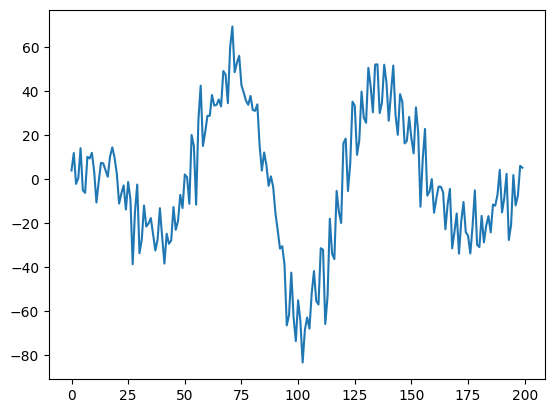

In [ ]:
plt.plot(bbh_train_corr[0,:,-1])

In [ ]:
# make the defined mask serializable, the defined mask is used in input training for both background and bbh data,
# the loss in reconstructing bbh signal will be masked to zero
@tf.keras.utils.register_keras_serializable()
def masked_mse_loss(y_true, y_pred):
        """
       y_true has shape (N,200,4), where:
          - The first two input_dim elements are the reconstruction target.
          - The last element is the mask: 0 for background, 1 for bbh/sg.
        We invert the mask so that:
          - Background (0) becomes 1 (compute loss).
          - bbh/sg (1) becomes 0 (ignore loss).
        """
        # mask: background becomes 1, others become 0.
        mask = (1 - y_true[..., -1])[...,-1]
        actual_target = y_true[..., :-1]

        mse = tf.reduce_mean(tf.square(actual_target - y_pred), axis=(1,2))
        masked_mse = mse * mask  # only background samples contribute
        sum_mse = tf.reduce_sum(masked_mse)
        count_bg = tf.reduce_sum(mask)
        avg_mse = sum_mse / (count_bg + 1e-8)
        return avg_mse



In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def positional_encoding(self, inputs): #I actually didnt use the positional_encoding at the end, but leave it there in case I will use it one day tuning the model
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        # x = layers.Dense(ff_dim, activation="relu")(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=18,padding='same', activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        # x = layers.Dense(inputs.shape[-1])(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=5,padding='same')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        decoder_in = x + res
        return decoder_in

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        ae_out = x+inputs
        return ae_out  # Adding input directly, assuming output_dim matches inputs shape[-1]


    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout):
        # Input(batch_size, 200, 2) with bg+bbh
        inputs = keras.Input(shape=input_shape)
        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        autoencoder_output = x
        pooled_features = layers.GlobalAveragePooling1D()(autoencoder_output)
        #Here gives the classifier output
        classifier_output = layers.Dense(1, activation='sigmoid', name='classifier_output')(pooled_features)

        # Decoder
        x = autoencoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        #Here gives the autoencoder_output
        autoencoder_output = layers.Dense(input_shape[-1], name='autoencoder_output')(x)

        #model input = inputs, output = classifier_output,autoencoder_output
        self.ae = keras.Model(inputs, {"classifier_output": classifier_output,
          "autoencoder_output": autoencoder_output})
        #model compile the model loss of autoencoder_output with the masked_mse_loss we defined before, with different loss weights
        self.ae.compile(loss={"classifier_output": 'binary_crossentropy','autoencoder_output': masked_mse_loss},loss_weights={
        'classifier_output': 5, 'autoencoder_output': 1 },metrics = {'classifier_output':'accuracy'}, optimizer=keras.optimizers.Adam(learning_rate = 1e-3))

# set the parameters
input_shape = x_train.shape[1:]
head_size = 4
num_heads = 2
ff_dim = 4
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.2


# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)



# In order to check the performance based on each training epoch, we save the model for each epoch
checkpoint = ModelCheckpoint(
    filepath='/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_{epoch:02d}.keras',  # File path pattern, using the epoch number in the file name
    save_weights_only=False,                # Set to True if you want to save only the weights
    save_freq='epoch',                      # Save at the end of every epoch
    verbose=1
)

history = autoencoder.ae.fit(X_train,
    {"classifier_output": cls_y_train,         # classification target
        "autoencoder_output": ae_y_train           # reconstruction target
    },
    validation_data=(
        X_val,
        {"classifier_output": cls_y_val,
          "autoencoder_output": ae_y_val}),
    epochs=100,
    batch_size=700,
    shuffle=False,
    callbacks=[checkpoint]        # add callback for saving
)



Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - autoencoder_output_loss: 84.4800 - classifier_output_accuracy: 0.3627 - classifier_output_loss: 0.8353 - loss: 88.6567
Epoch 1: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_01.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - autoencoder_output_loss: 84.3870 - classifier_output_accuracy: 0.3638 - classifier_output_loss: 0.8346 - loss: 88.5604 - val_autoencoder_output_loss: 38.8056 - val_classifier_output_accuracy: 0.9294 - val_classifier_output_loss: 0.4105 - val_loss: 40.8567
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - autoencoder_output_loss: 32.6173 - classifier_output_accuracy: 0.9229 - classifier_output_loss: 0.3954 - loss: 34.5944
Epoch 2: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_02.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - autoencoder_output_loss: 32.5813 - classifier_output_accur

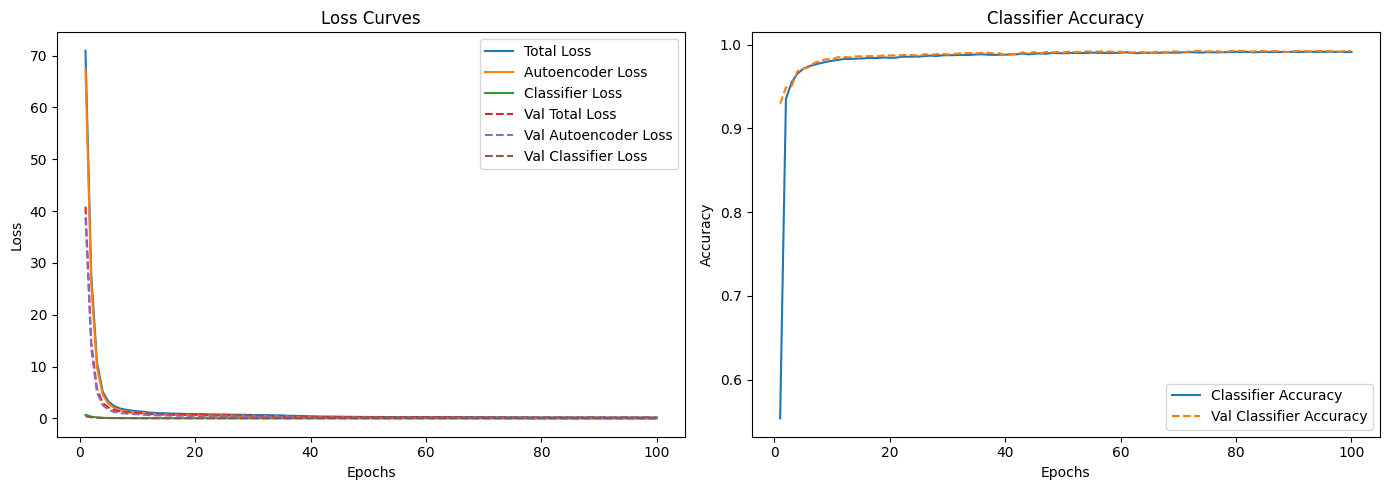

In [ ]:
# Extract training history values
loss = history.history['loss']
autoencoder_loss = history.history['autoencoder_output_loss']
classifier_loss = history.history['classifier_output_loss']
classifier_accuracy = history.history['classifier_output_accuracy']

# Extract validation history values
val_loss = history.history['val_loss']
val_autoencoder_loss = history.history['val_autoencoder_output_loss']
val_classifier_loss = history.history['val_classifier_output_loss']
val_classifier_accuracy = history.history['val_classifier_output_accuracy']

epochs = range(1, len(loss) + 1)

# Plot total loss and individual loss components
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Total Loss')
plt.plot(epochs, autoencoder_loss, label='Autoencoder Loss')
plt.plot(epochs, classifier_loss, label='Classifier Loss')
plt.plot(epochs, val_loss, label='Val Total Loss', linestyle='--')
plt.plot(epochs, val_autoencoder_loss, label='Val Autoencoder Loss', linestyle='--')
plt.plot(epochs, val_classifier_loss, label='Val Classifier Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot classifier accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, classifier_accuracy, label='Classifier Accuracy')
plt.plot(epochs, val_classifier_accuracy, label='Val Classifier Accuracy', linestyle='--')
plt.title('Classifier Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load Test dataset
background_test = np.load('background_test.npy')
stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test = background_test/stds_test
background_test = np.swapaxes(background_test, 1, 2)

bbh_test = np.load('bbh_test.npy')
stds_test = np.std(bbh_test, axis=-1)[:, :, np.newaxis]
bbh_test = bbh_test/stds_test
bbh_test = np.swapaxes(bbh_test, 1, 2)

sglf_test = np.load('sglf_test.npy')
stds_test = np.std(sglf_test, axis=-1)[:, :, np.newaxis]
sglf_test = sglf_test/stds_test
sglf_test = np.swapaxes(sglf_test, 1, 2)

# Add correlation
background_test = add_correlation_channel(background_test)
bbh_test = add_correlation_channel(bbh_test)
sglf_test = add_correlation_channel(sglf_test)

# Prepare input x_test and target
x_test = np.concatenate([background_test, bbh_test, sglf_test], axis=0)

cl_target_test = np.concatenate([
    np.zeros(background_test.shape[:1]+ (1,) ),
    np.ones(bbh_test.shape[:1]+ (1,)),
    np.ones(sglf_test.shape[:1]+ (1,))
], axis=0)

ae_target_test = np.concatenate([
    np.zeros(background_test.shape[:2]+ (1,) ),
    np.ones(bbh_test.shape[:2]+ (1,)),
    np.ones(sglf_test.shape[:2]+ (1,))
], axis=0)

ae_target_test = np.concatenate([x_test,ae_target_test], axis=-1)

test_indices = np.random.permutation(x_test.shape[0])
x_test = x_test[test_indices]
cl_target_test = cl_target_test[test_indices]
ae_target_test = ae_target_test[test_indices]


In [ ]:
# Test on classifier output, remind: the x_test is not a balanced dataset, with bg:bbh:sg = 1:1:1
arr = autoencoder.ae.predict(x_test)['classifier_output']
pred_prob = np.mean(arr, axis=1).squeeze()
true_prob = np.mean(cl_target_test, axis=1).squeeze()

# threshold into 0/1 labels
pred_labels = (pred_prob >= 0.5).astype(int)
true_labels = (true_prob >= 0.5).astype(int)

# compute accuracy and confusion matrix
acc = accuracy_score(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
accuracy = (tp + tn) / (tn + fp + fn + tp)
print("Confusion Matrix:\n", cm)
print("TPR (Recall/Sensitivity):", tpr)
print("Accuracy:", accuracy)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Confusion Matrix:
 [[19873   127]
 [16149 23851]]
TPR (Recall/Sensitivity): 0.596275
Accuracy: 0.7287333333333333


Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_01.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


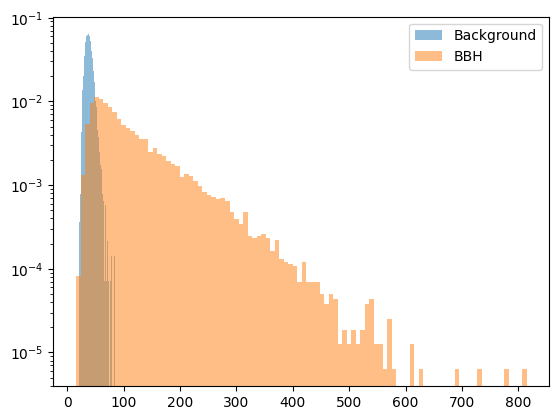

evaluation bg vs sg


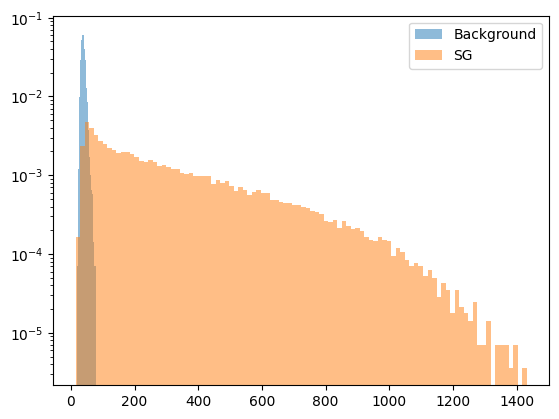

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_02.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


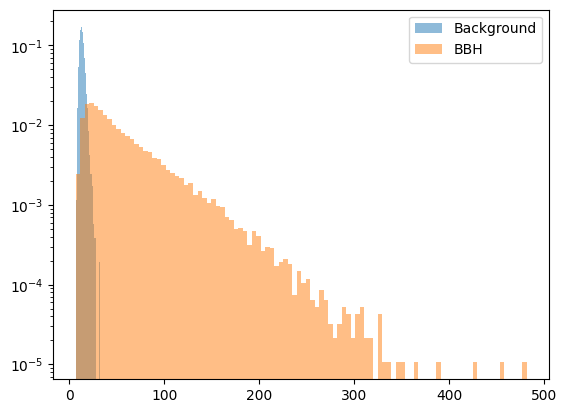

evaluation bg vs sg


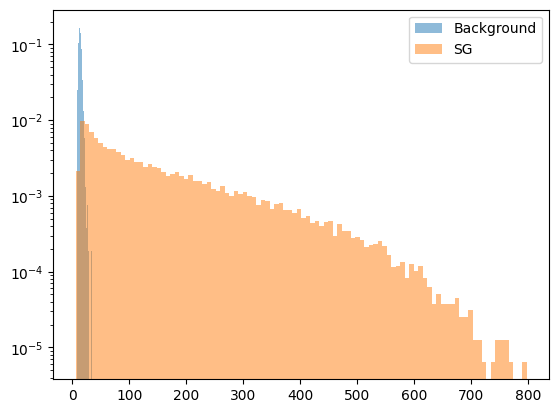

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_03.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


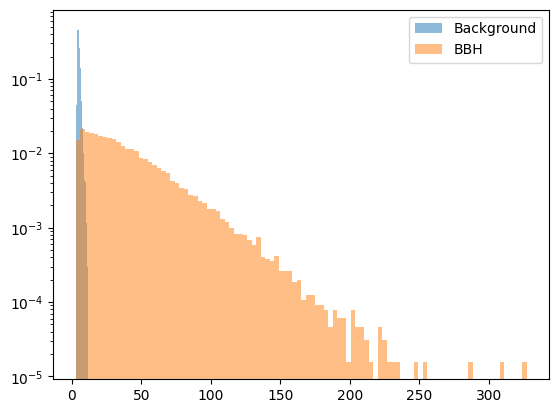

evaluation bg vs sg


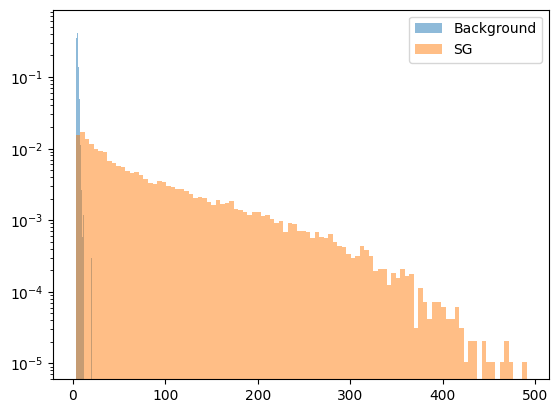

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_04.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


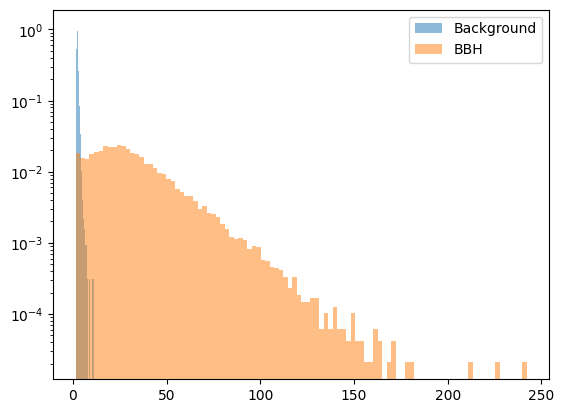

evaluation bg vs sg


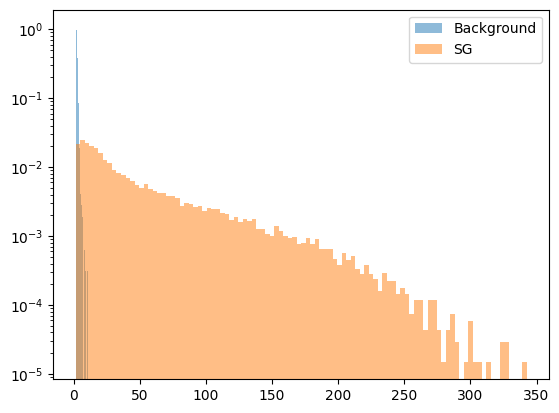

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_05.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


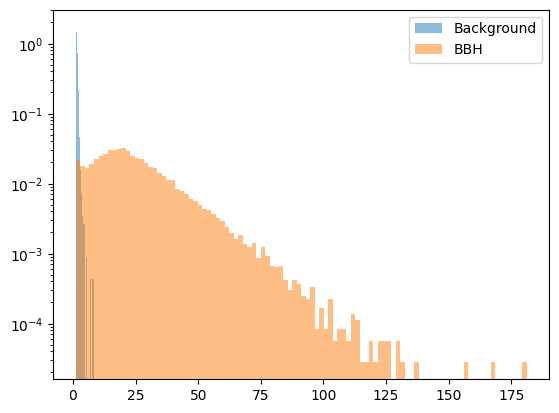

evaluation bg vs sg


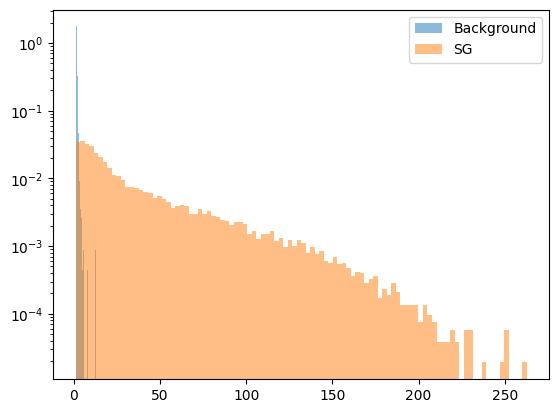

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_06.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


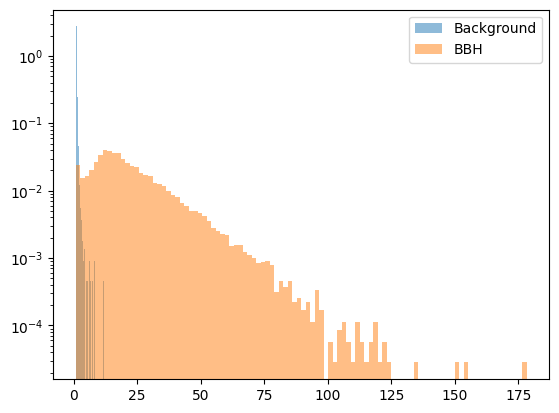

evaluation bg vs sg


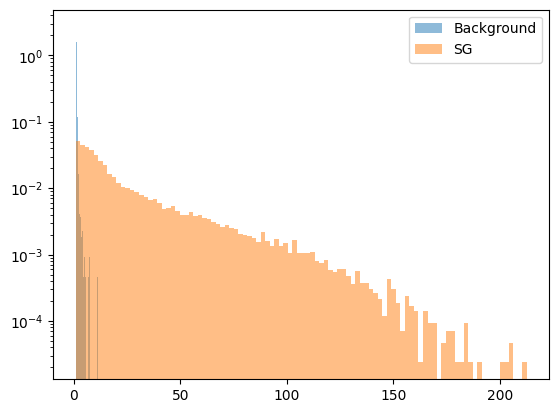

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_07.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


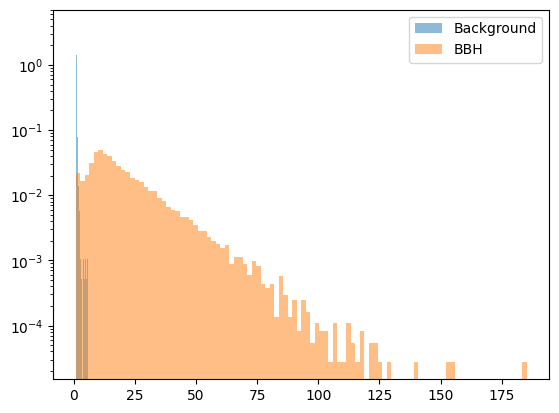

evaluation bg vs sg


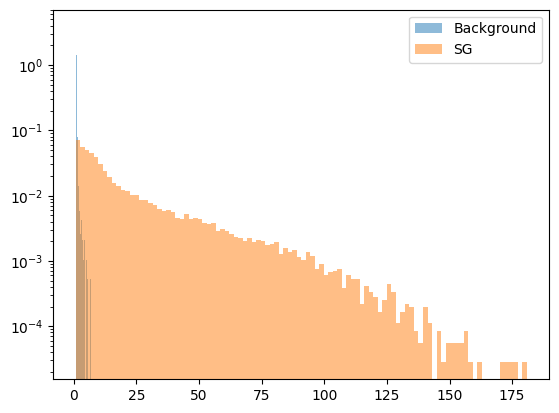

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_08.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


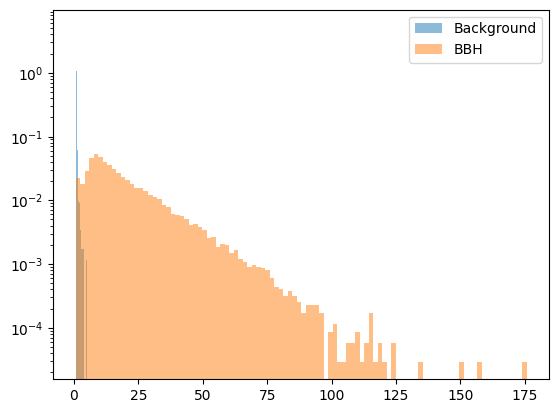

evaluation bg vs sg


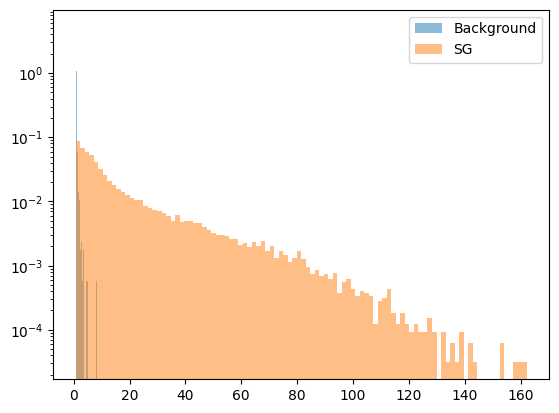

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_09.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


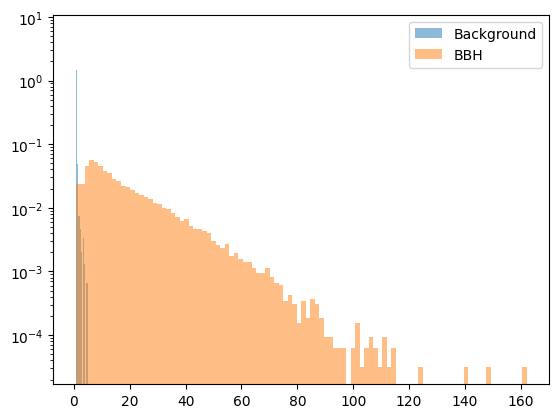

evaluation bg vs sg


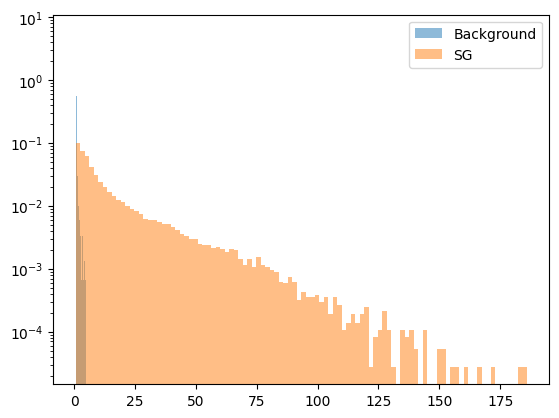

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_10.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


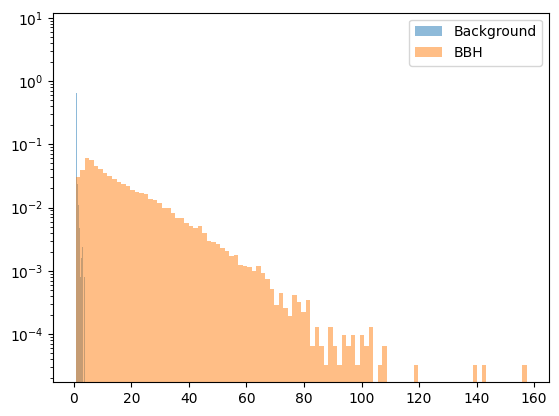

evaluation bg vs sg


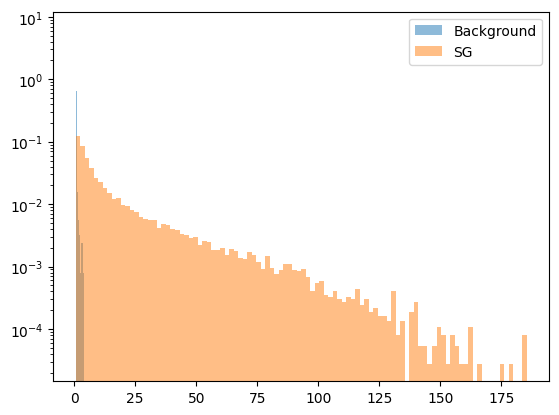

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_11.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


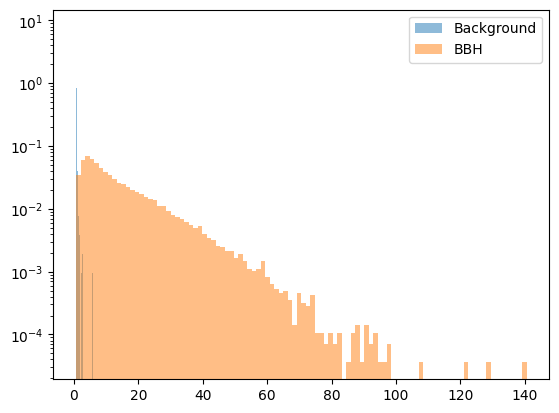

evaluation bg vs sg


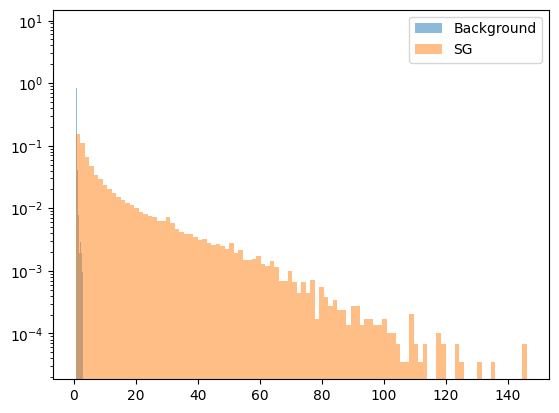

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_12.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


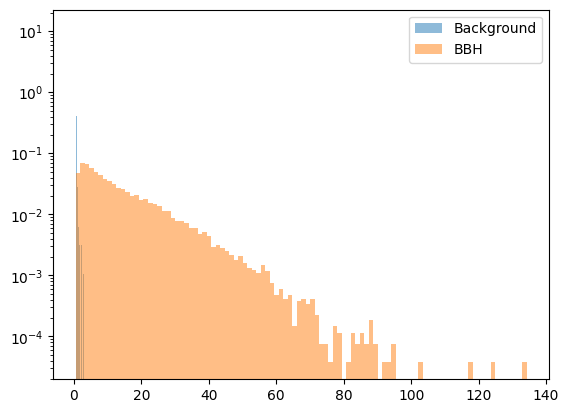

evaluation bg vs sg


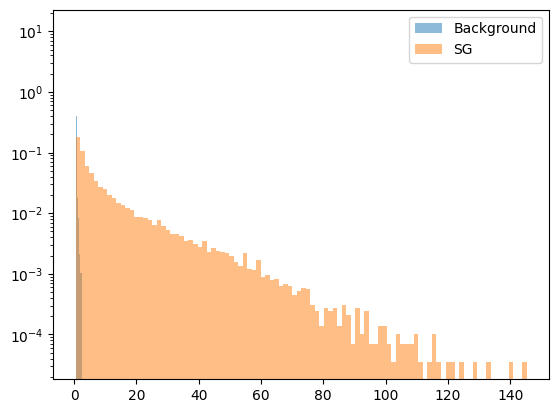

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_13.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


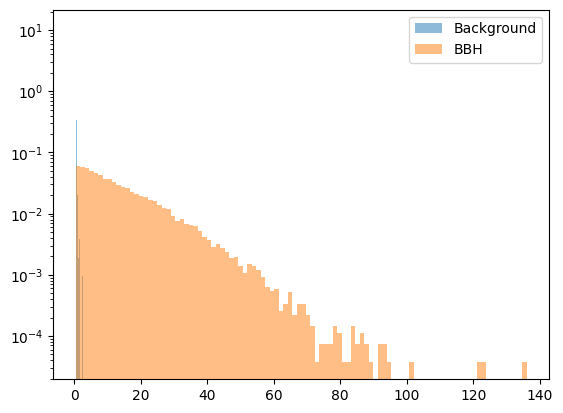

evaluation bg vs sg


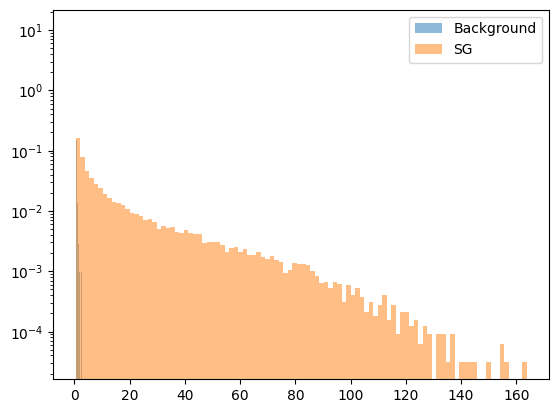

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_14.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


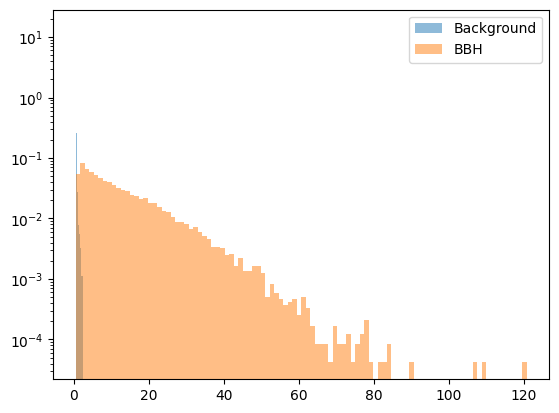

evaluation bg vs sg


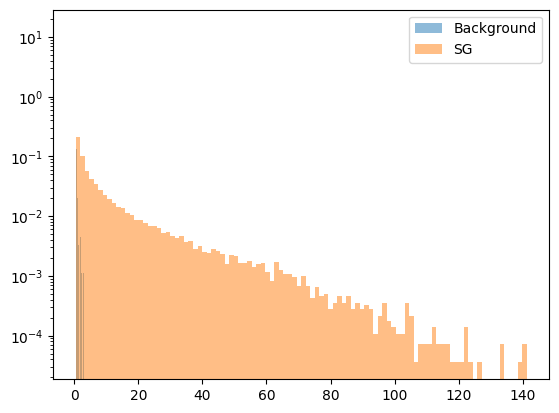

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_15.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


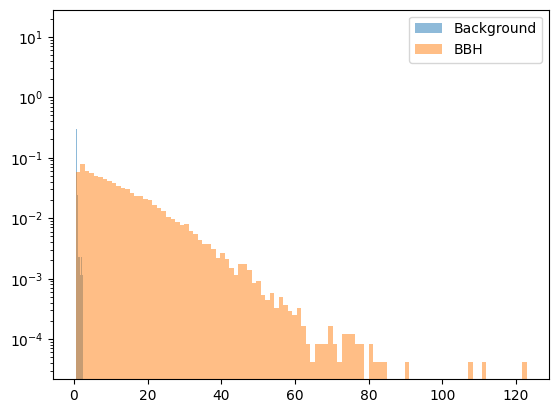

evaluation bg vs sg


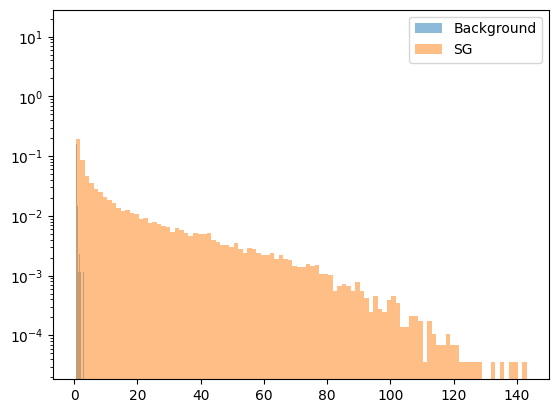

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_16.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


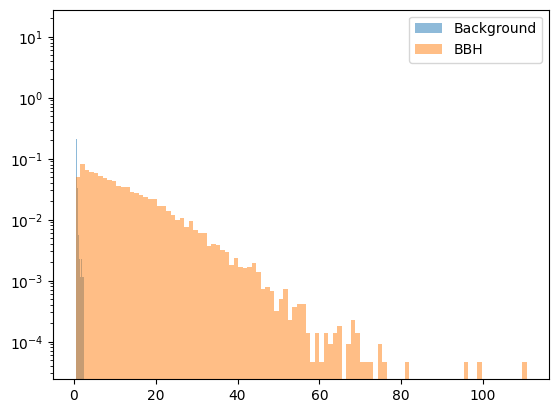

evaluation bg vs sg


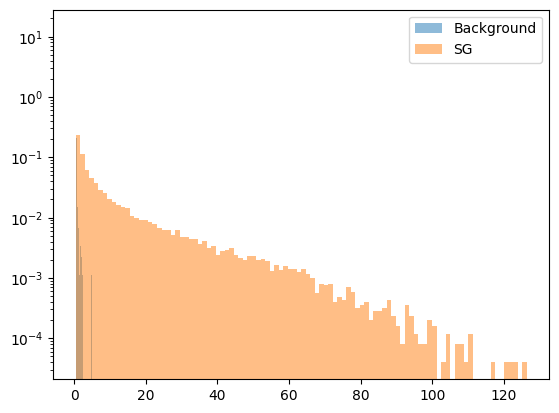

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_17.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


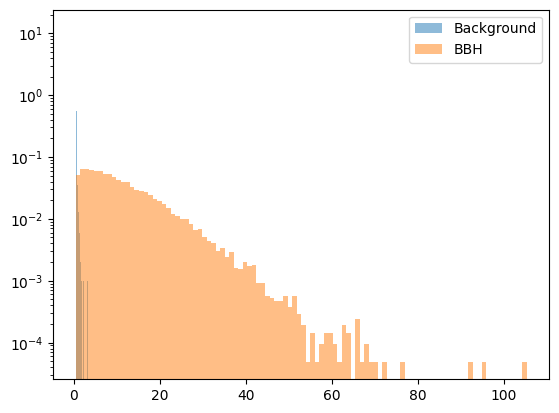

evaluation bg vs sg


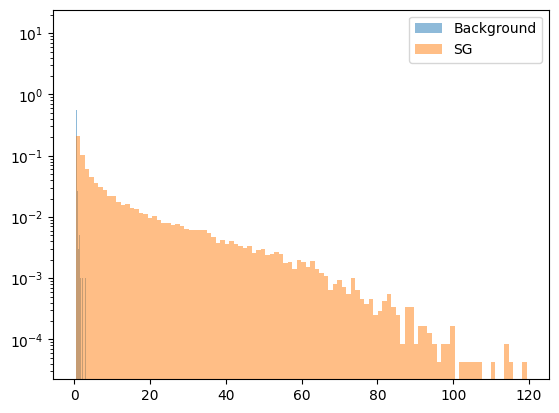

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_18.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


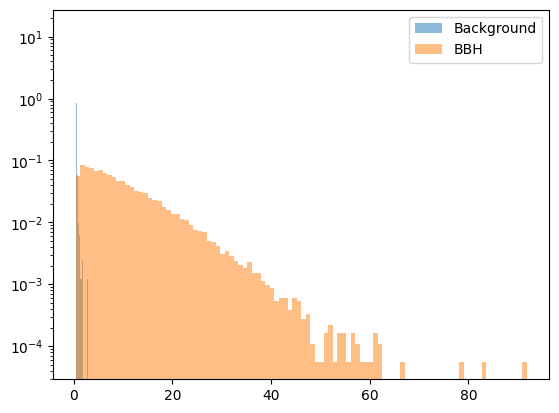

evaluation bg vs sg


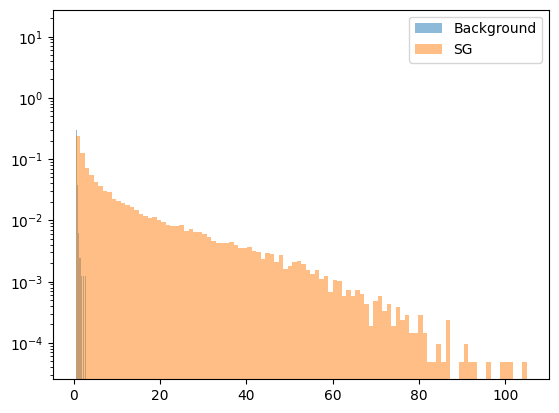

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_19.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


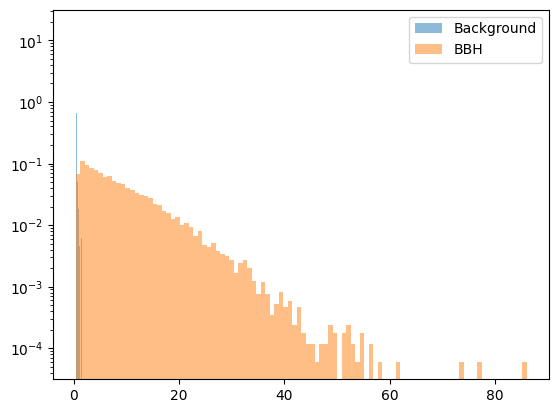

evaluation bg vs sg


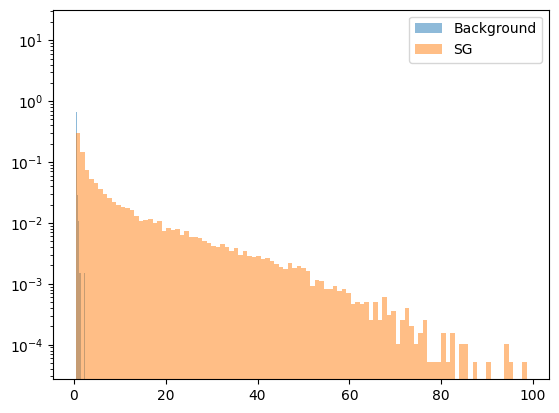

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_20.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


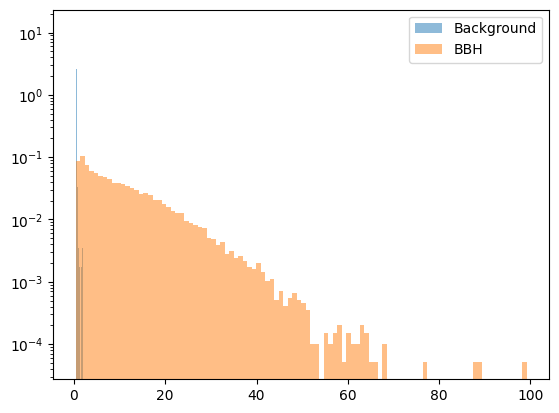

evaluation bg vs sg


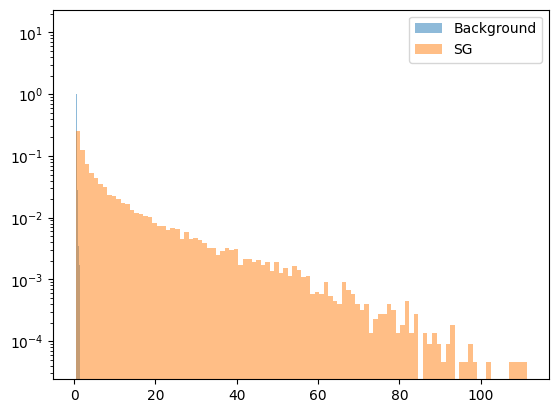

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_21.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


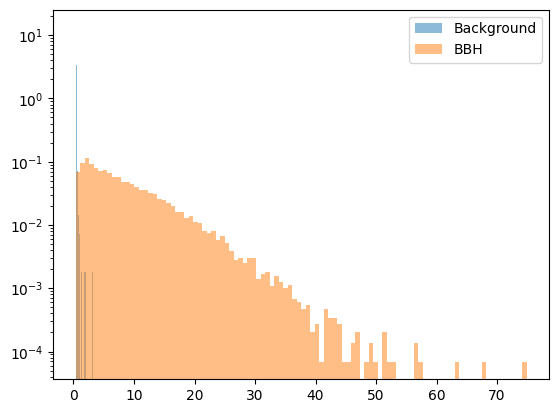

evaluation bg vs sg


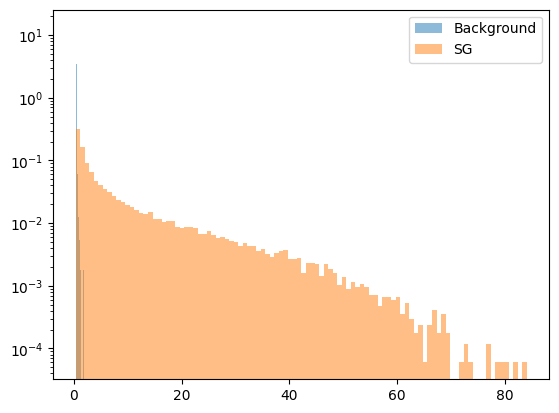

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_22.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


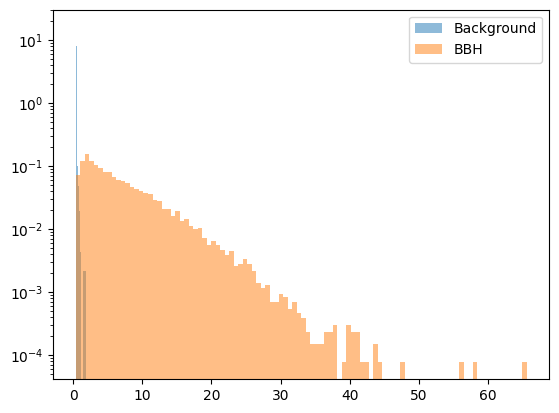

evaluation bg vs sg


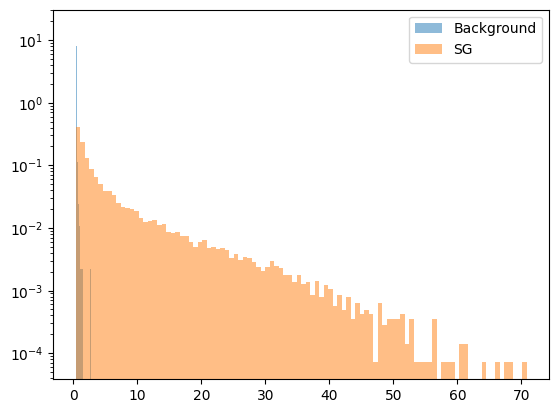

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_23.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


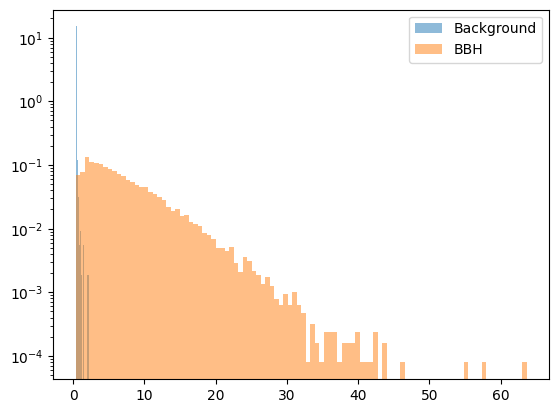

evaluation bg vs sg


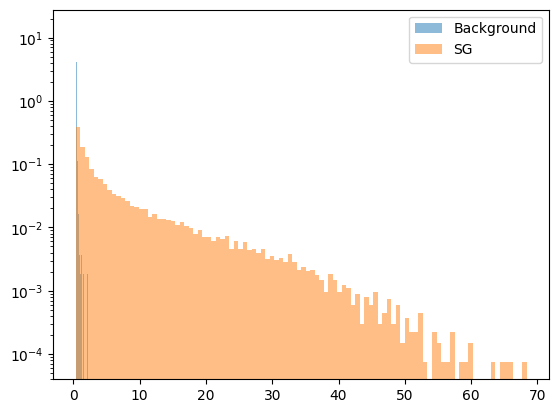

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_24.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


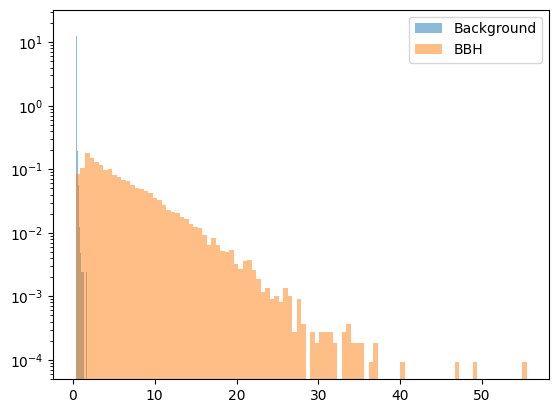

evaluation bg vs sg


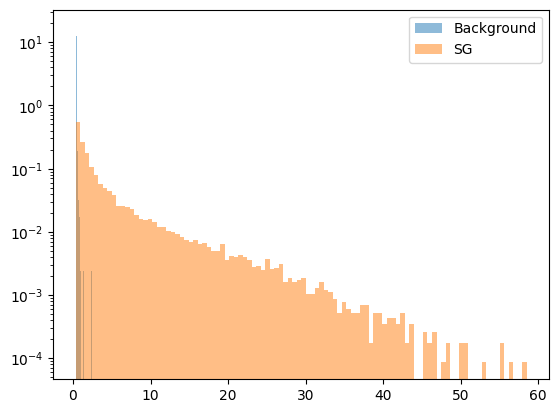

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_25.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


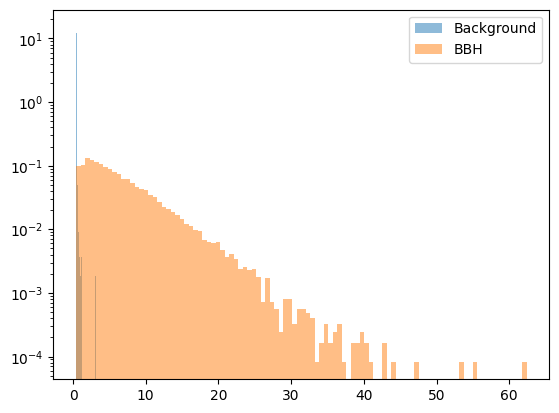

evaluation bg vs sg


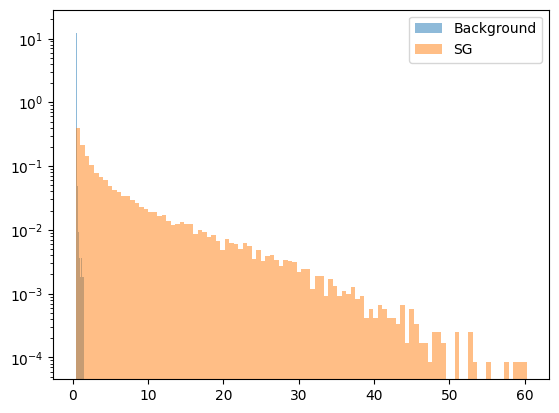

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_26.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


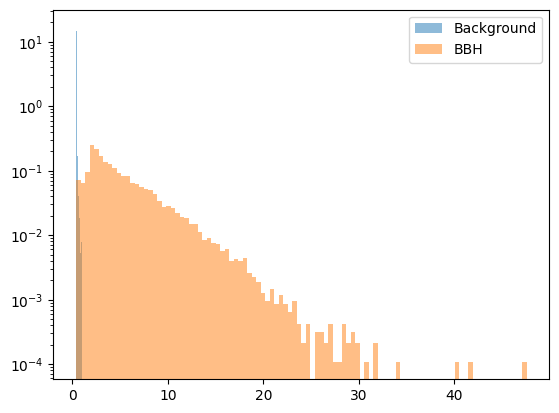

evaluation bg vs sg


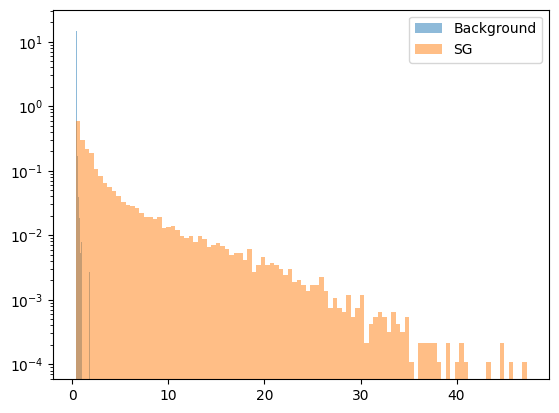

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_27.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


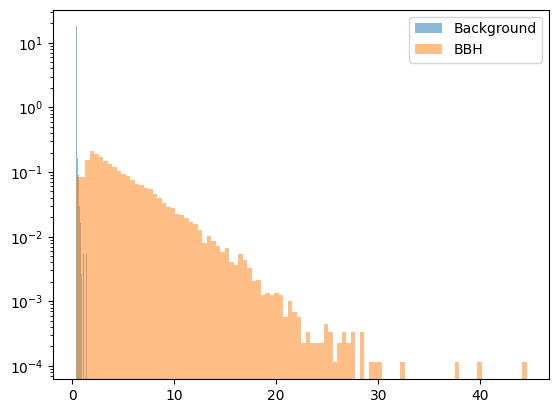

evaluation bg vs sg


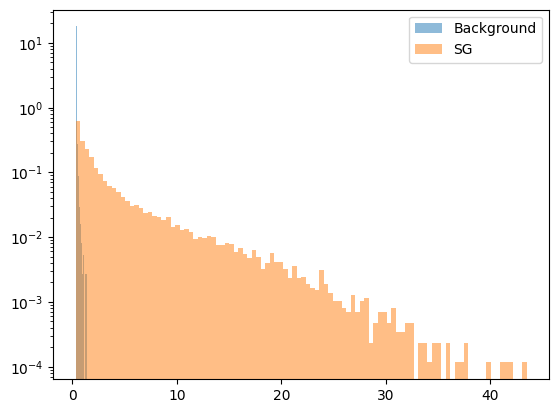

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_28.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


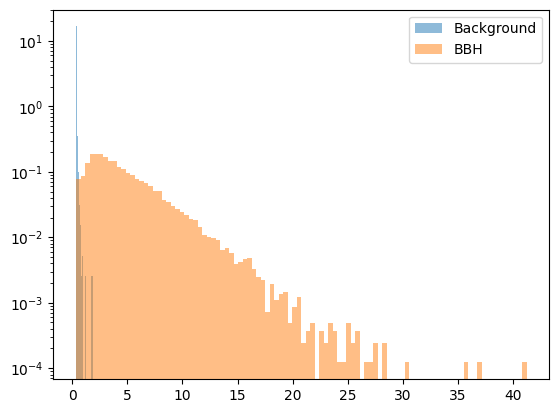

evaluation bg vs sg


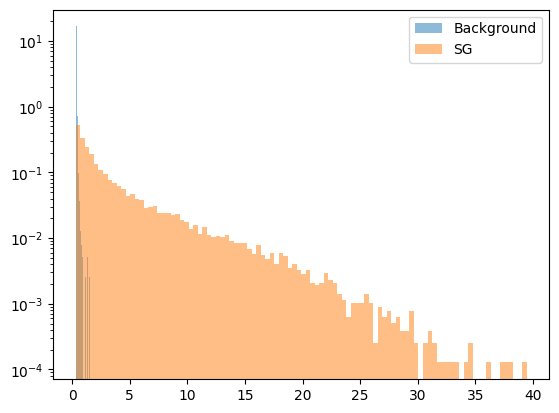

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_29.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


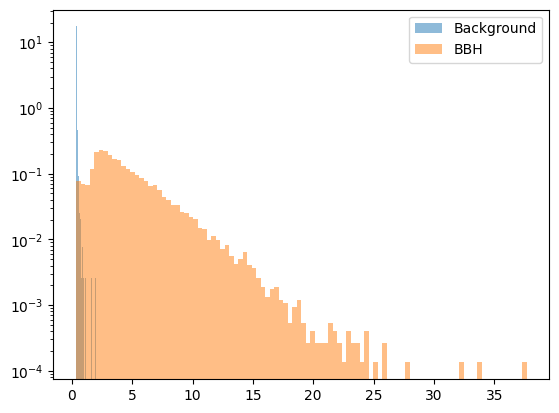

evaluation bg vs sg


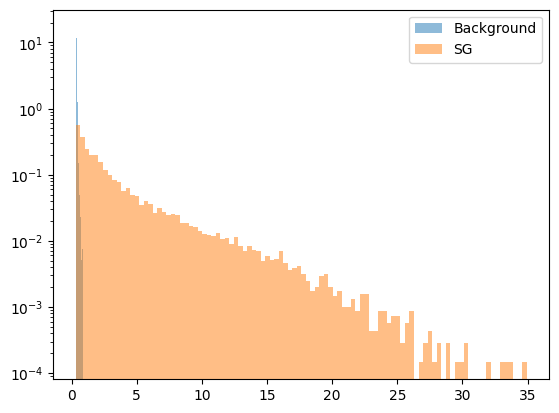

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_30.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


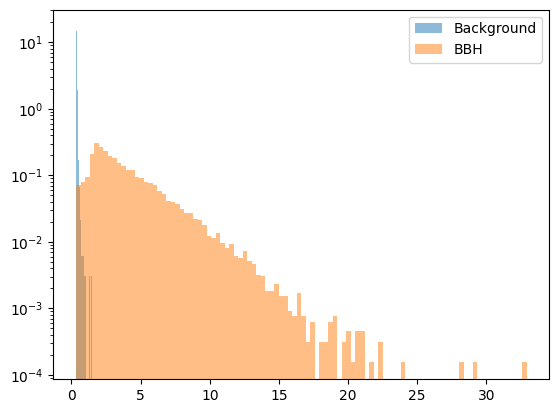

evaluation bg vs sg


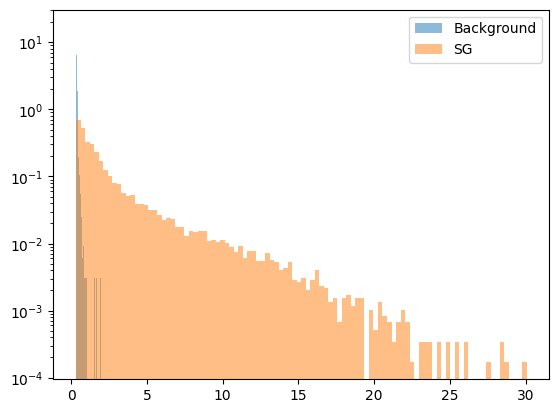

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_31.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


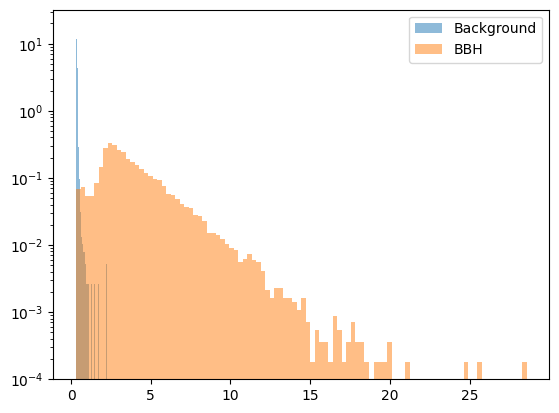

evaluation bg vs sg


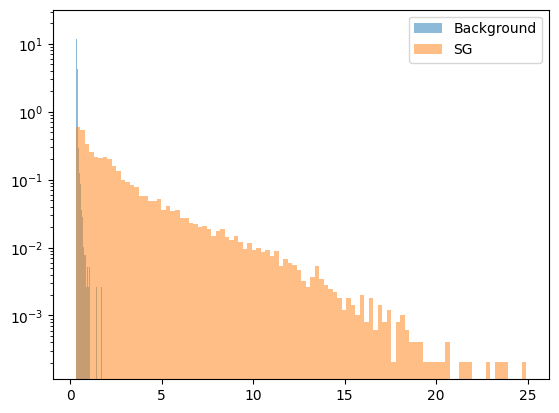

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_32.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


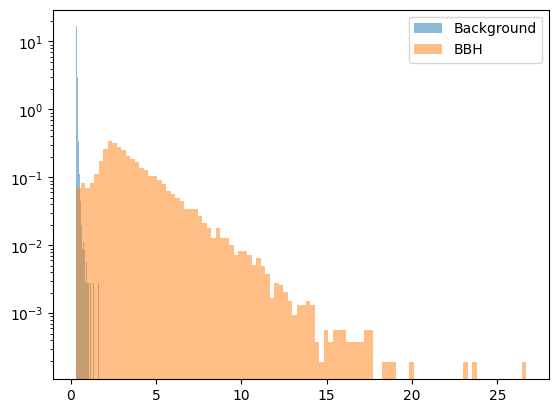

evaluation bg vs sg


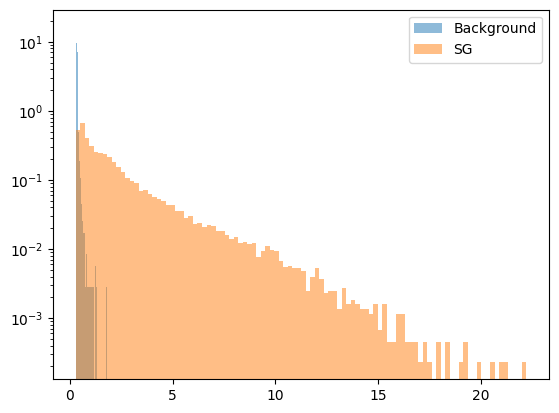

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_33.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


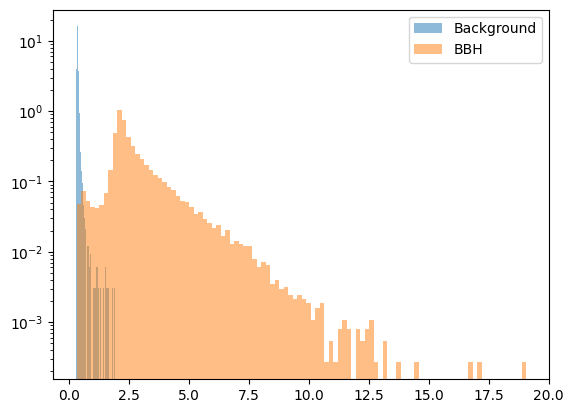

evaluation bg vs sg


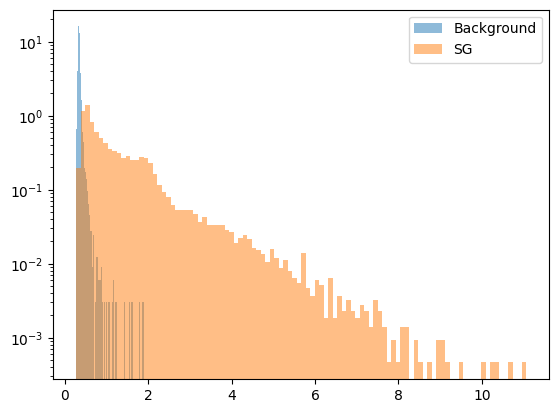

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_34.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


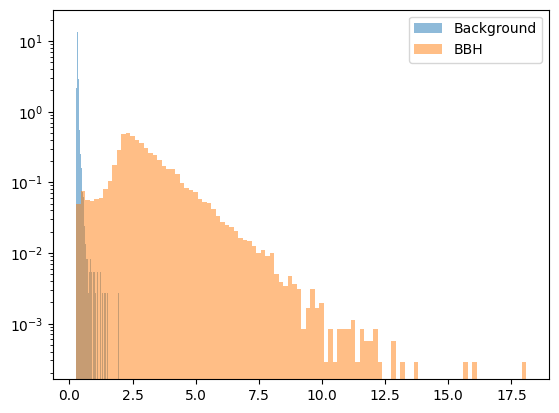

evaluation bg vs sg


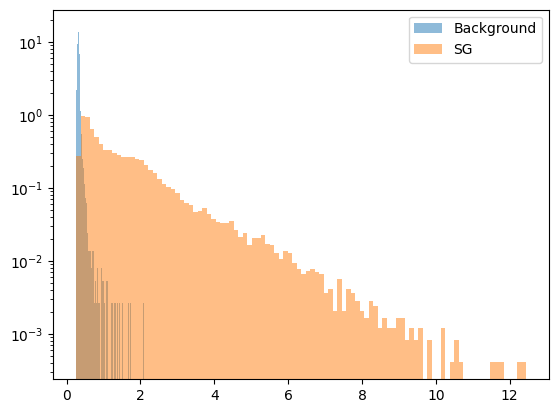

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_35.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


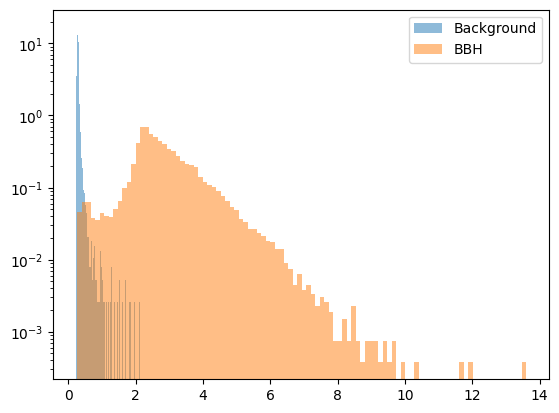

evaluation bg vs sg


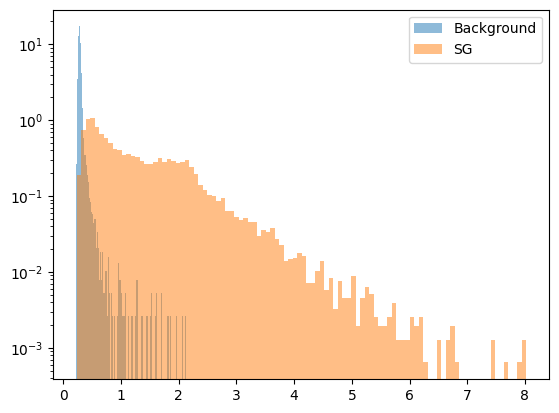

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_36.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


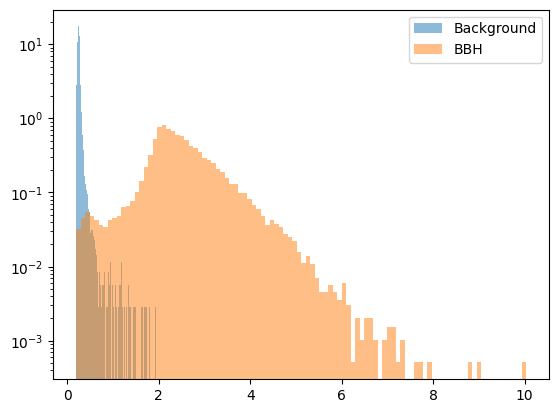

evaluation bg vs sg


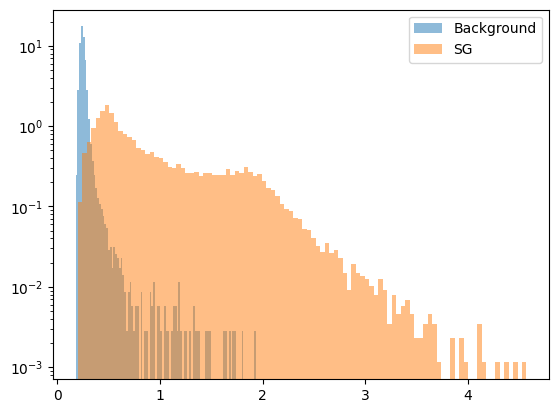

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_37.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


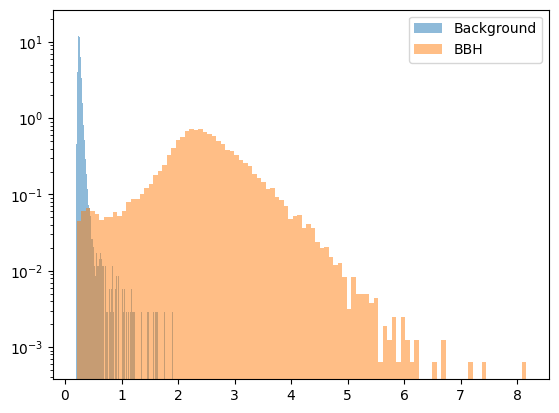

evaluation bg vs sg


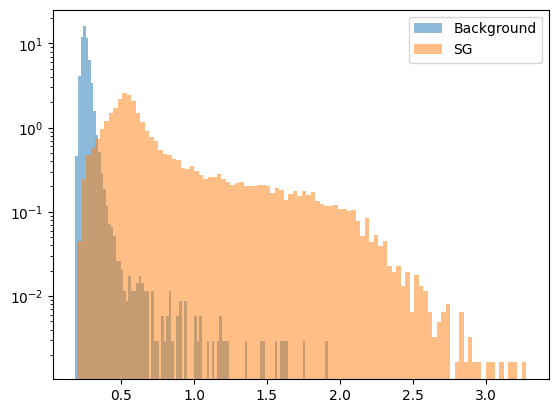

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_38.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


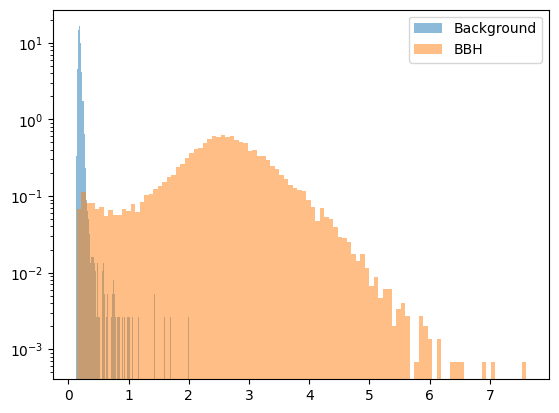

evaluation bg vs sg


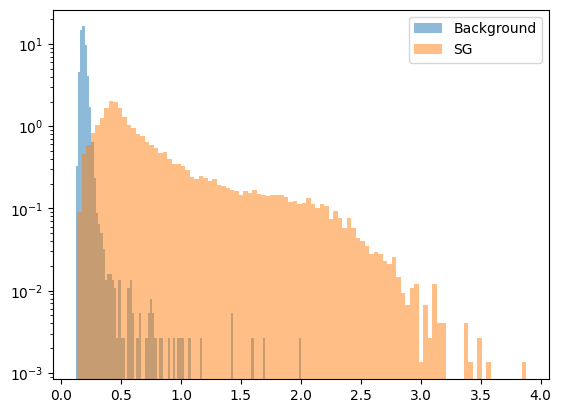

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_39.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


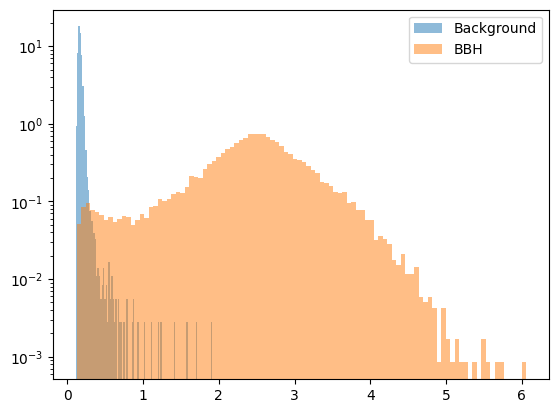

evaluation bg vs sg


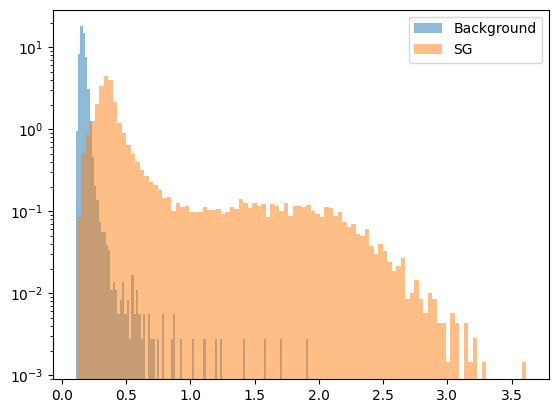

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_40.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


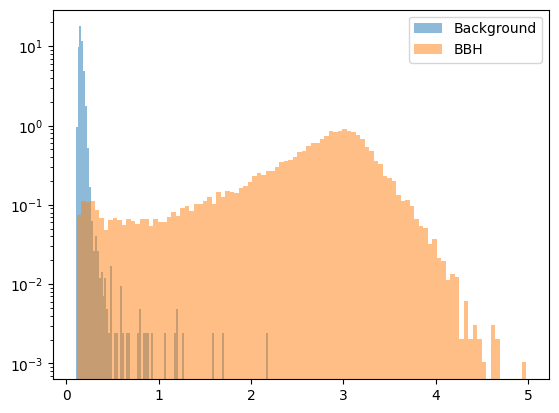

evaluation bg vs sg


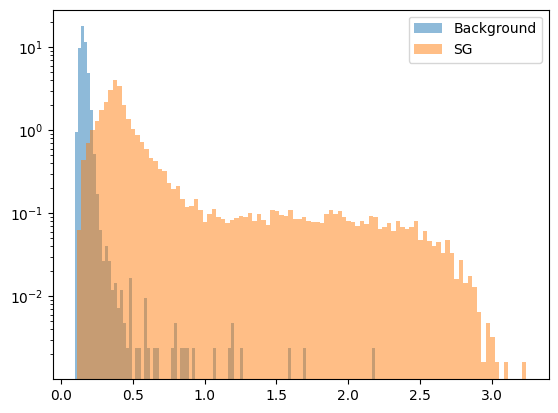

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_41.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


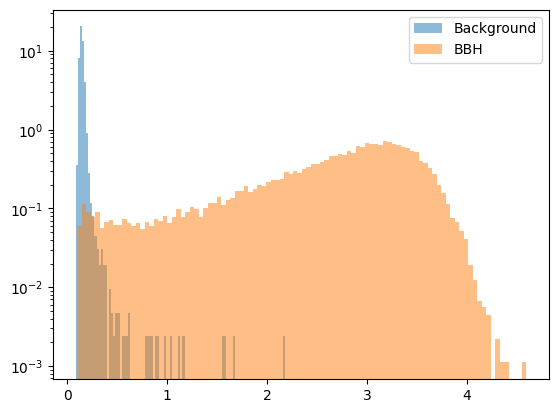

evaluation bg vs sg


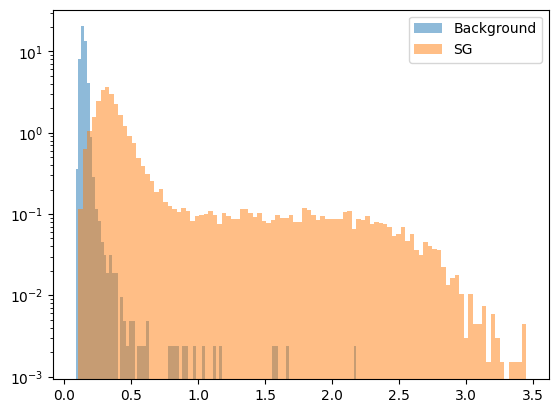

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_42.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


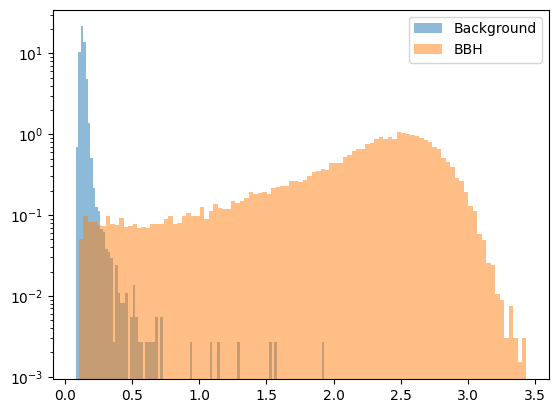

evaluation bg vs sg


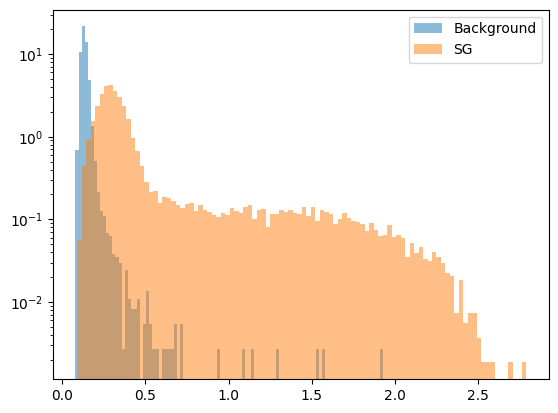

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_43.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


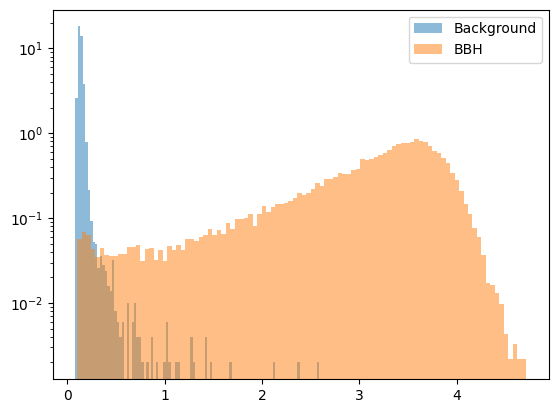

evaluation bg vs sg


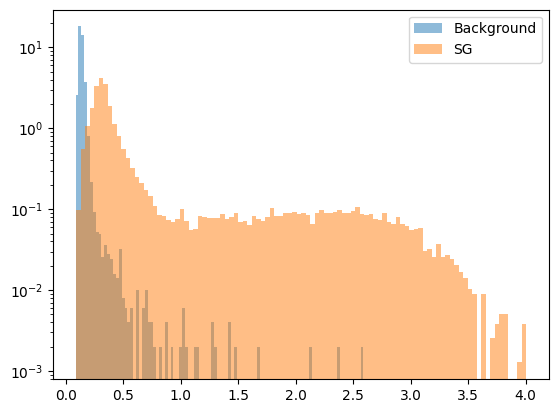

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_44.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


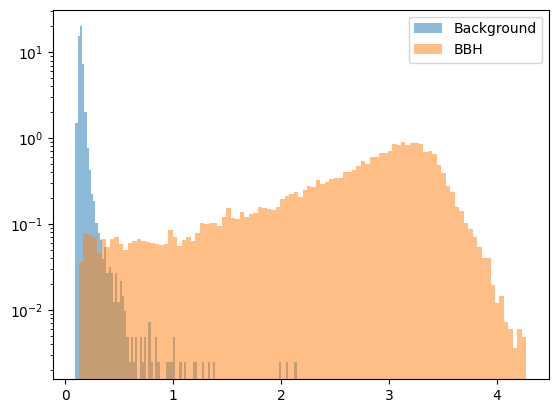

evaluation bg vs sg


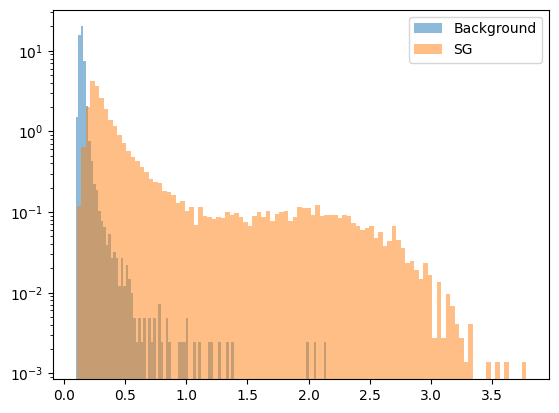

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_45.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


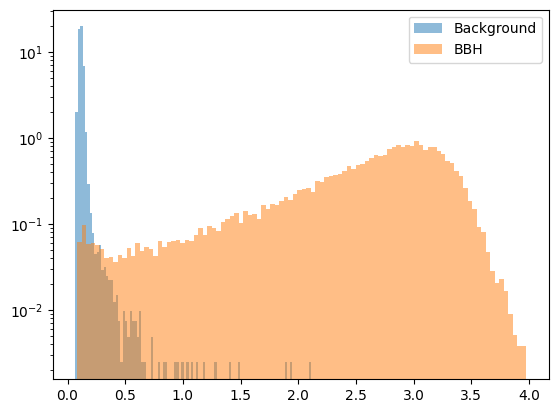

evaluation bg vs sg


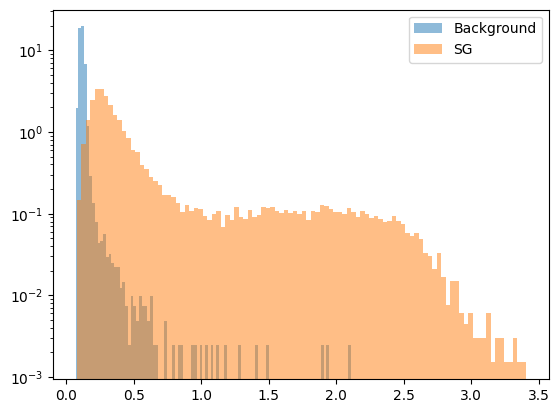

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_46.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


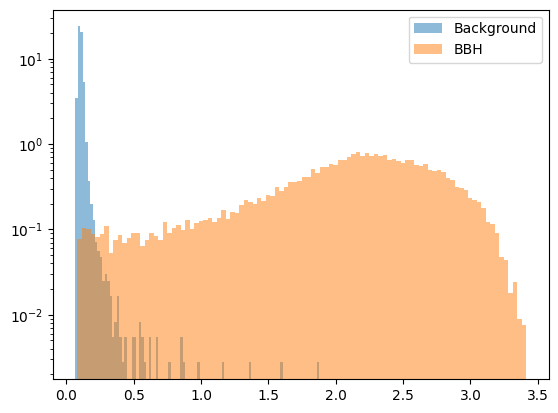

evaluation bg vs sg


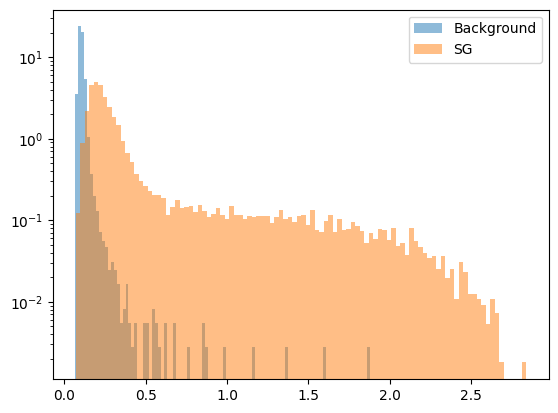

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_47.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


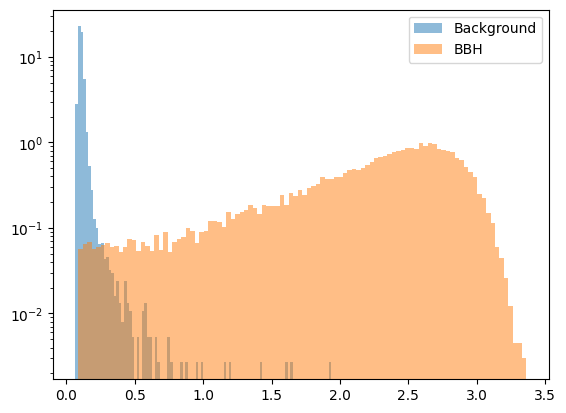

evaluation bg vs sg


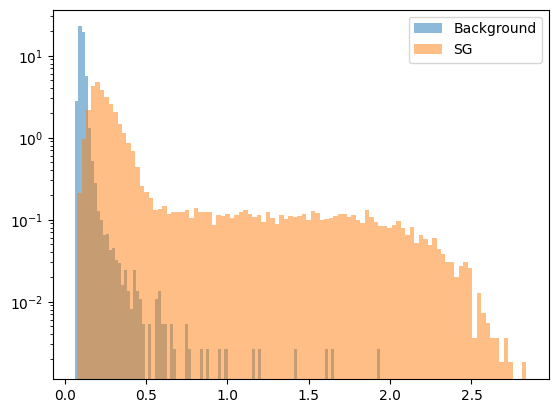

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_48.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


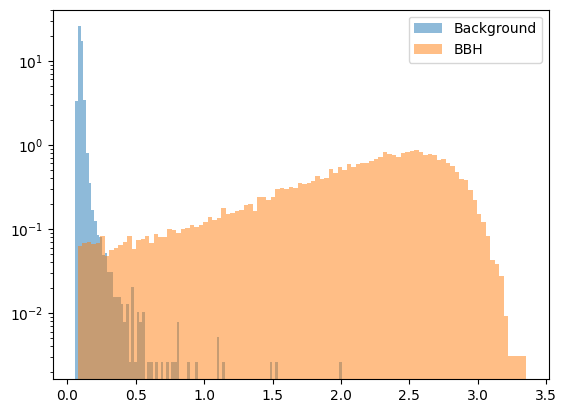

evaluation bg vs sg


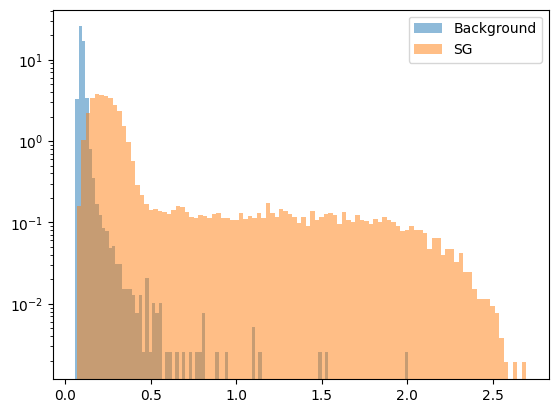

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_49.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


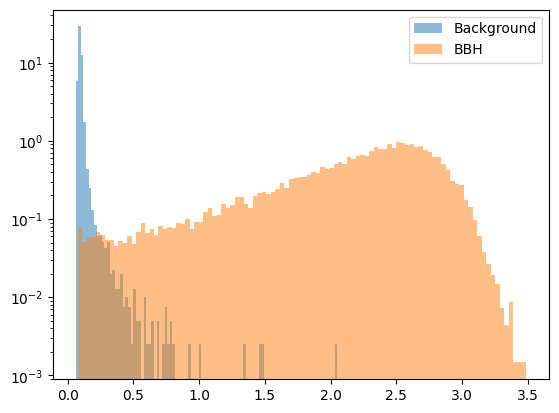

evaluation bg vs sg


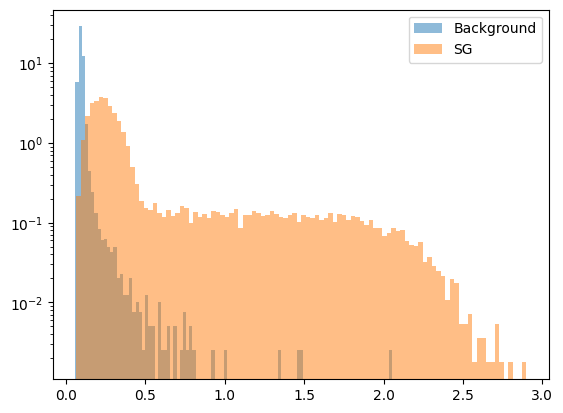

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_50.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


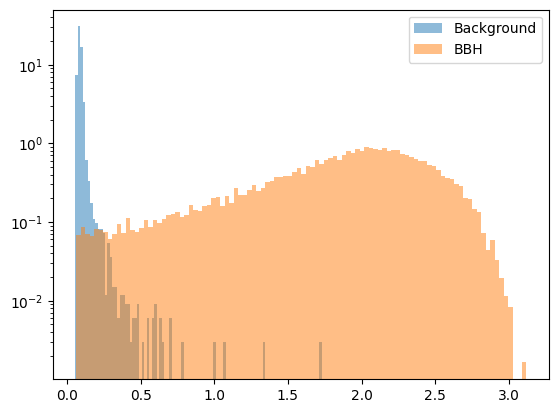

evaluation bg vs sg


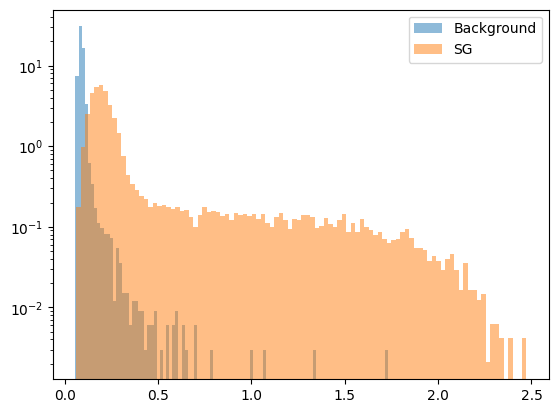

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_51.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


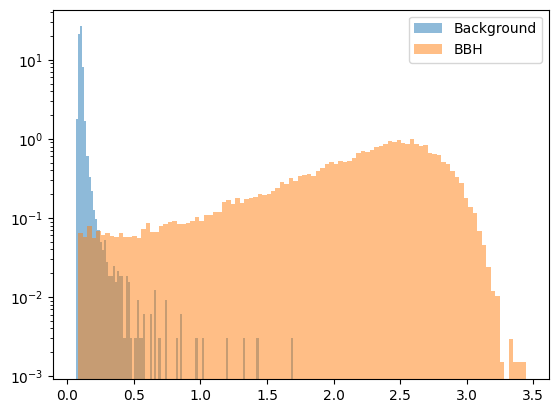

evaluation bg vs sg


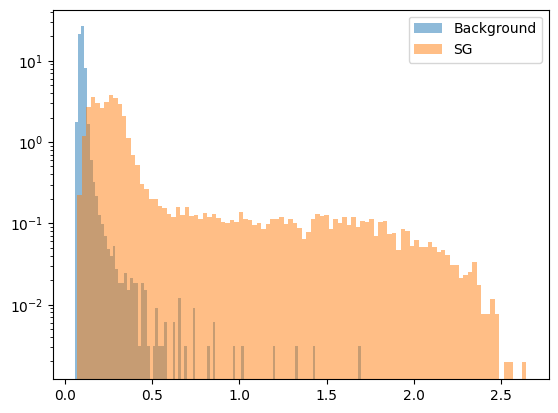

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_52.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


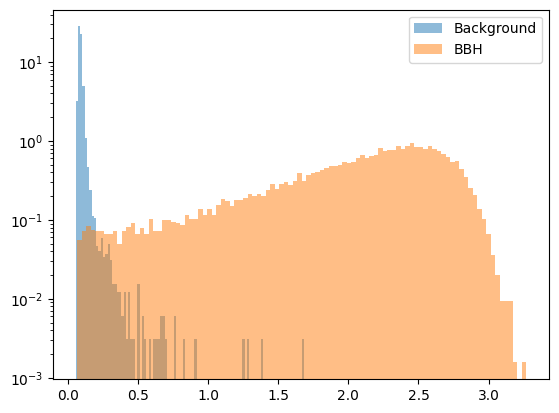

evaluation bg vs sg


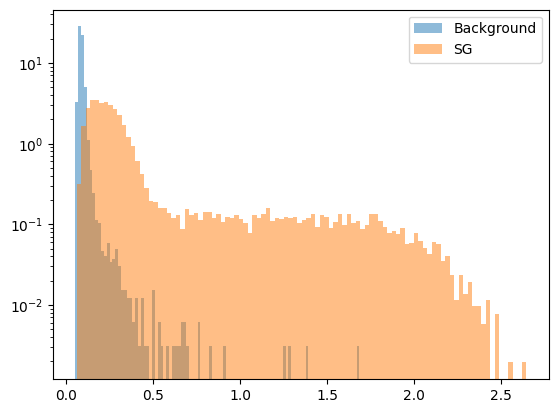

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_53.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


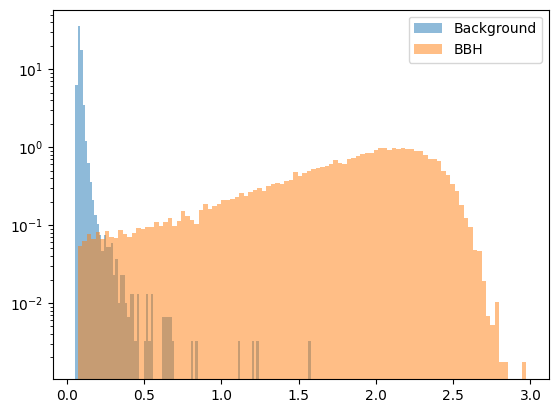

evaluation bg vs sg


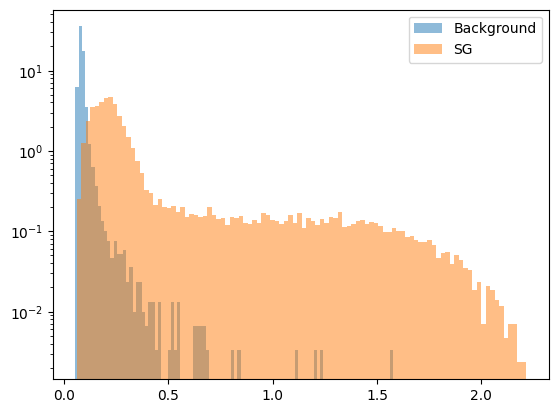

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_54.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


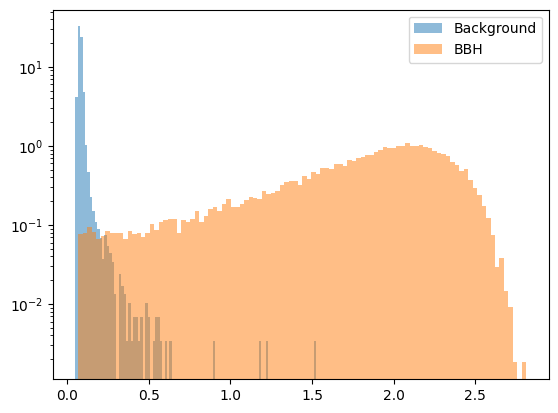

evaluation bg vs sg


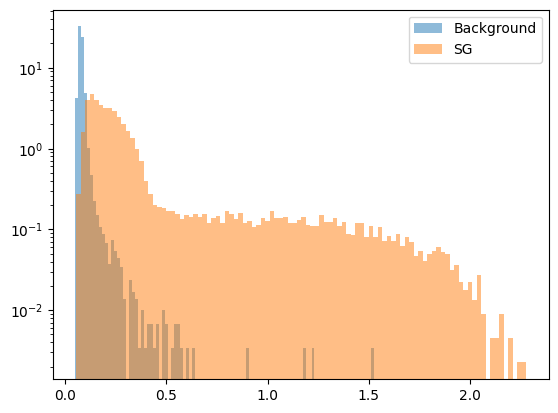

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_55.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


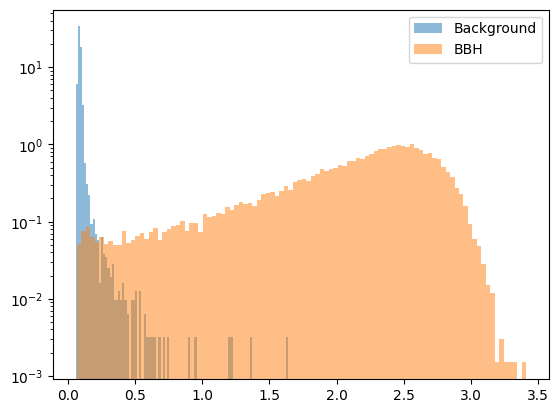

evaluation bg vs sg


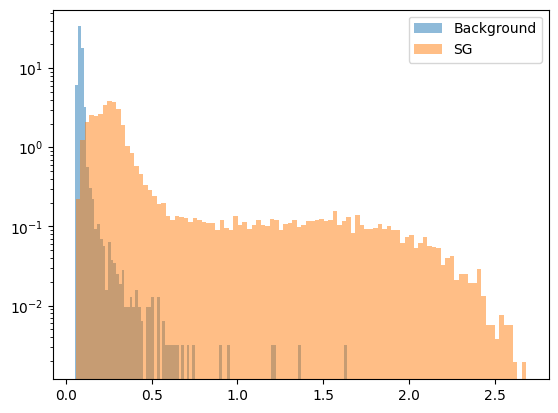

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_56.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


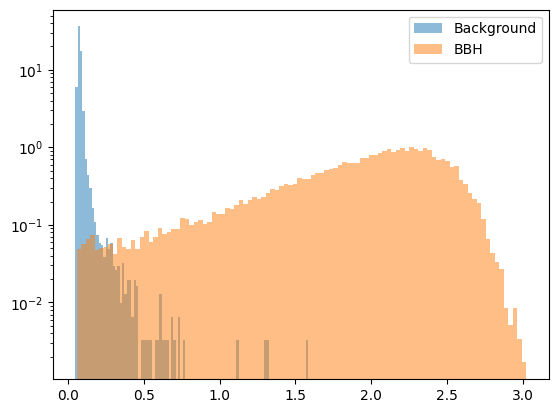

evaluation bg vs sg


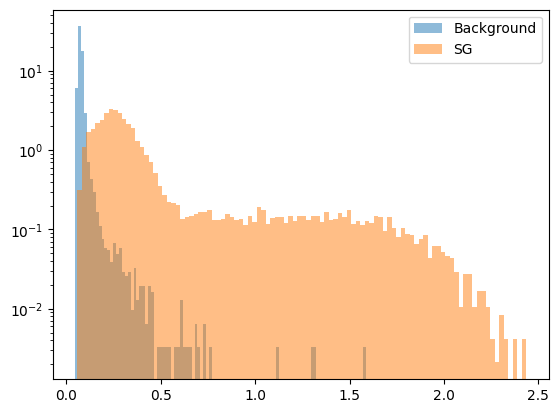

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_57.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


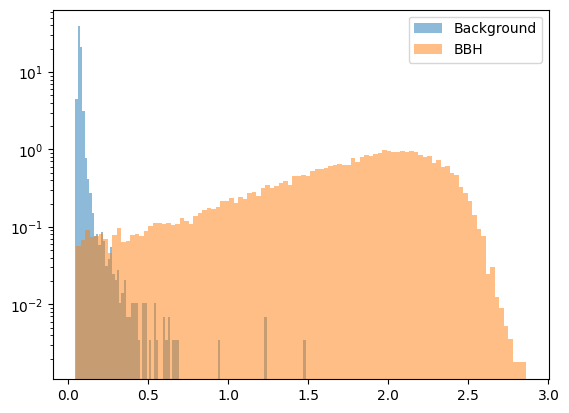

evaluation bg vs sg


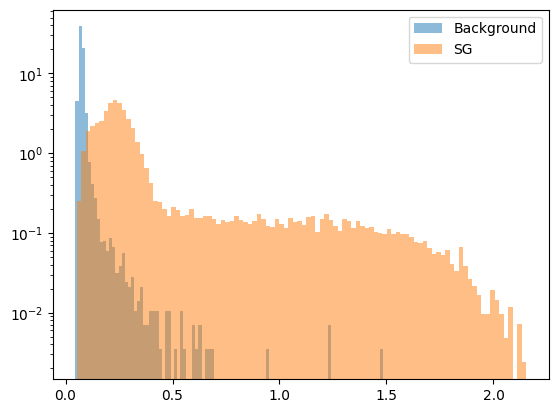

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_58.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


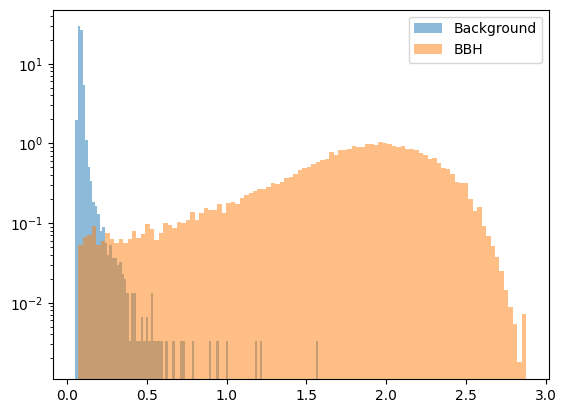

evaluation bg vs sg


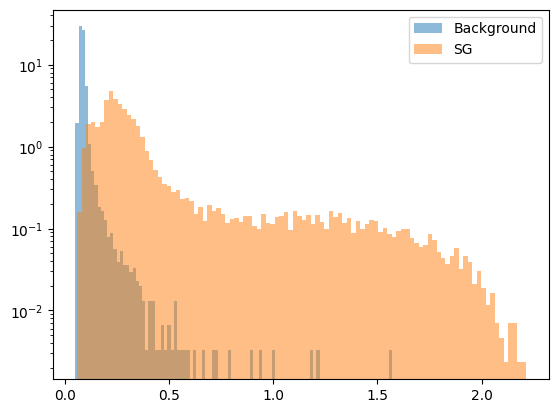

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_59.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


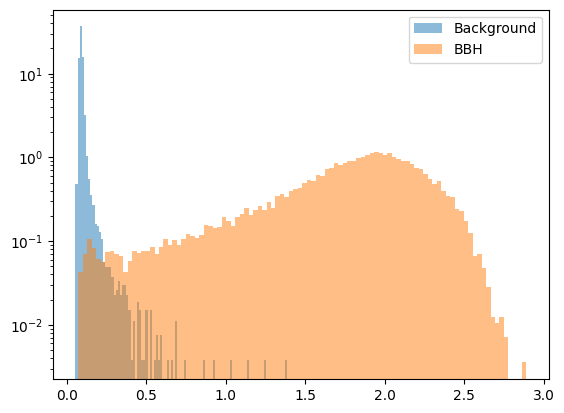

evaluation bg vs sg


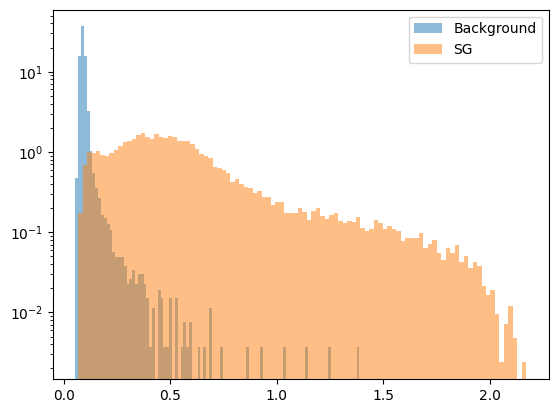

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_60.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


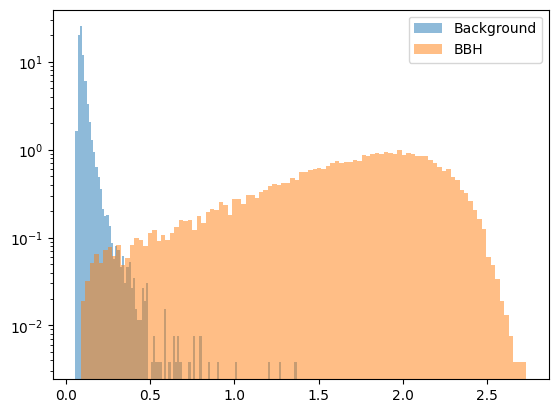

evaluation bg vs sg


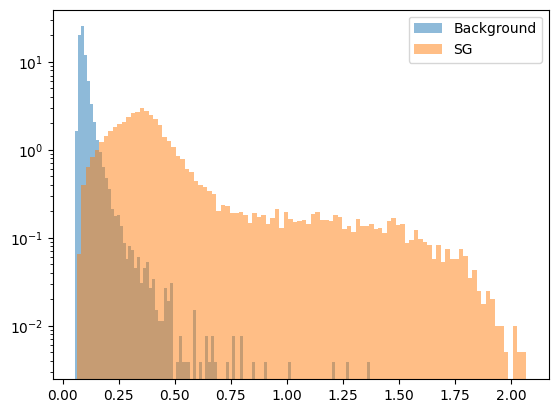

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_61.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


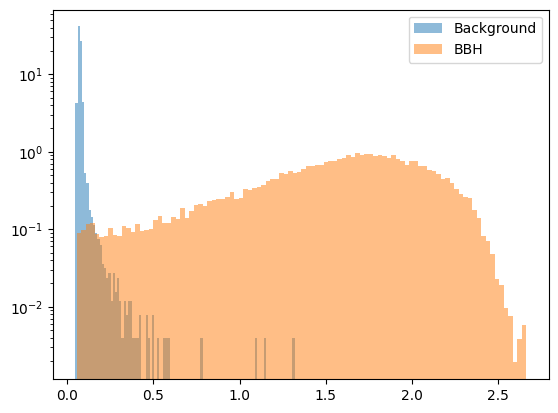

evaluation bg vs sg


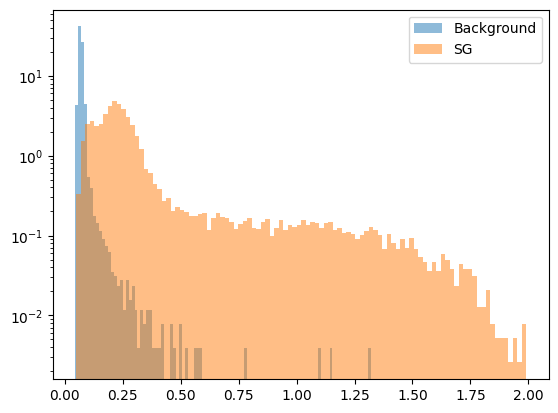

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_62.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


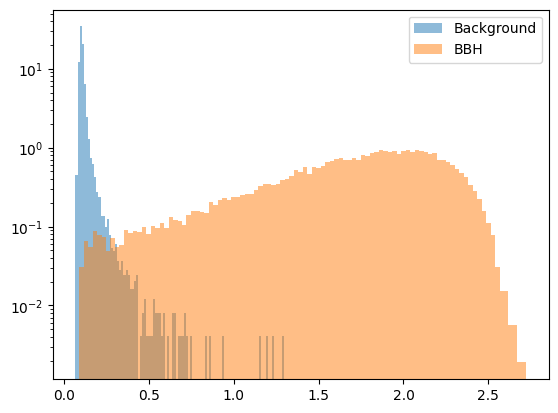

evaluation bg vs sg


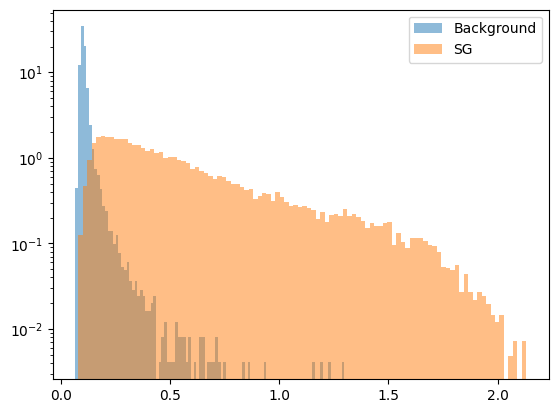

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_63.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


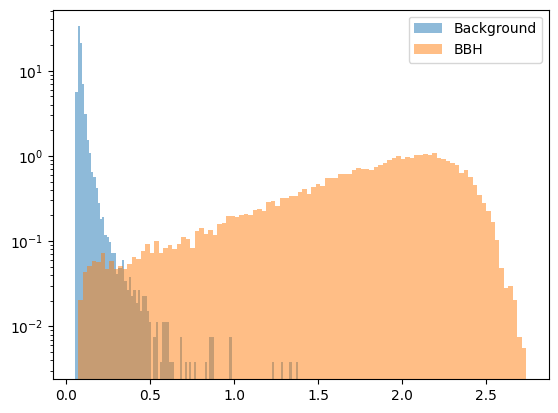

evaluation bg vs sg


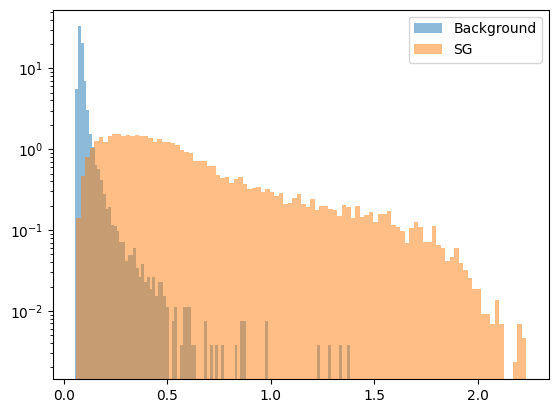

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_64.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


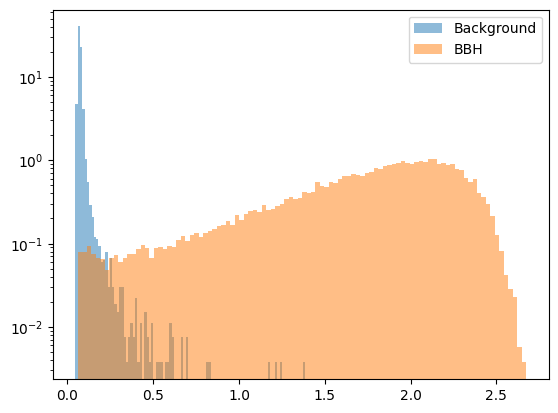

evaluation bg vs sg


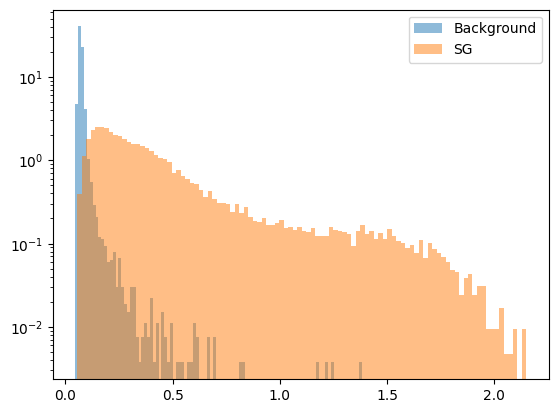

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_65.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


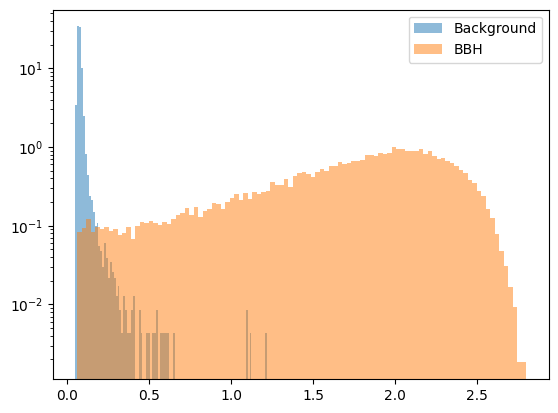

evaluation bg vs sg


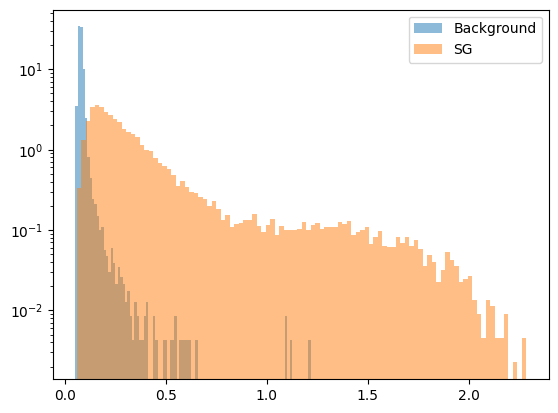

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_66.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


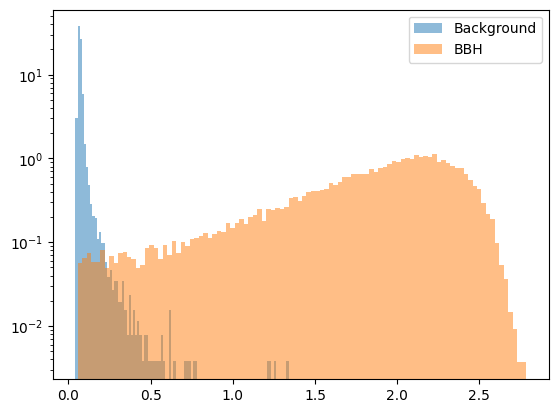

evaluation bg vs sg


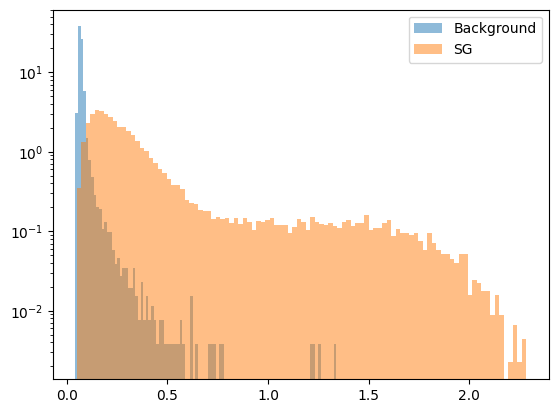

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_67.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


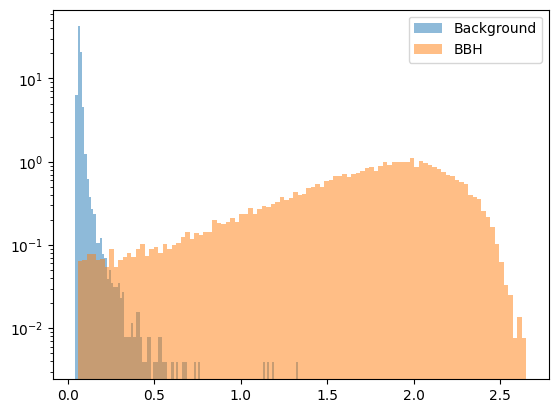

evaluation bg vs sg


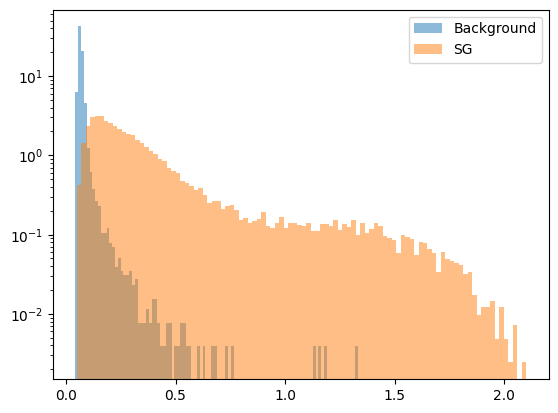

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_68.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


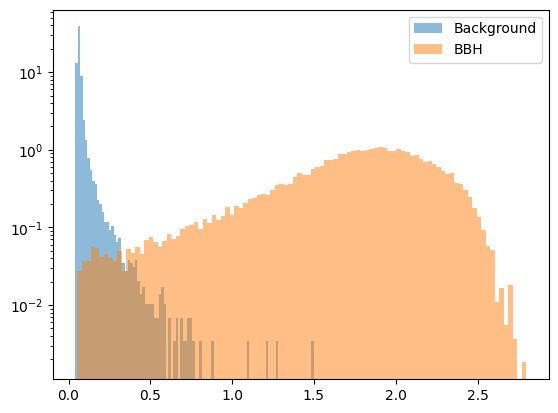

evaluation bg vs sg


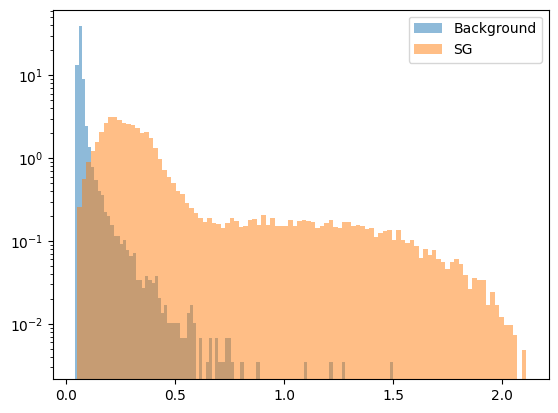

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_69.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


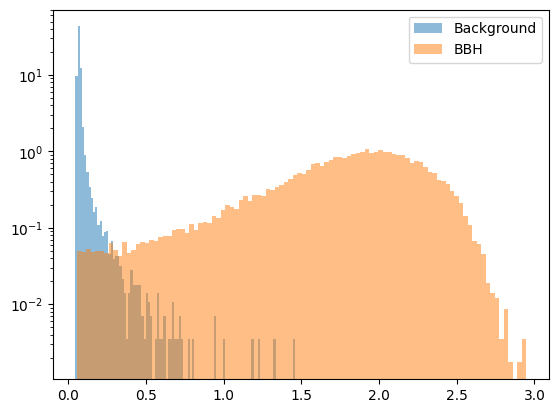

evaluation bg vs sg


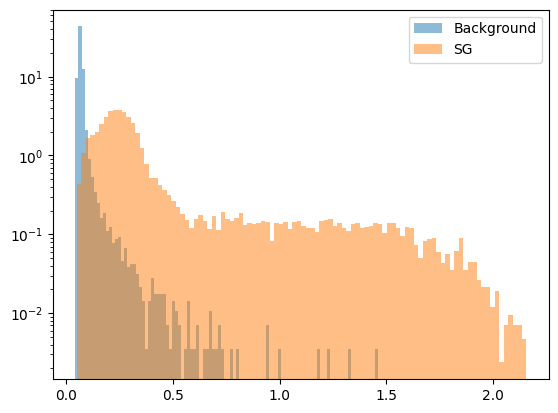

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_70.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


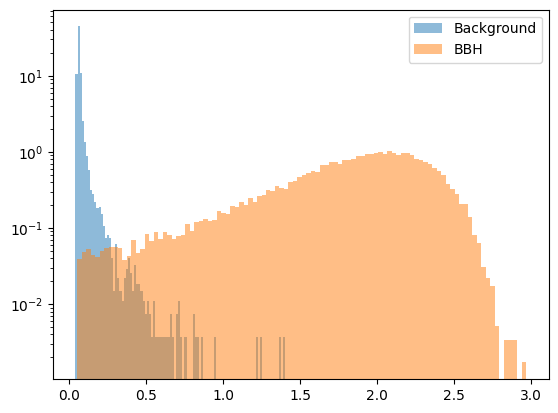

evaluation bg vs sg


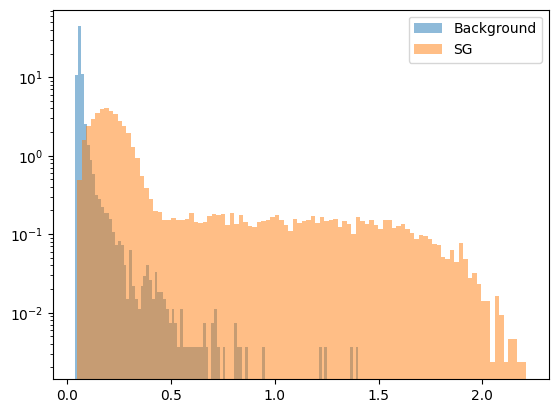

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_71.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


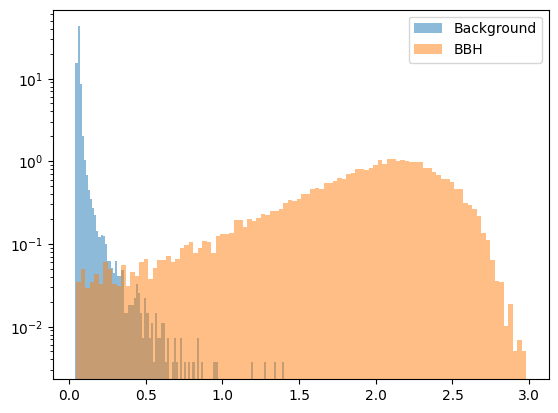

evaluation bg vs sg


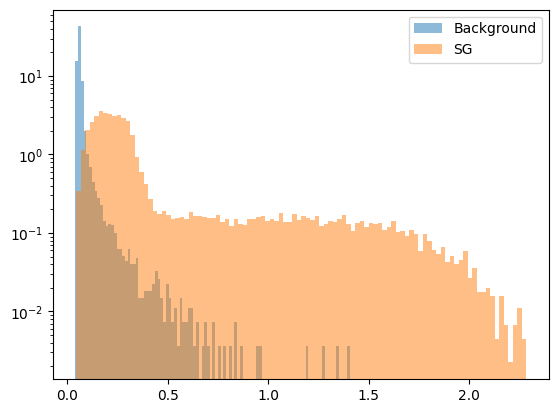

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_72.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


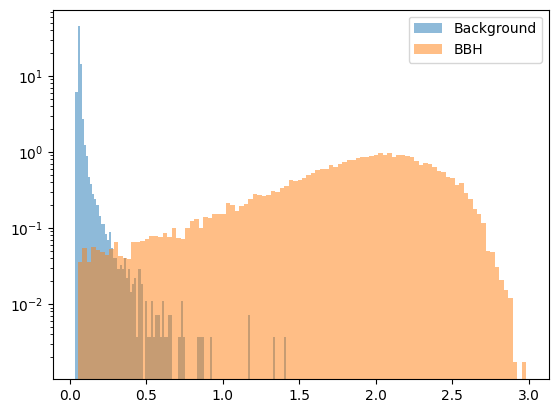

evaluation bg vs sg


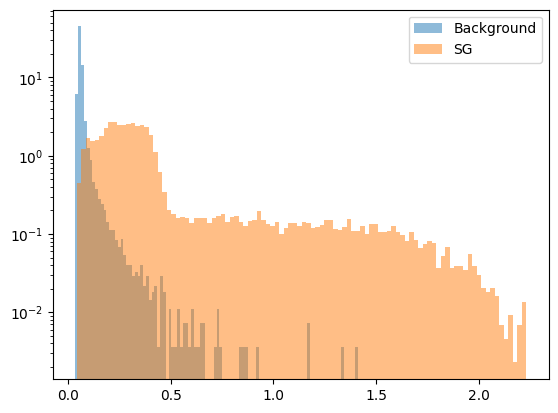

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_73.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


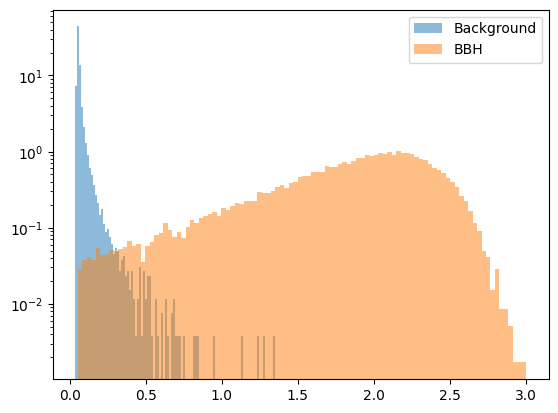

evaluation bg vs sg


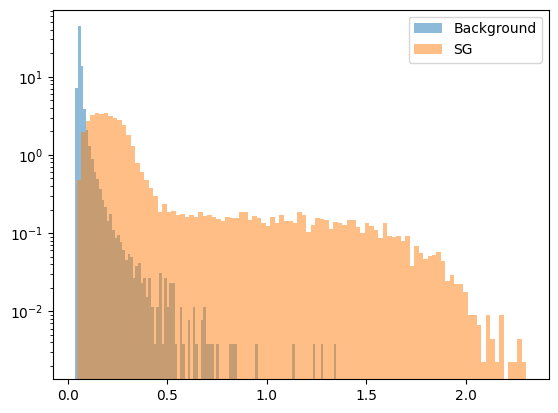

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_74.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


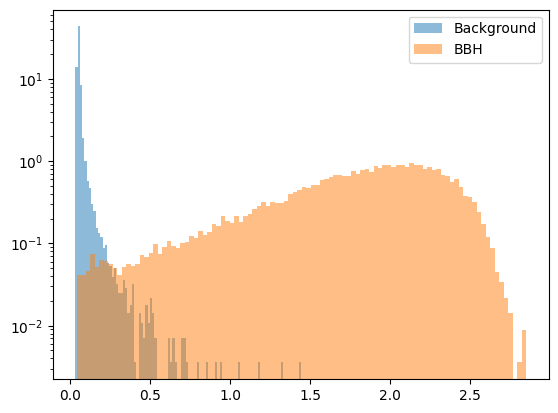

evaluation bg vs sg


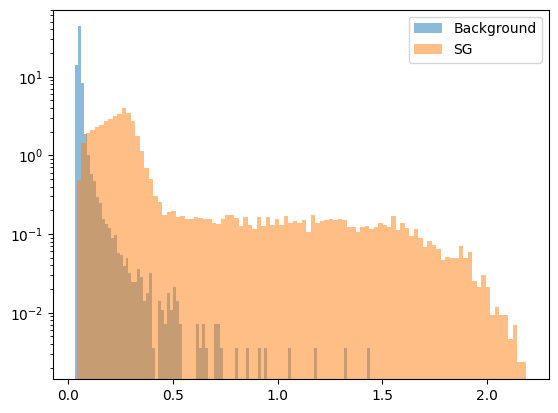

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_75.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


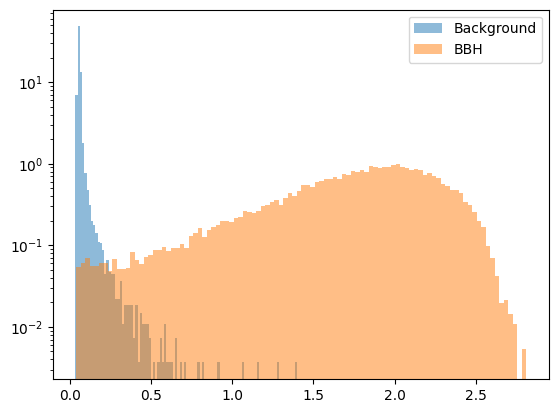

evaluation bg vs sg


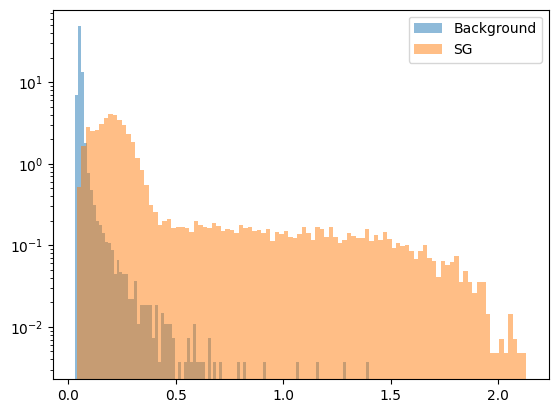

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_76.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


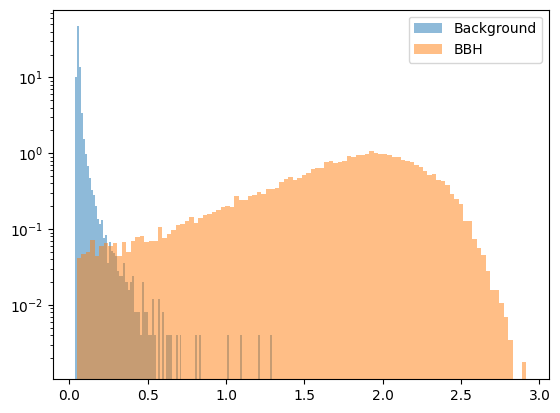

evaluation bg vs sg


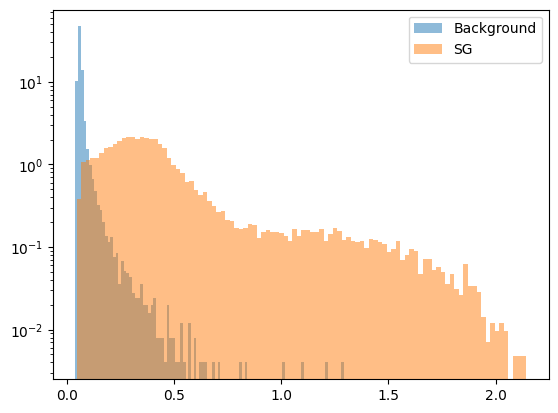

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_77.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


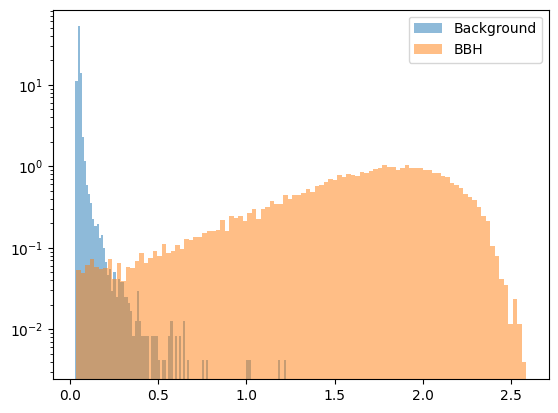

evaluation bg vs sg


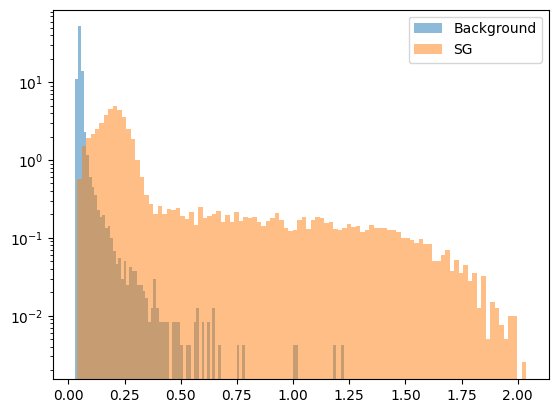

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_78.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


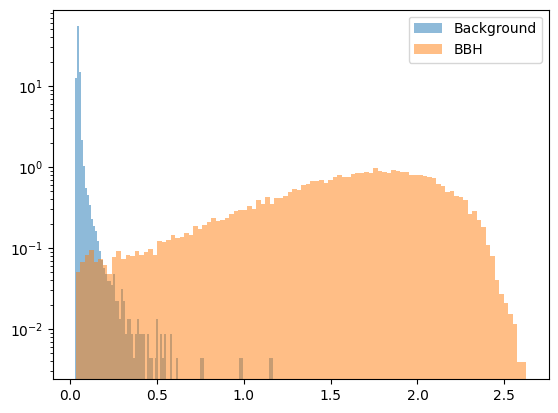

evaluation bg vs sg


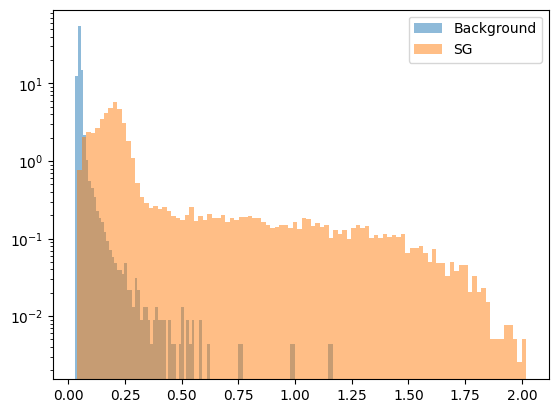

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_79.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


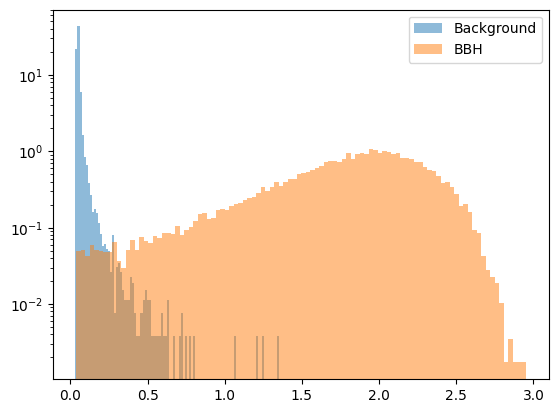

evaluation bg vs sg


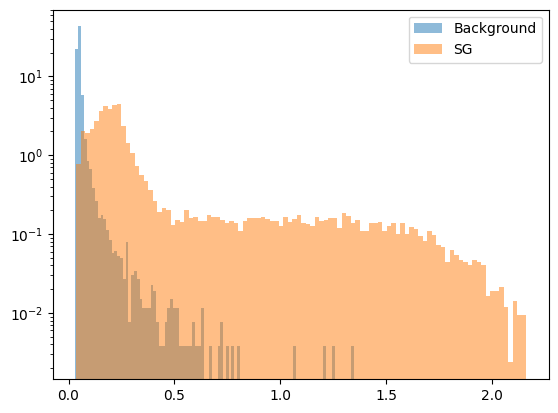

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_80.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


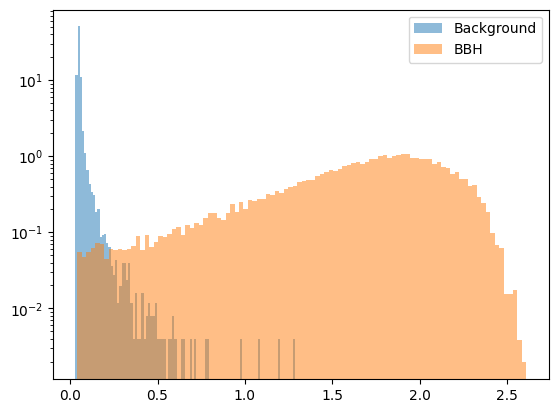

evaluation bg vs sg


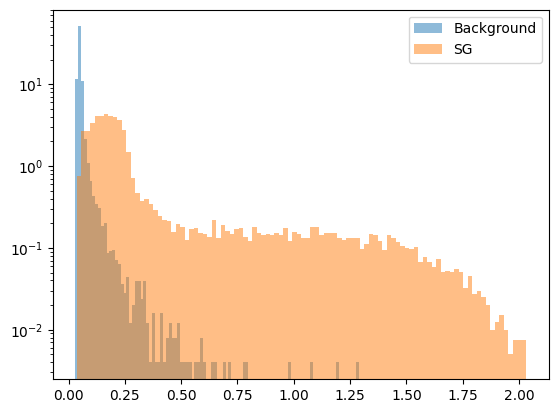

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_81.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


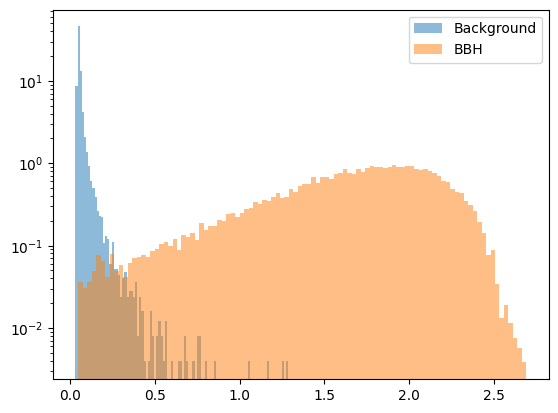

evaluation bg vs sg


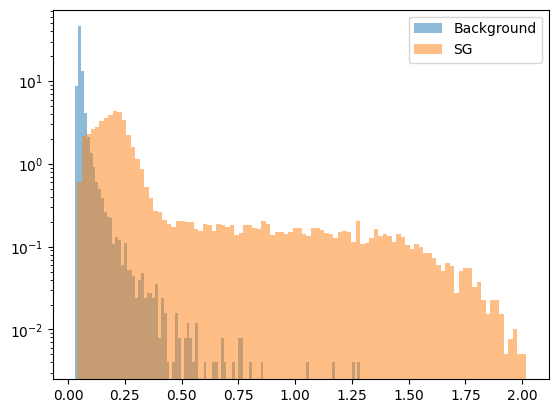

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_82.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


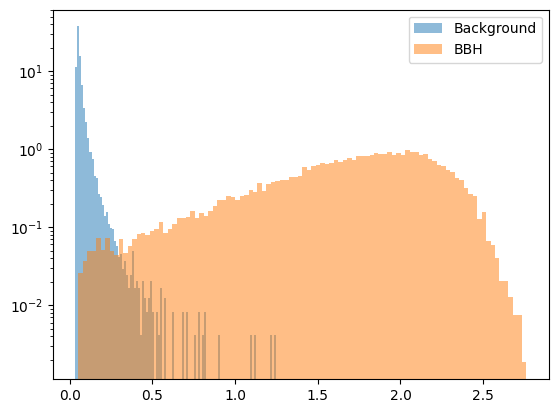

evaluation bg vs sg


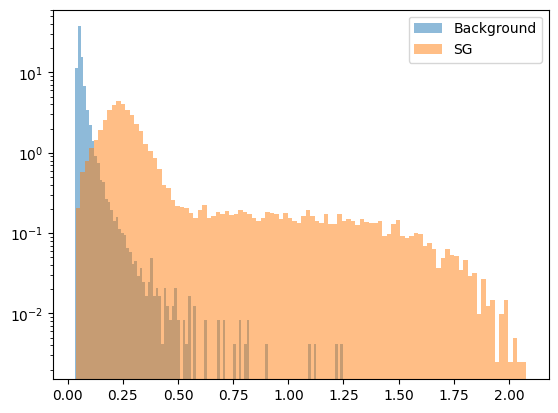

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_83.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


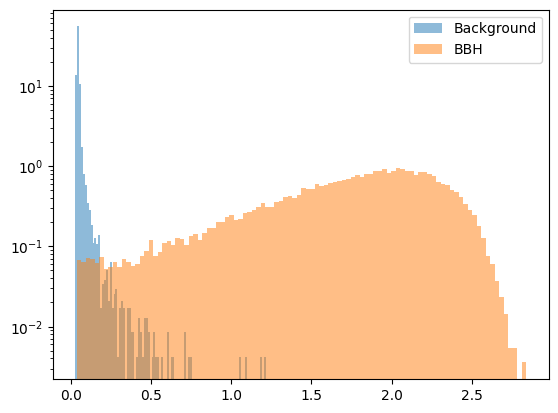

evaluation bg vs sg


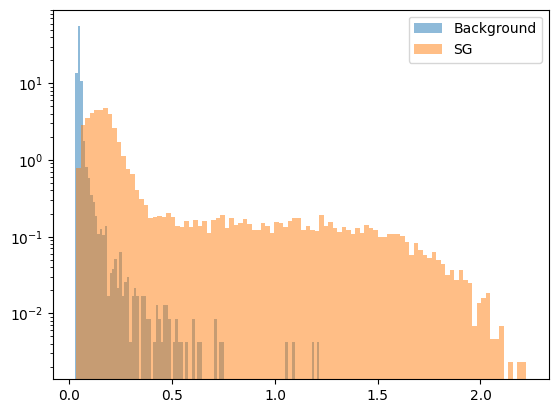

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_84.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


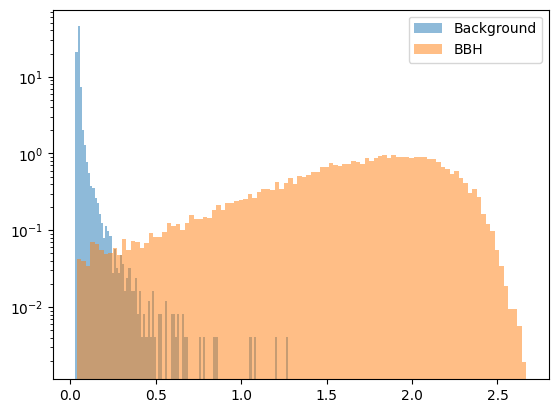

evaluation bg vs sg


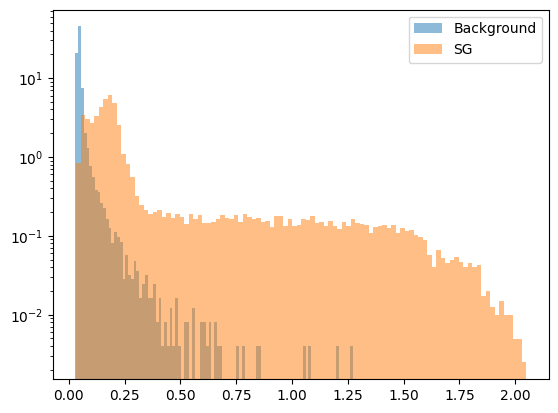

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_85.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


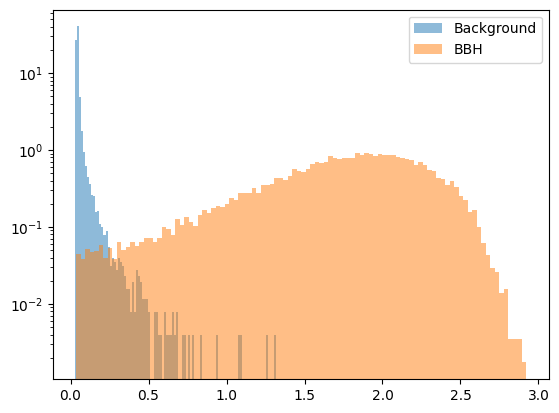

evaluation bg vs sg


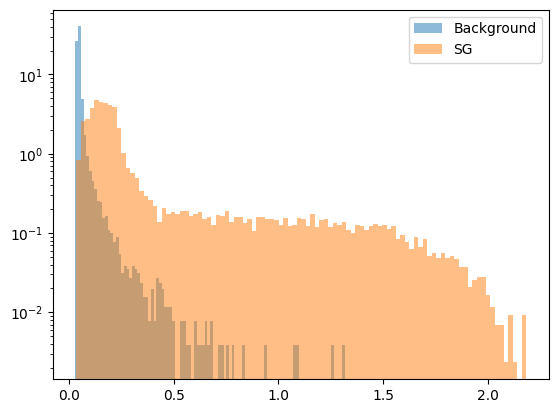

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_86.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


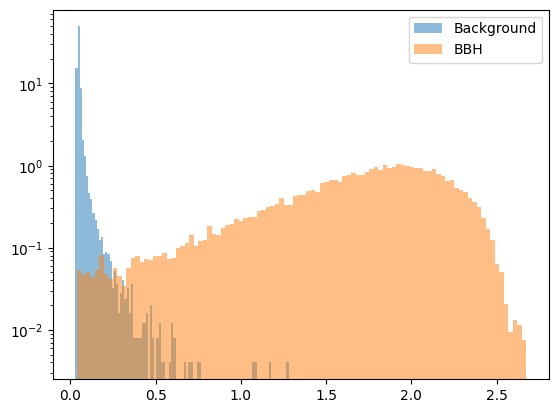

evaluation bg vs sg


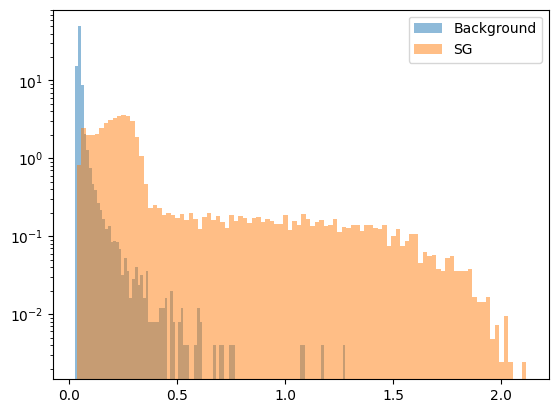

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_87.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


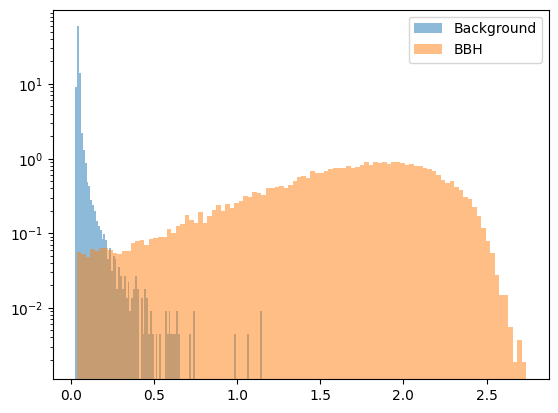

evaluation bg vs sg


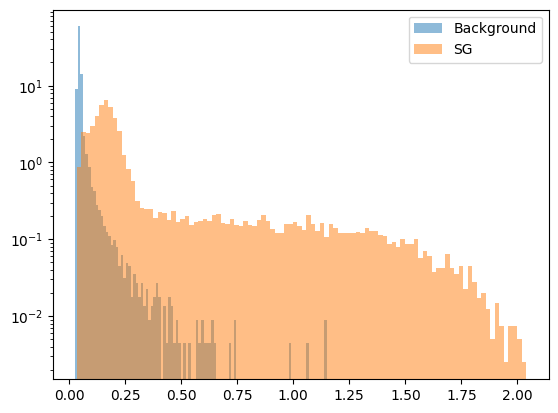

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_88.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


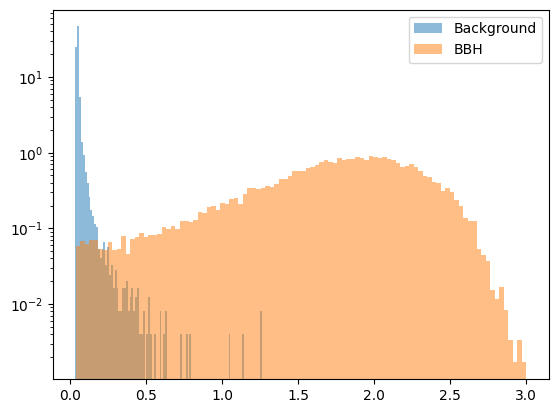

evaluation bg vs sg


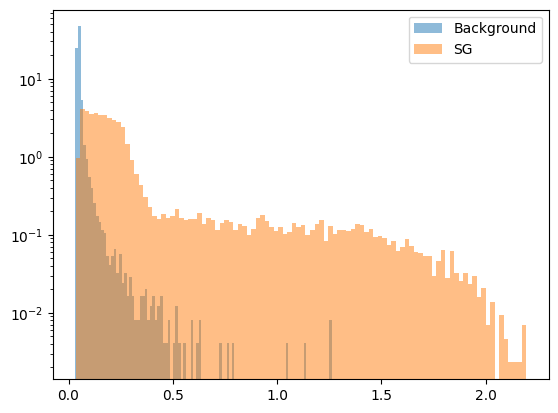

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_89.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


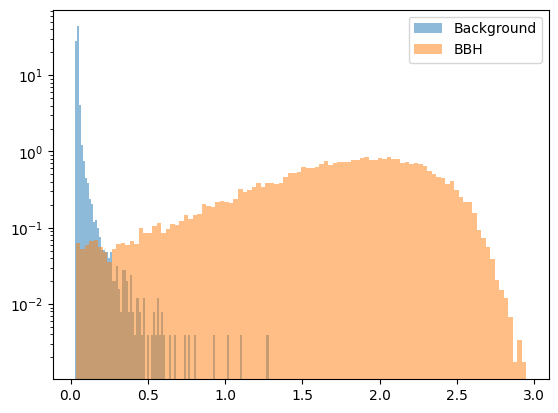

evaluation bg vs sg


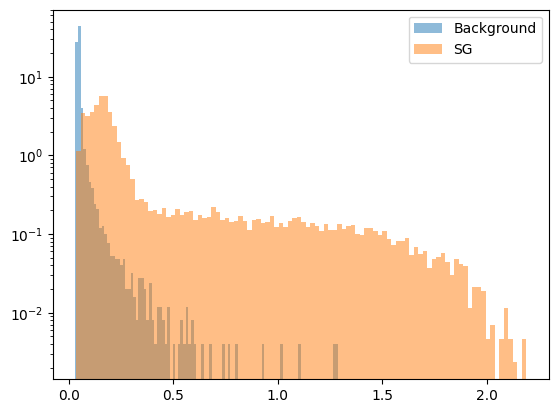

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_90.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


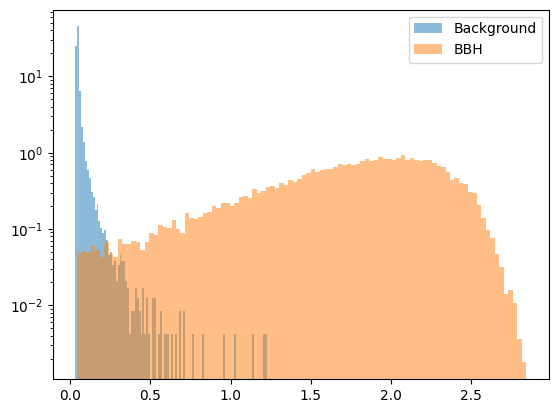

evaluation bg vs sg


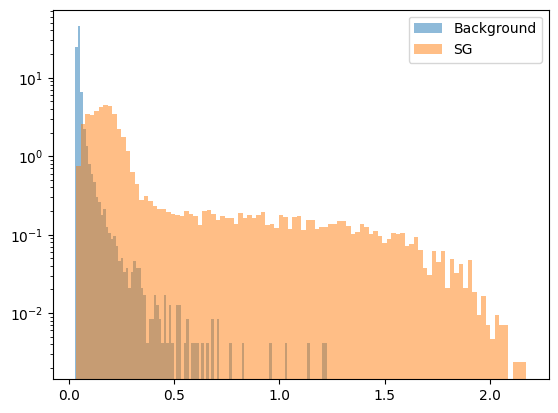

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_91.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


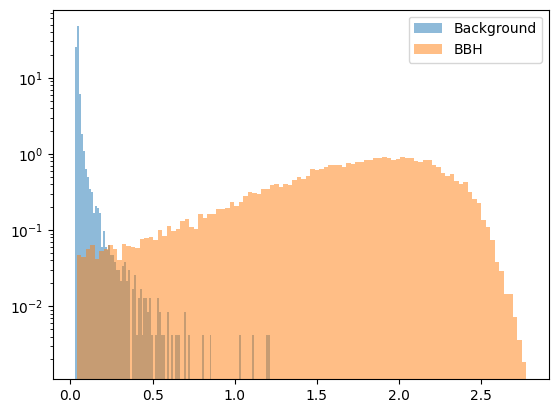

evaluation bg vs sg


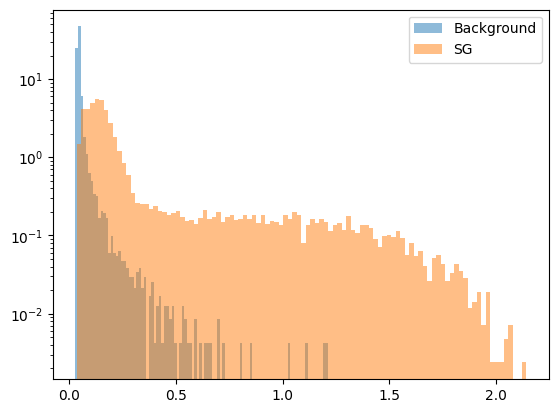

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_92.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


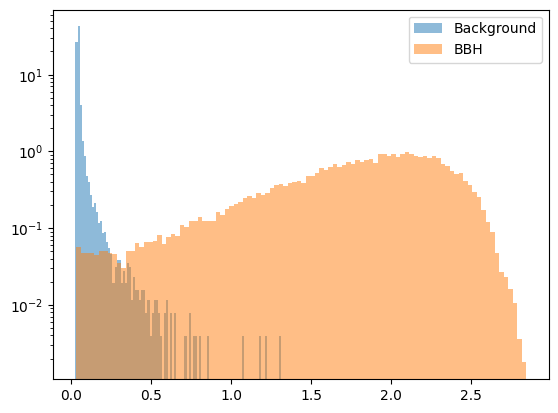

evaluation bg vs sg


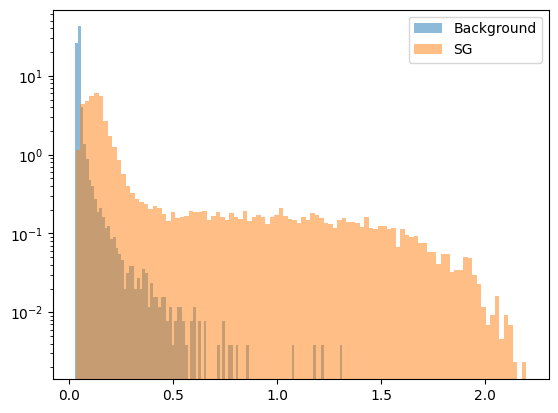

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_93.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


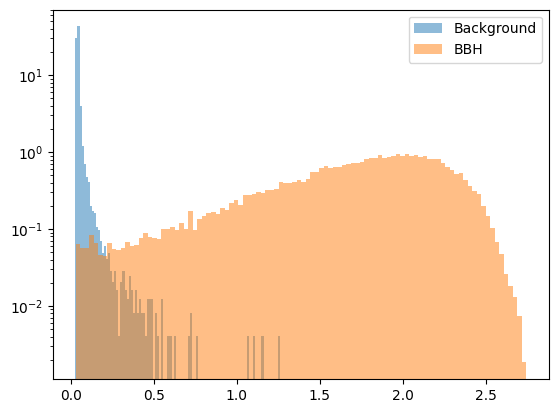

evaluation bg vs sg


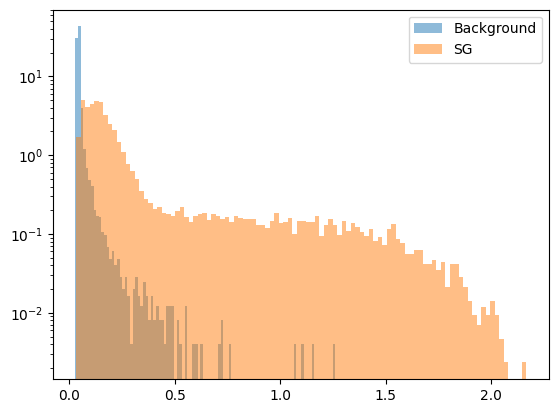

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_94.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


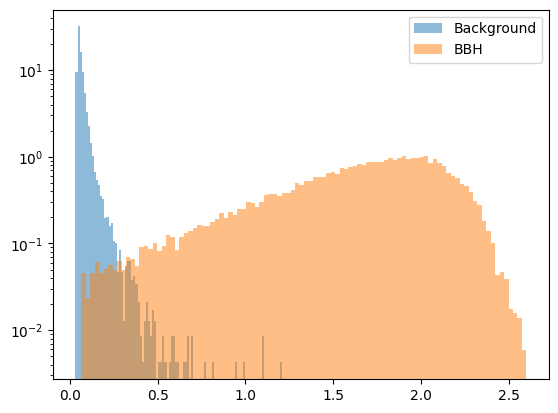

evaluation bg vs sg


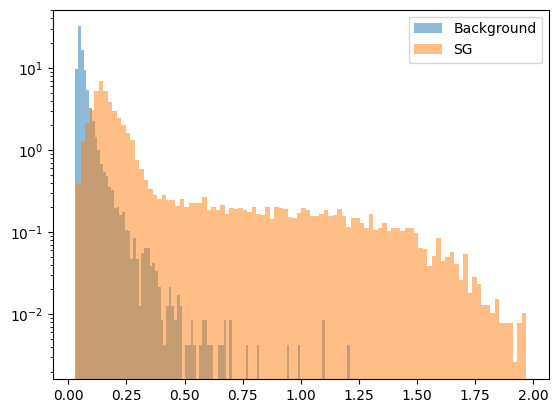

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_95.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


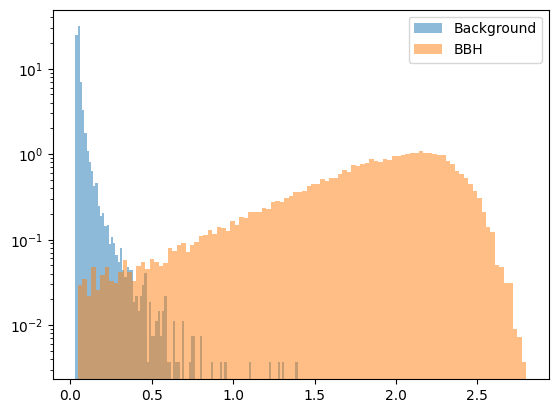

evaluation bg vs sg


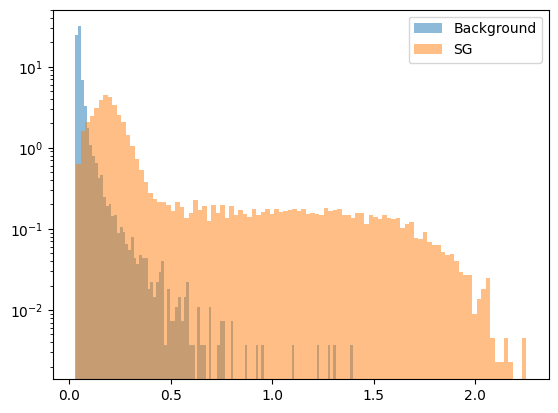

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_96.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


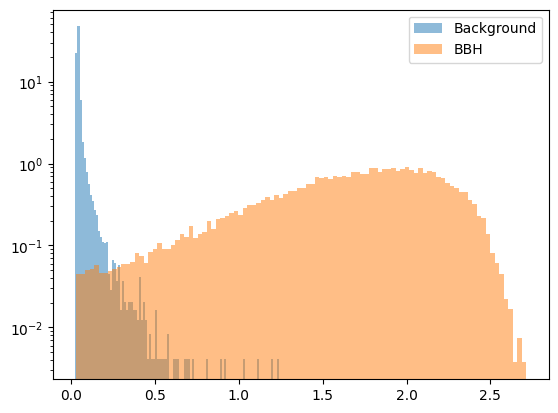

evaluation bg vs sg


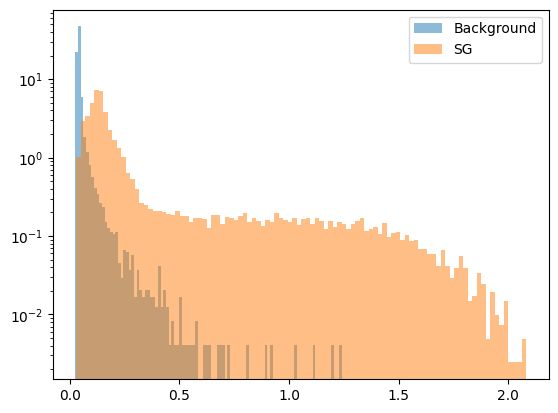

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_97.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


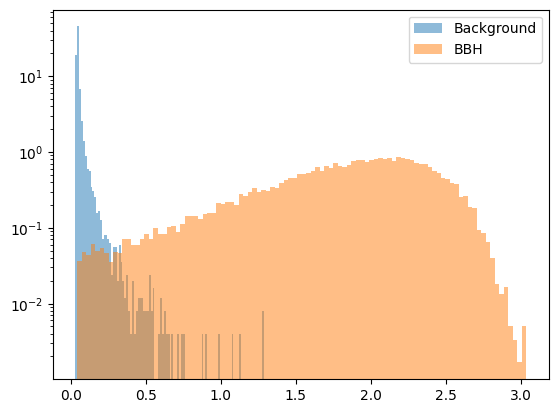

evaluation bg vs sg


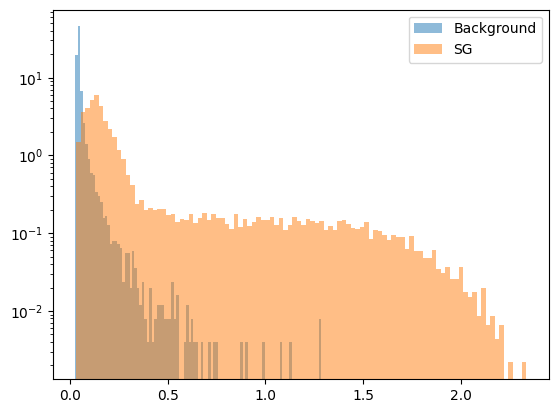

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_98.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


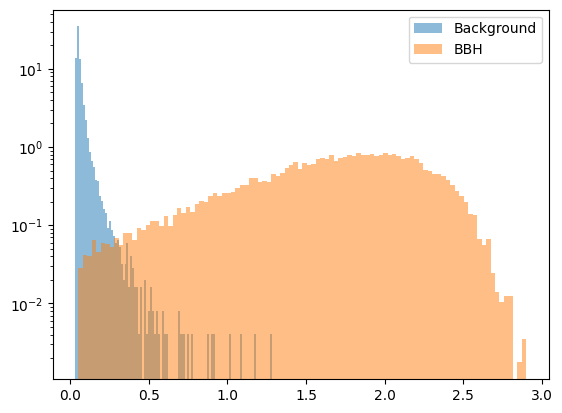

evaluation bg vs sg


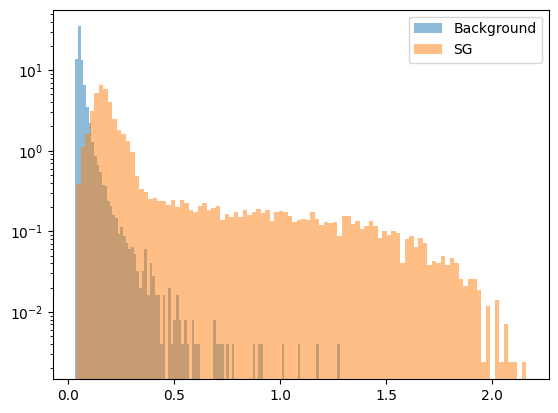

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_99.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


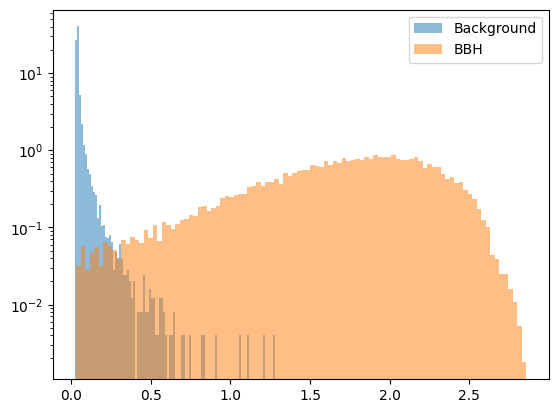

evaluation bg vs sg


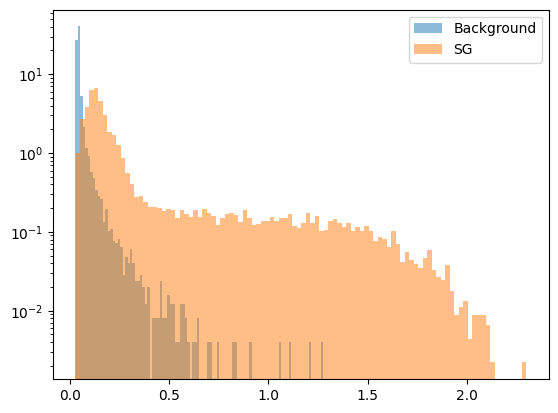

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_100.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


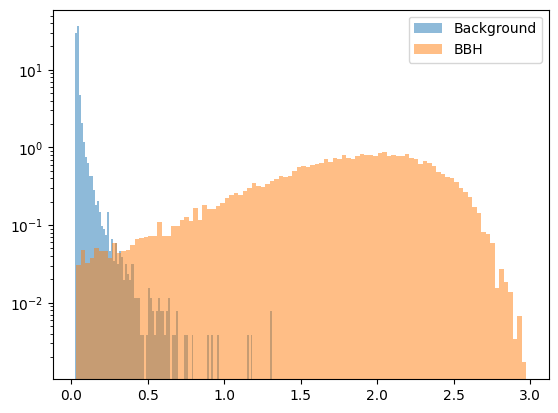

evaluation bg vs sg


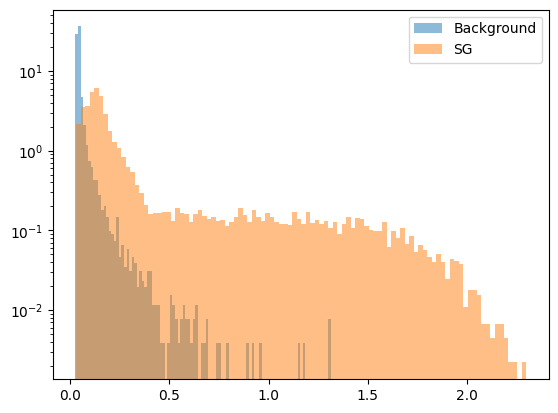

bbh 0.99945823 94
sg 0.9901407425000001 58


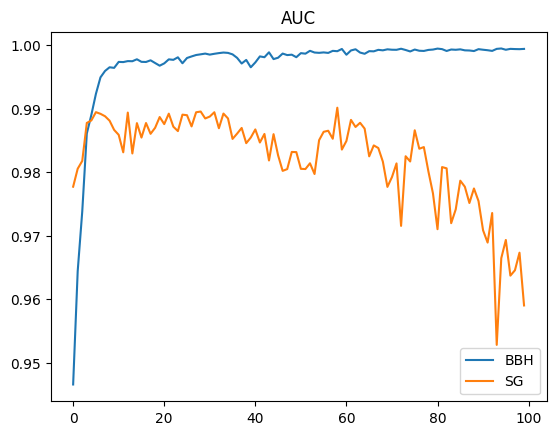

bbh 0.0001 35
sg 0.00195 3


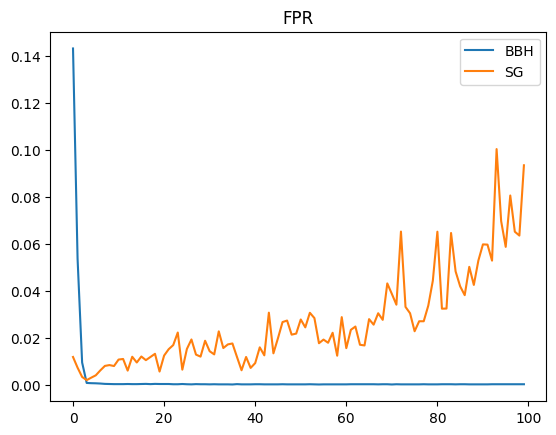

In [ ]:
# Test on autoencoder(we have background_test,bbh_test,sglf_test) for each epoch

# this is from the original condabench challenge sample code, It gives Auc_loss, and the FPR(I added it) 0.9 TPR
def make_plot_roc_curves(qcd, bsm):   #qcd is set to be zero which is bg, bsm is set to be 1 which is anomaly
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))  #create the true value
    pred_val = np.concatenate((bsm, qcd))   #concatenate the predicted value
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)  #find the fpr, tpr, and threshold
    idx = np.argmin(np.abs(tpr_loss - 0.90))    #nearest value's index at 0.9 TPR
    desired_fpr = fpr_loss[idx]    #FPR at 0.9 TPR
    desired_threshold = threshold_loss[idx]

    auc_loss = auc(fpr_loss, tpr_loss)
    qcd[::-1].sort()
    # plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
    #     linewidth=1.5)
    # plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    return auc_loss, desired_fpr

# the eval function evaluate bg vs bbh and bg vs sg, x_test meant to be the input of background_test, bbh_pretest meant to be bbh_test, sglf_pretest meant to be sglf_test
# it then gives the auc_loss, desired fpr for both comparisons. Also plot the graph for both comparisons ( bg vs bbh, bg vs sg )
def eval(model,x_test,bbh_pretest,sglf_pretest):
    background_test = model.predict(x_test)['autoencoder_output']
    bbh_test = model.predict(bbh_pretest)['autoencoder_output']
    sglf_test = model.predict(sglf_pretest)['autoencoder_output']
    mse_background = np.mean((background_test - x_test)**2, axis=(1,2))
    mse_bbh = np.mean((bbh_test - bbh_pretest)**2, axis=(1,2))
    mse_sg = np.mean((sglf_test - sglf_pretest)**2, axis=(1,2))
    print('evaluating bg vs bbh')
    BBH_AUC, desired_fpr_bbh = make_plot_roc_curves(mse_background, mse_bbh)
    plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_bbh, density=True, bins=100, alpha=0.5, label='BBH')
    plt.semilogy()
    plt.legend()
    plt.show()
    print('evaluation bg vs sg')
    SG_AUC, desired_fpr_sg = make_plot_roc_curves(mse_background, mse_sg)
    plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='SG')
    plt.semilogy()
    plt.legend()
    plt.show()
    return BBH_AUC, SG_AUC, desired_fpr_bbh, desired_fpr_sg

# glob all the saved model
model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_*.keras")
# sort it so it wont start at a random epoch
model_files = sorted(model_files, key=lambda x: int(re.search(r"model3_epoch_(\d+).keras", x).group(1)))
bbh_auc=[]
sg_auc=[]
fpr_bbh=[]
fpr_sg=[]

#get the auc and fpr at each epochs
for model_file in model_files:
    print(f"Evaluating model: {model_file}")
    model = load_model(model_file, custom_objects={"masked_mse_loss": masked_mse_loss})
    BBH_AUC, SG_AUC, desired_fpr_bbh, desired_fpr_sg = eval(model,background_test, bbh_test,sglf_test)
    bbh_auc.append(BBH_AUC)
    sg_auc.append(SG_AUC)
    fpr_bbh.append(desired_fpr_bbh)
    fpr_sg.append(desired_fpr_sg)

#plot the trend of auc and fpr
plt.figure()
plt.plot(bbh_auc, label='BBH')
plt.plot(sg_auc, label='SG')
print('bbh',max(bbh_auc),bbh_auc.index(max(bbh_auc)))
print('sg',max(sg_auc),sg_auc.index(max(sg_auc)))
plt.title('AUC')
plt.legend()
plt.show()

plt.figure()
plt.plot(fpr_bbh, label='BBH')
plt.plot(fpr_sg, label='SG')
print('bbh',min(fpr_bbh),fpr_bbh.index(min(fpr_bbh)))
print('sg',min(fpr_sg),fpr_sg.index(min(fpr_sg)))
plt.title('FPR')
plt.legend()
plt.show()

In [ ]:
#Because with a better auc in bbh doesnt mean having a better auc is sg. therefore I am trying to find which one is the optimal one
# , so I printed out the pair value for both high bbh auc one and high sg auc one. Same for fpr, except we need it to be lowest.
# I also added them up see the optimal sum one.

print(bbh_auc[sg_auc.index(max(sg_auc))],sg_auc[sg_auc.index(max(sg_auc))])
print(bbh_auc[bbh_auc.index(max(bbh_auc))],sg_auc[bbh_auc.index(max(bbh_auc))])
print(fpr_bbh[fpr_sg.index(min(fpr_sg))],fpr_sg[fpr_sg.index(min(fpr_sg))])
print(fpr_bbh[fpr_bbh.index(min(fpr_bbh))],fpr_sg[fpr_bbh.index(min(fpr_bbh))])
auc = np.array(bbh_auc)+np.array(sg_auc)
fpr = np.array(fpr_bbh)+np.array(fpr_sg)
auc_max= np.argmax(auc)
fpr_min = np.argmin(fpr)

# in simple, this line gives you the optimal bbh and fpr among all the training epochs,
print(bbh_auc[auc_max],sg_auc[auc_max])
print(fpr_bbh[fpr_min],fpr_sg[fpr_min])

0.9990307350000001 0.9901407425000001
0.99945823 0.9664722175
0.00075 0.00195
0.0001 0.01755
0.9990307350000001 0.9901407425000001
0.00075 0.00195


# Testing!

In [ ]:
# Load test data and normalize them
data = np.load('ligo_bb_final.npz')
test_data = data['data']
stds = np.std(test_data, axis=-1)[:, :, np.newaxis]
test_data = test_data/stds
test_data = np.swapaxes(test_data, 1, 2)
# add correlation dimension
test_data = add_correlation_channel(test_data)

data_label = data['ids']
indices1 = np.where(data_label == 1)[0]
indices0 = np.where(data_label == 0)[0]
background_test_data = test_data[indices0]
signal_test_data = test_data[indices1]

In [ ]:
# Load model
model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_*.keras")
model_files = sorted(model_files, key=lambda x: int(re.search(r"model3_epoch_(\d+).keras", x).group(1)))

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_01.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


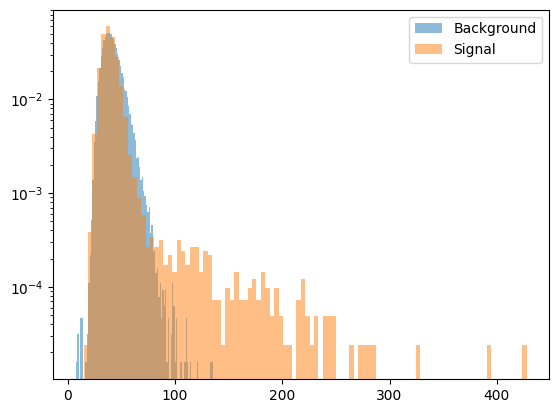

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_02.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


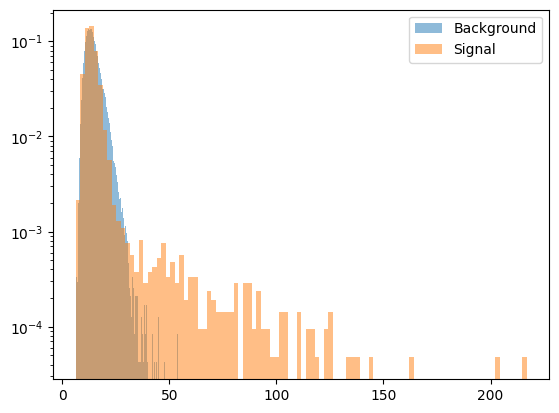

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_03.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


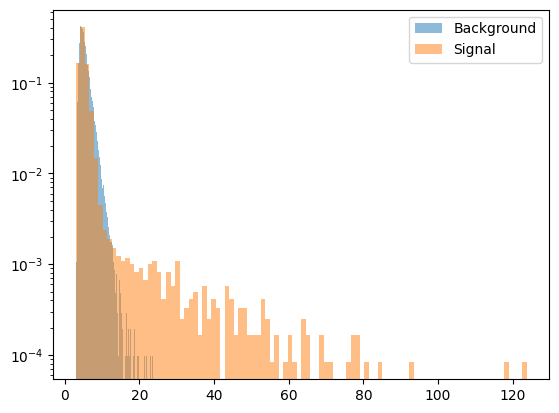

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_04.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


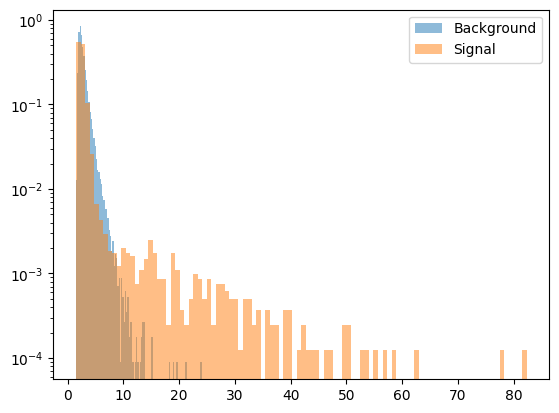

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_05.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


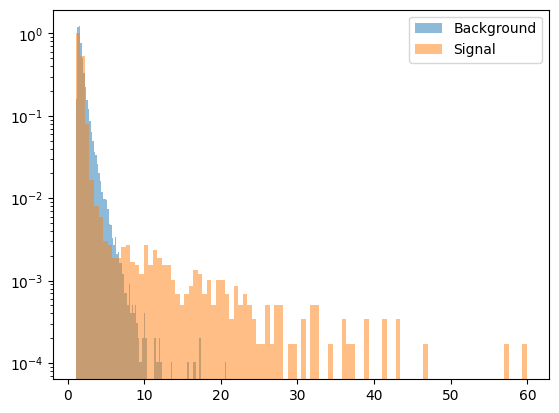

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_06.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


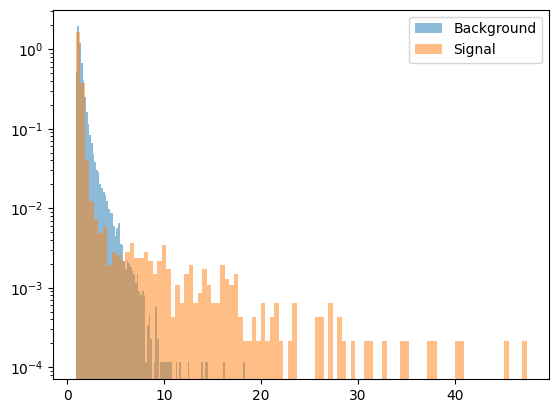

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_07.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


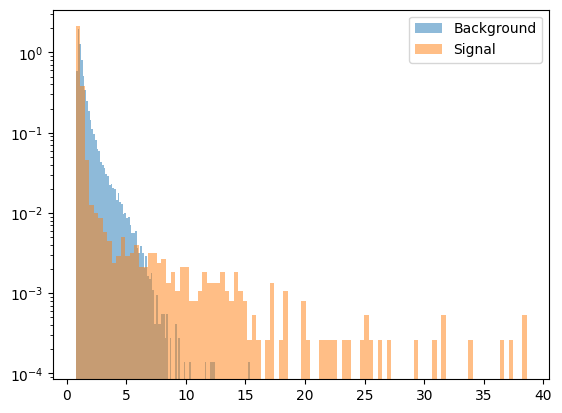

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_08.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


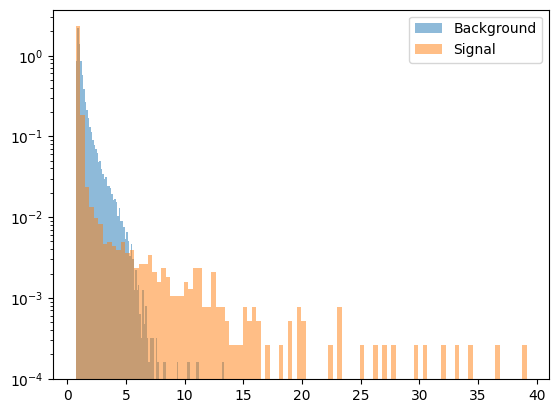

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_09.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


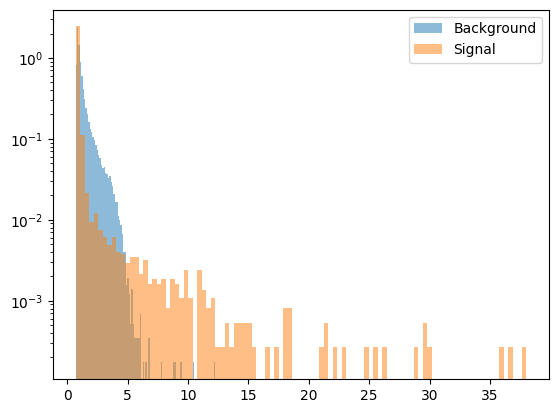

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_10.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


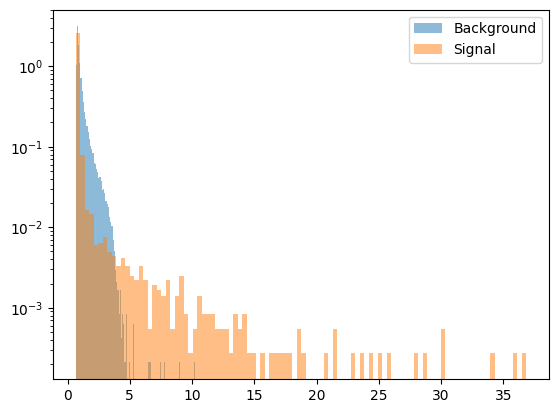

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_11.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


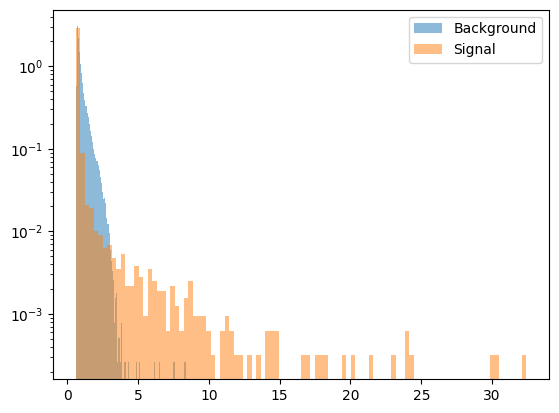

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_12.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


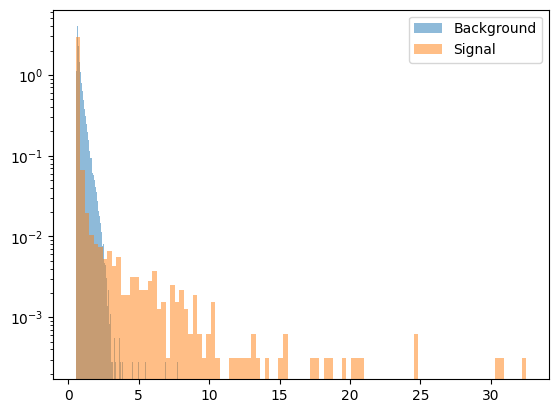

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_13.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


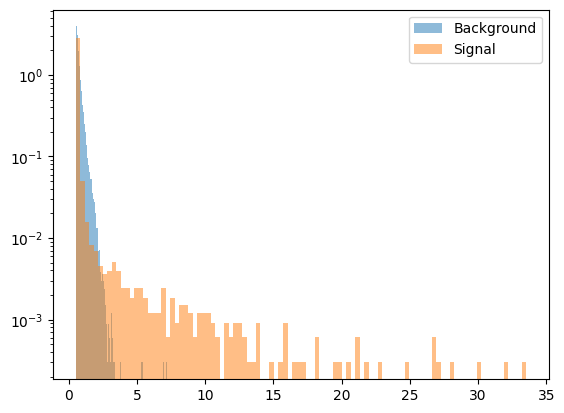

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_14.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


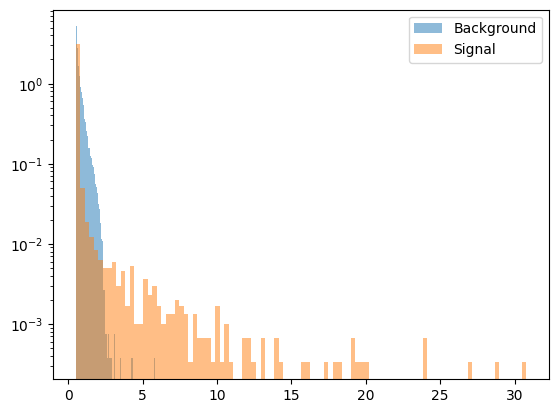

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_15.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


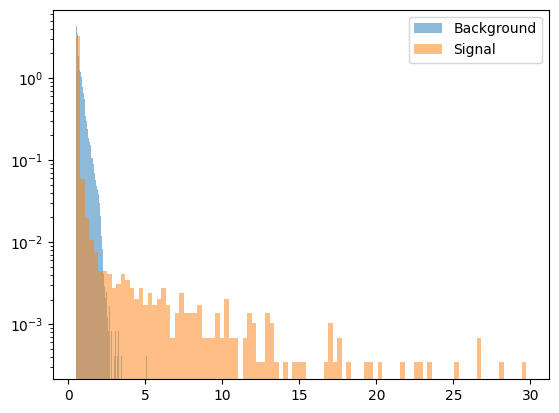

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_16.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


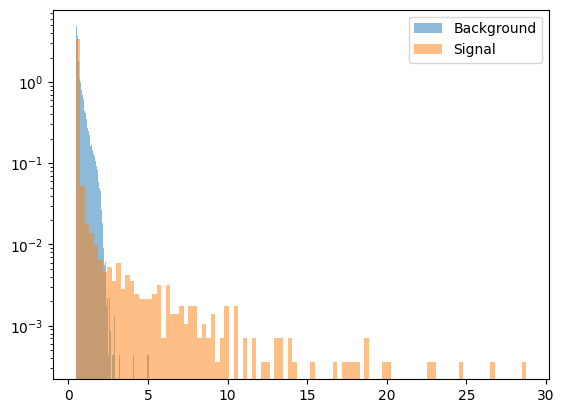

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_17.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


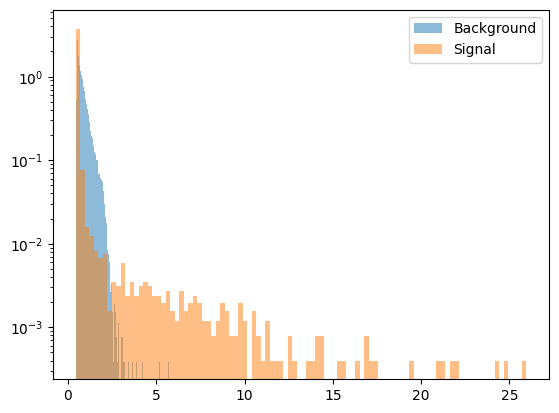

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_18.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


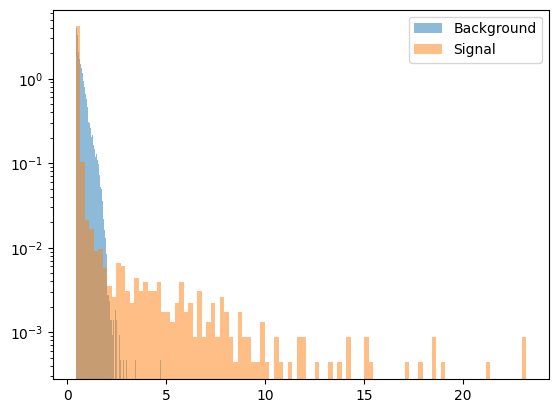

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_19.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


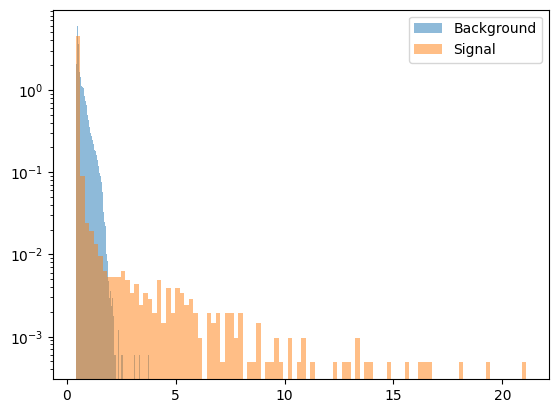

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_20.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


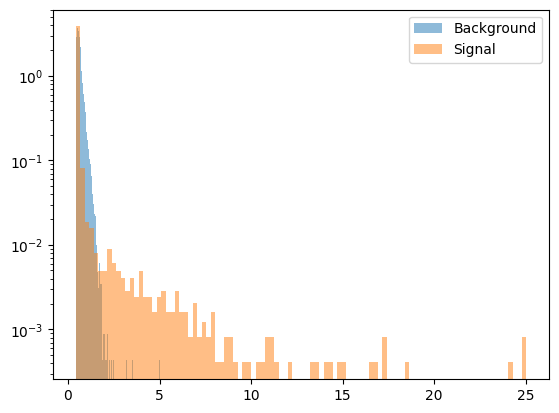

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_21.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


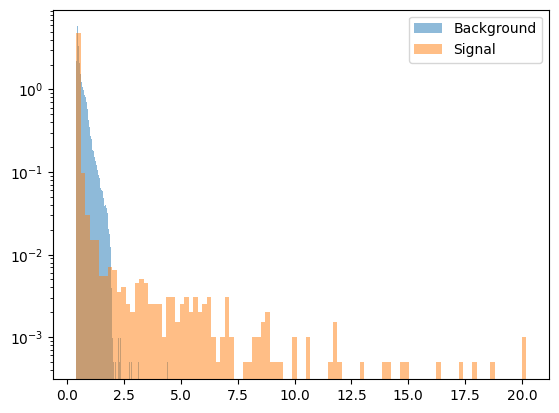

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_22.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


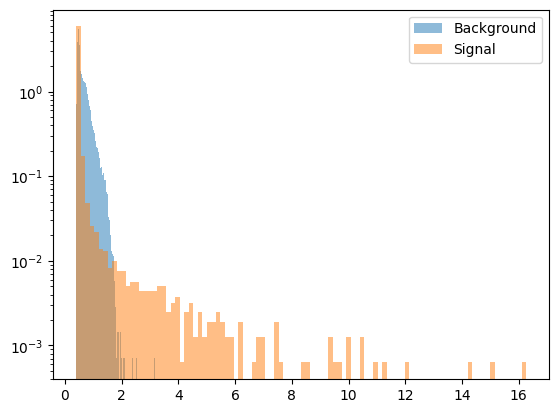

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_23.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


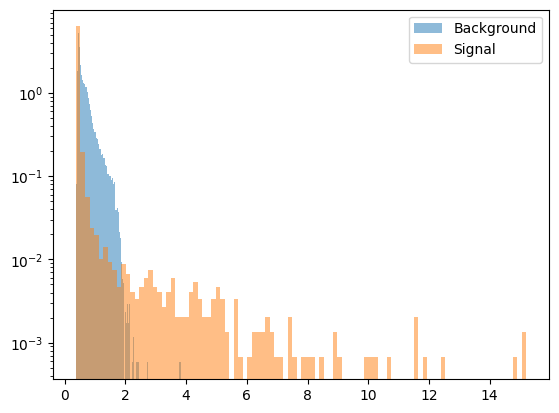

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_24.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


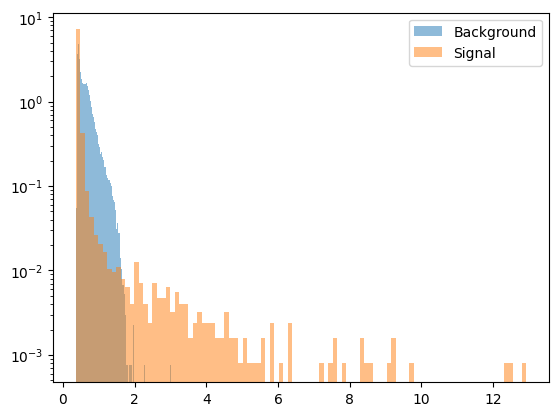

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_25.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


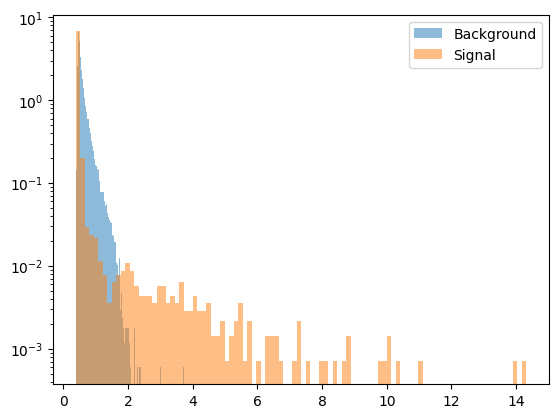

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_26.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


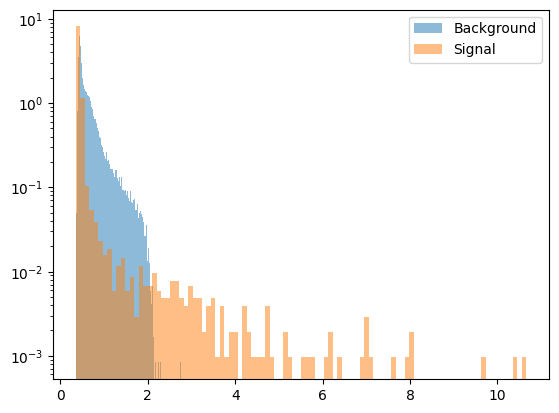

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_27.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


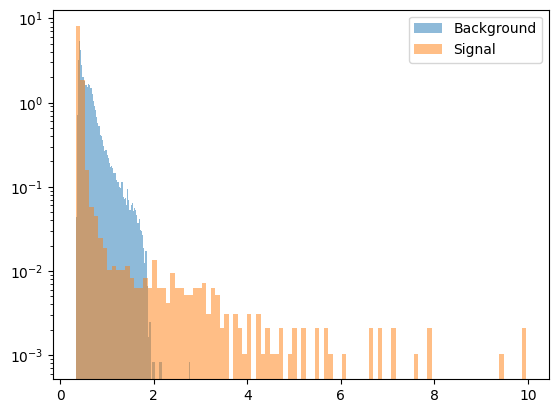

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_28.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


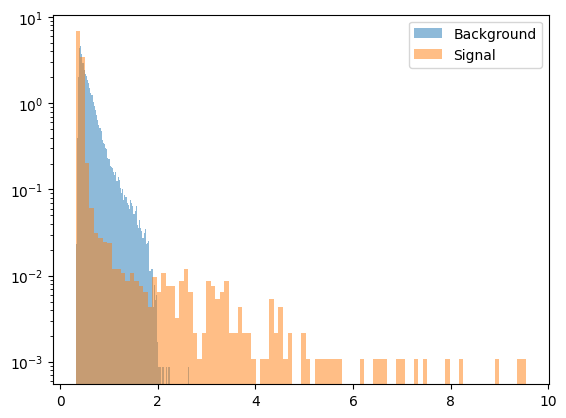

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_29.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


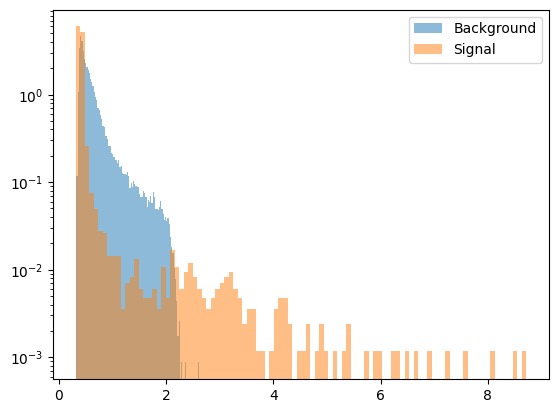

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_30.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


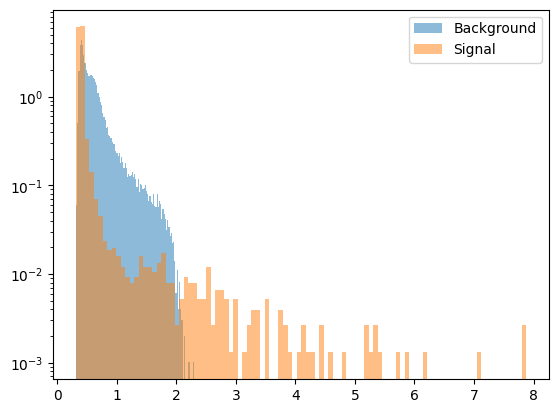

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_31.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


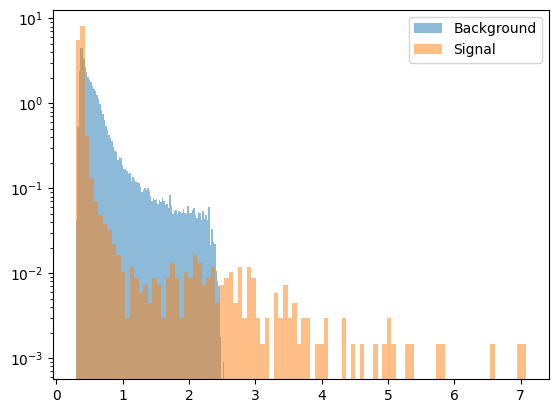

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_32.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


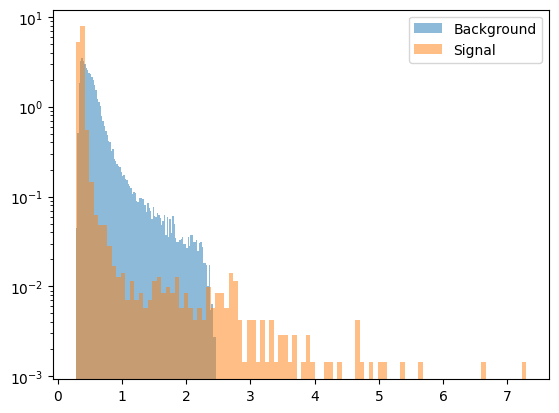

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_33.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


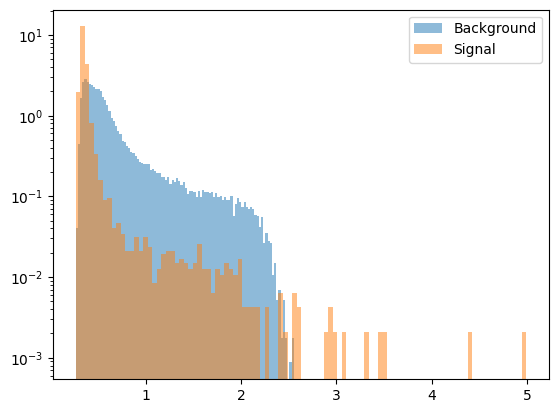

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_34.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


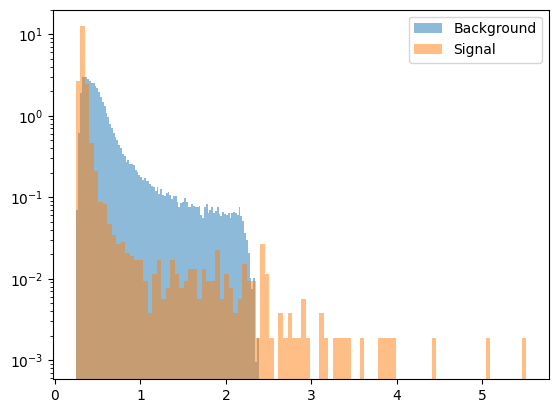

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_35.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


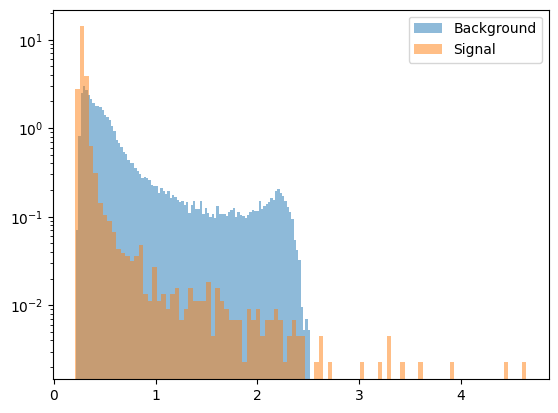

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_36.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


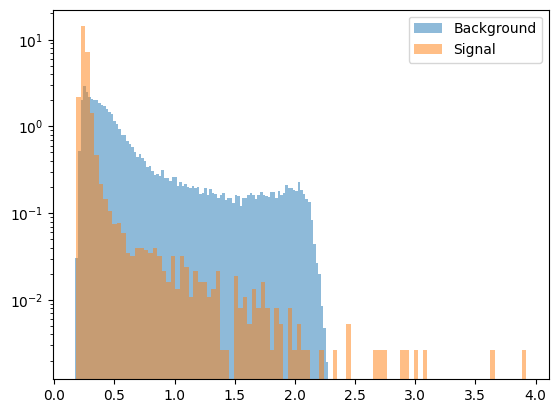

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_37.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


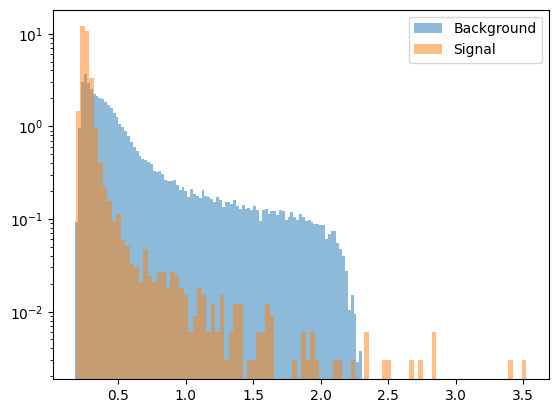

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_38.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


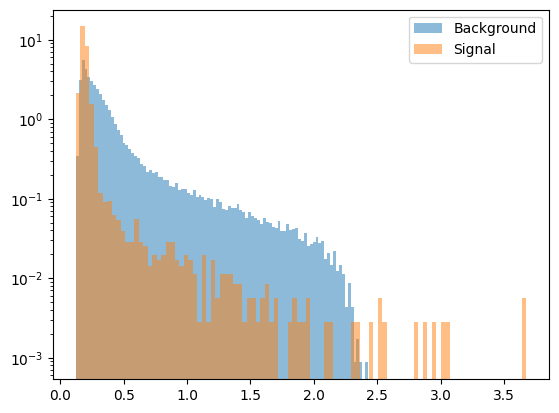

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_39.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


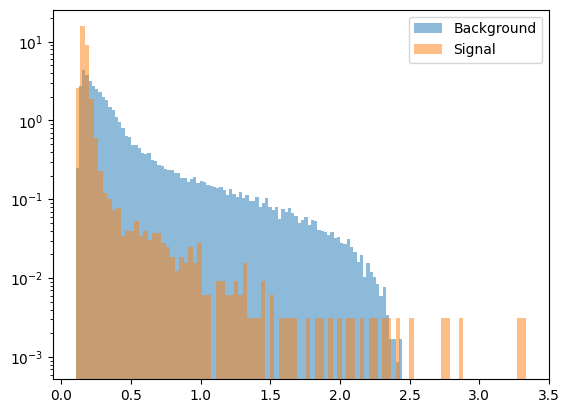

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_40.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


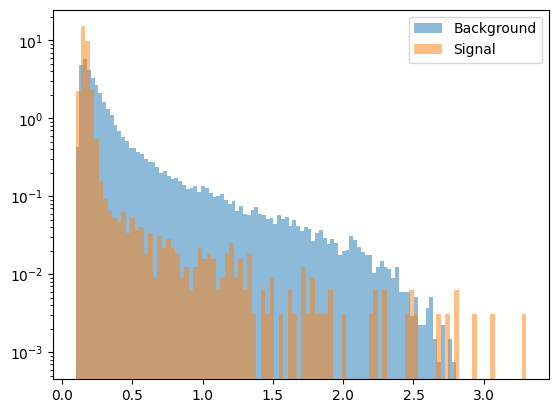

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_41.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


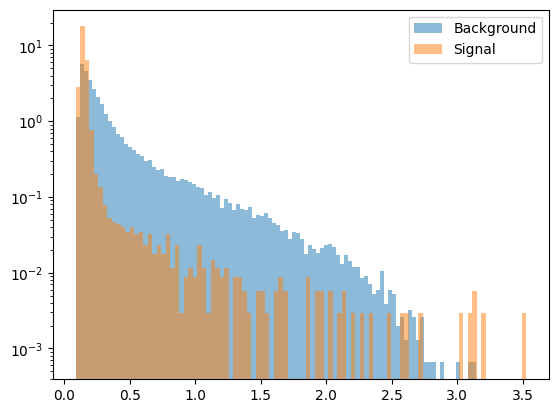

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_42.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


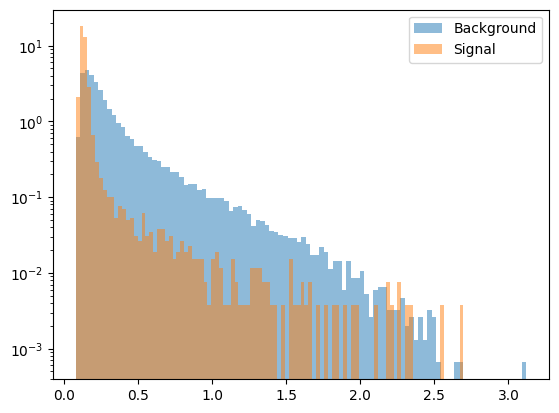

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_43.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


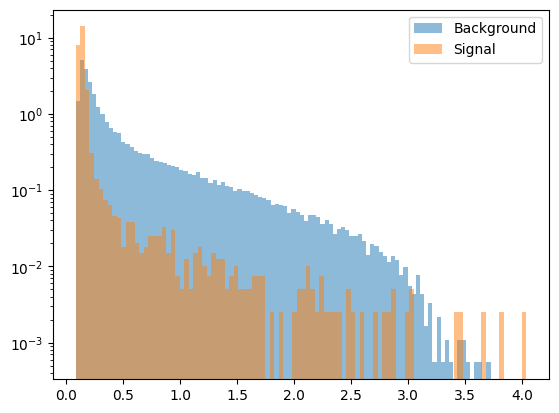

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_44.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


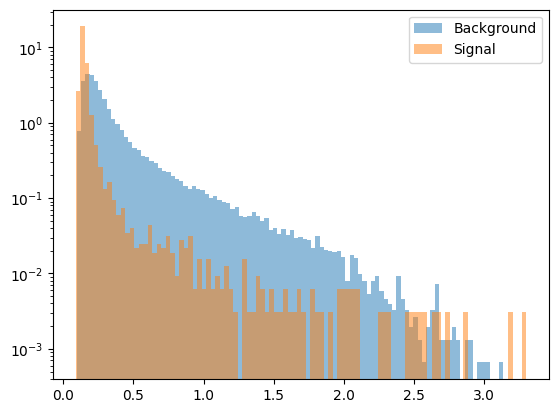

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_45.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


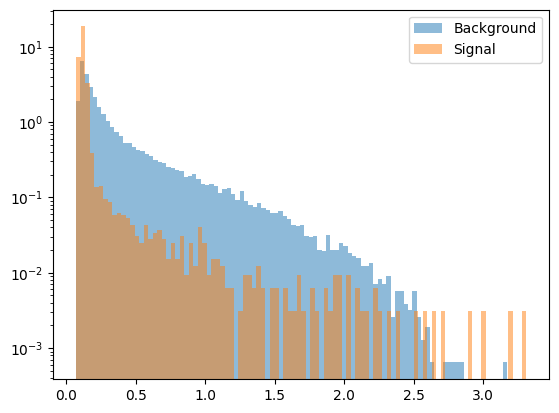

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_46.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


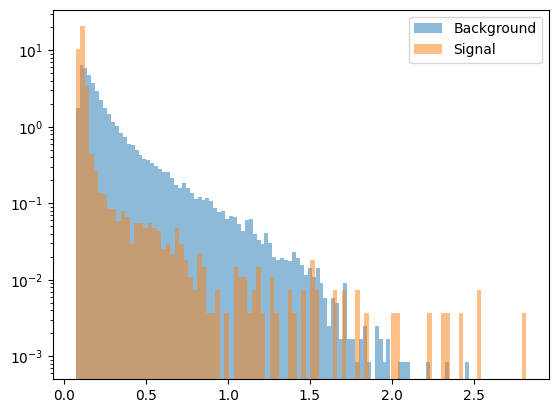

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_47.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


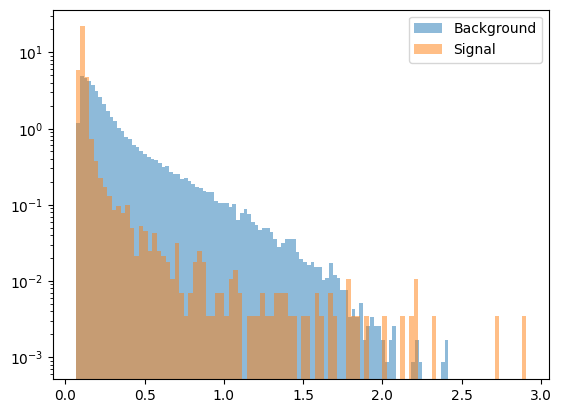

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_48.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


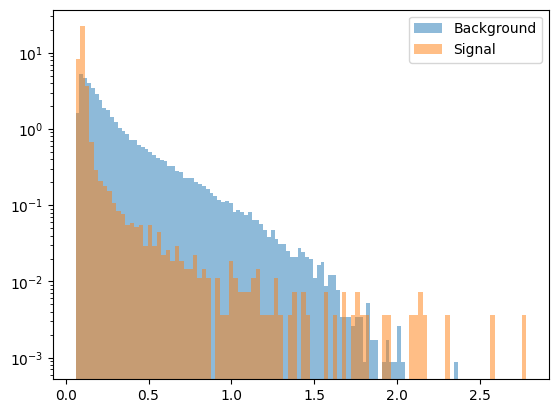

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_49.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


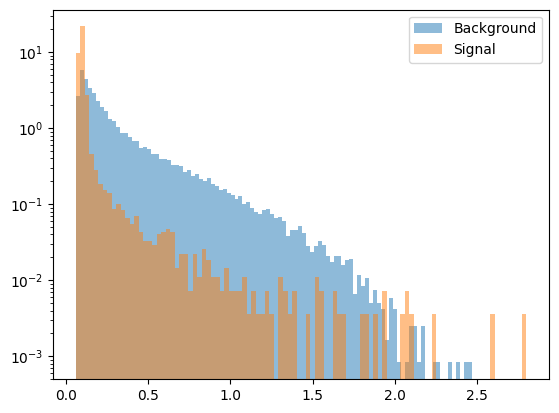

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_50.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


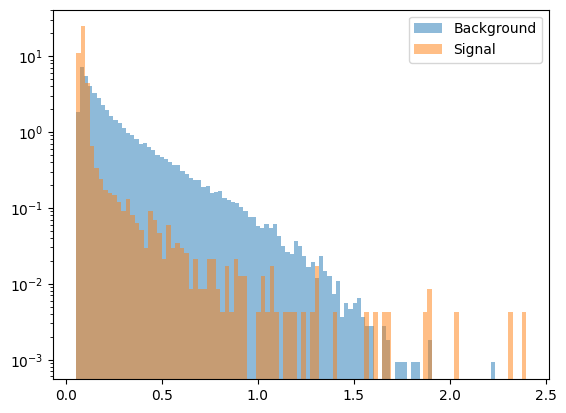

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_51.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


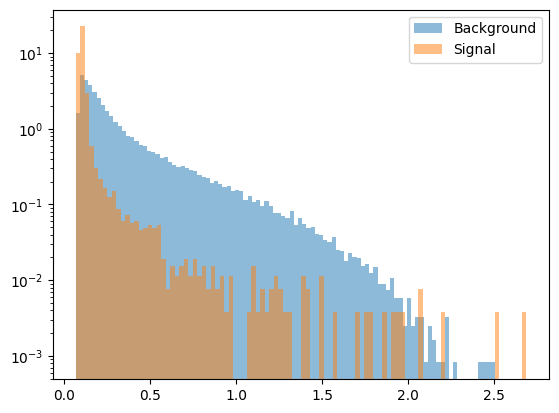

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_52.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


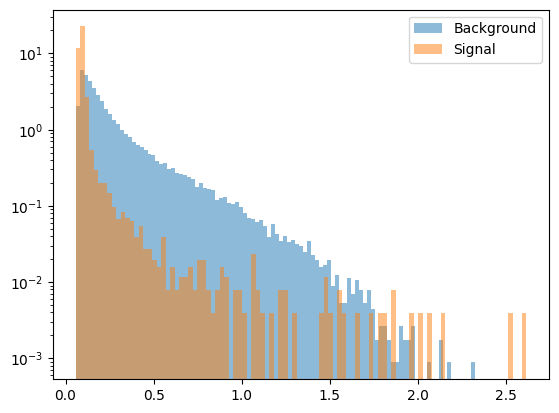

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_53.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


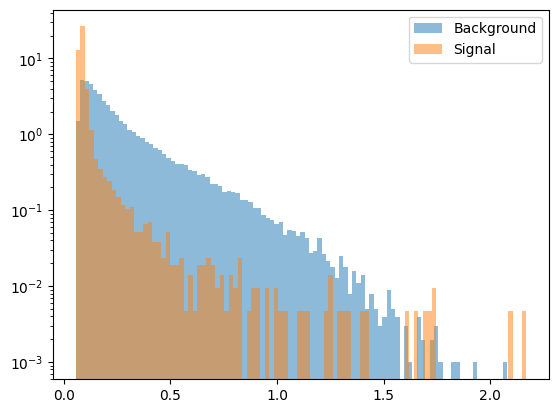

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_54.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


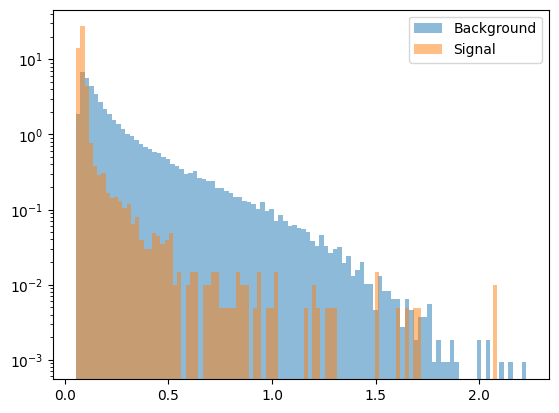

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_55.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


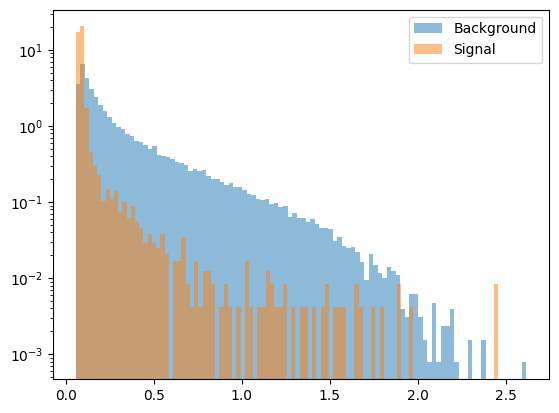

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_56.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


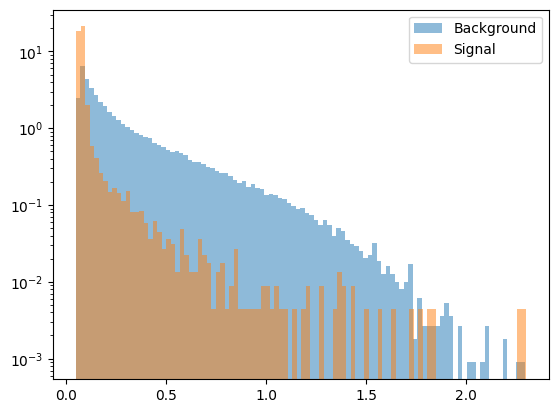

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_57.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


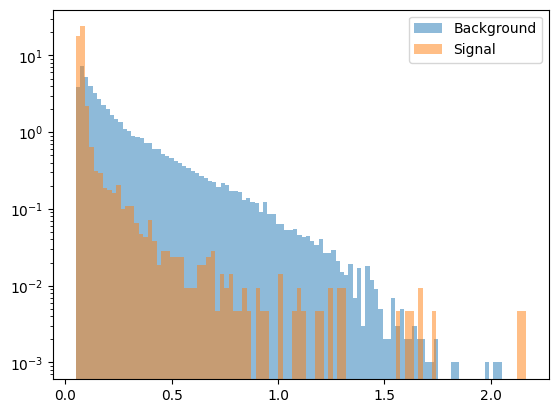

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_58.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


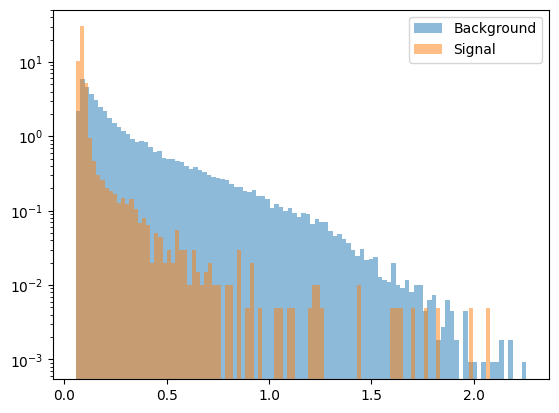

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_59.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


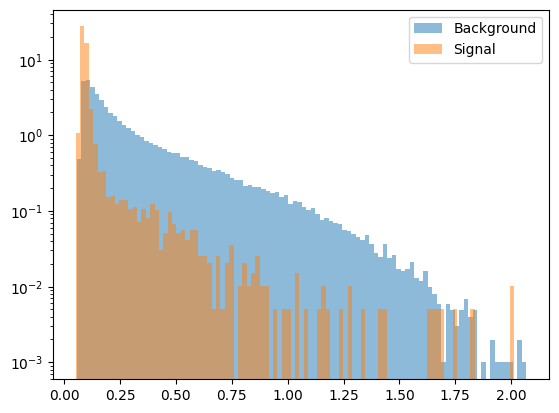

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_60.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


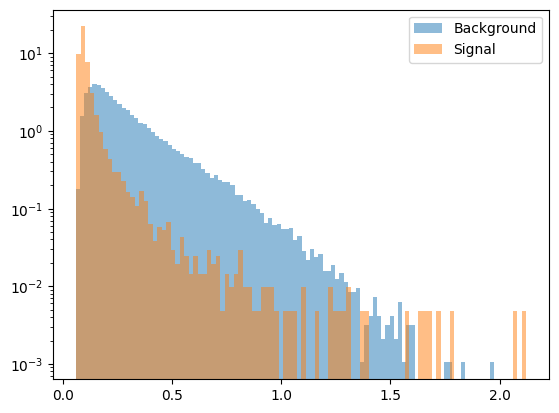

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_61.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


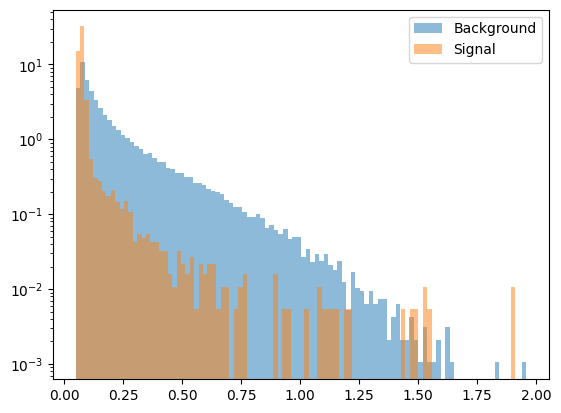

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_62.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


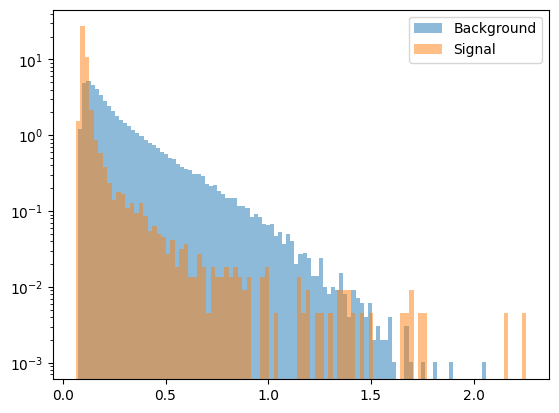

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_63.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


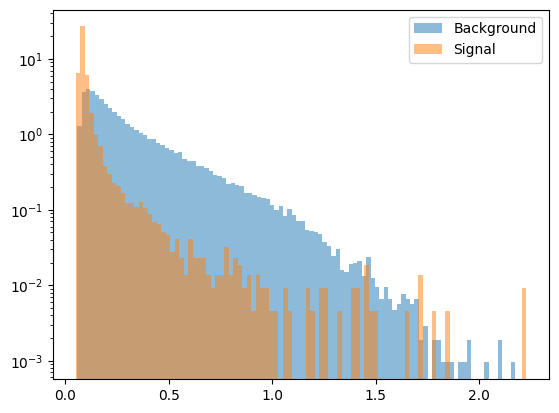

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_64.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


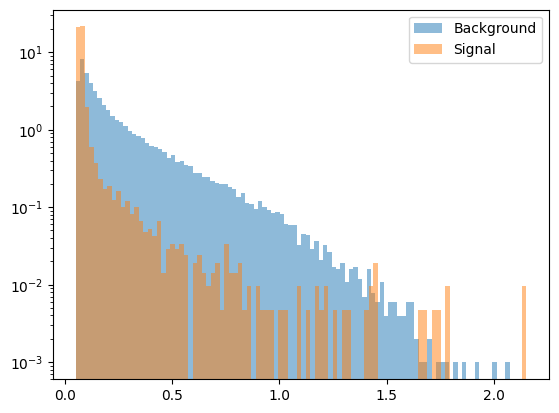

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_65.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


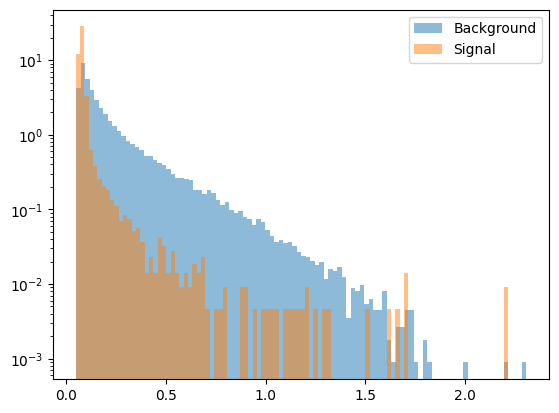

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_66.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


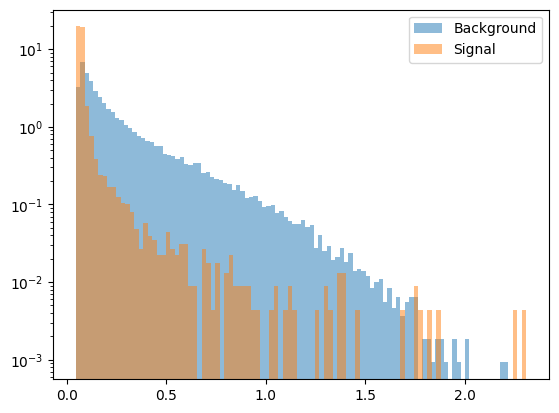

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_67.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


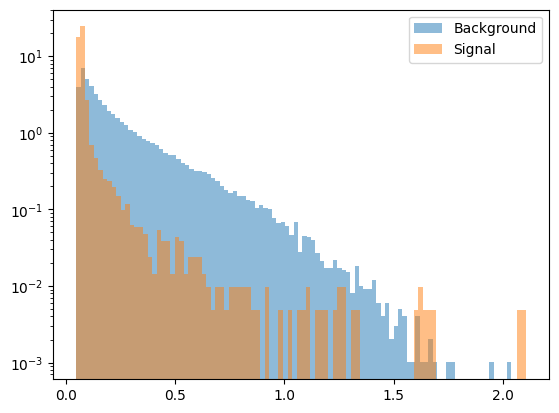

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_68.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


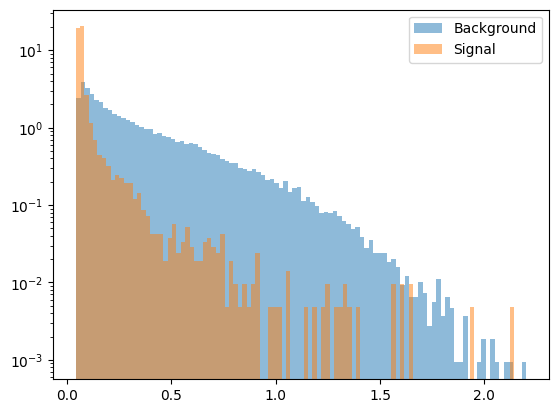

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_69.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


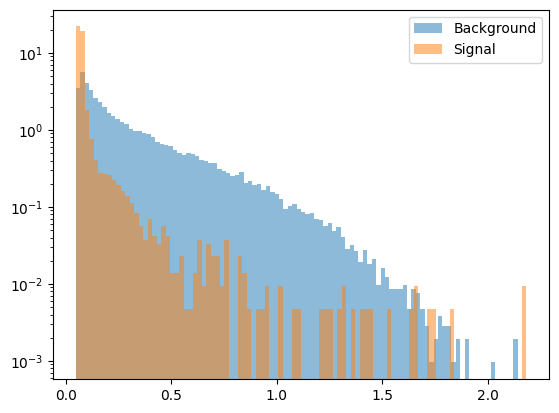

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_70.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


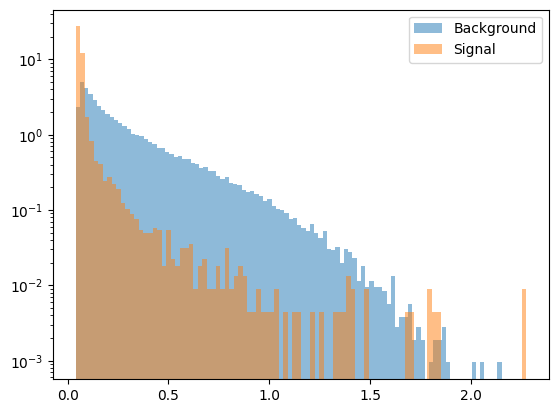

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_71.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


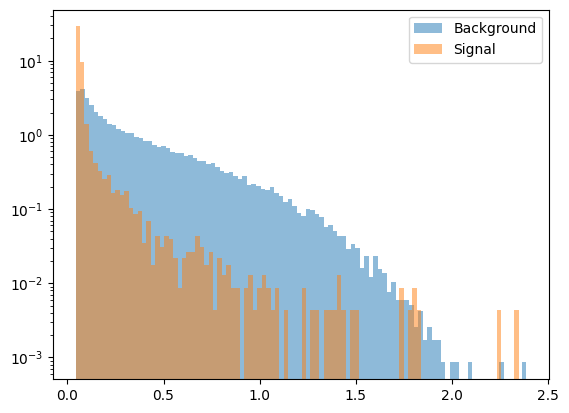

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_72.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


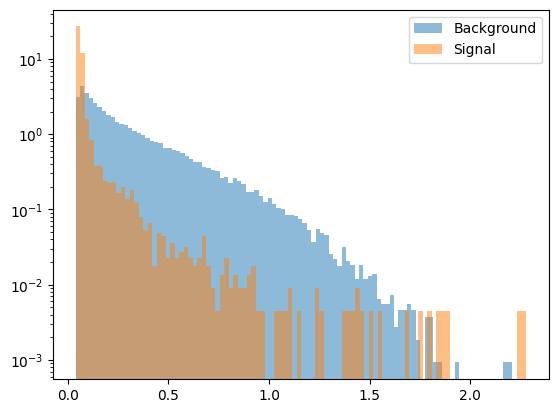

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_73.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


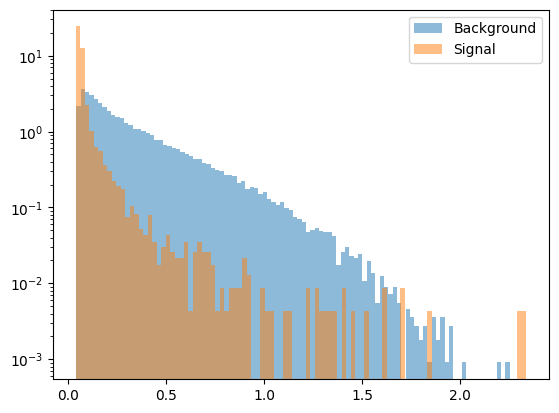

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_74.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


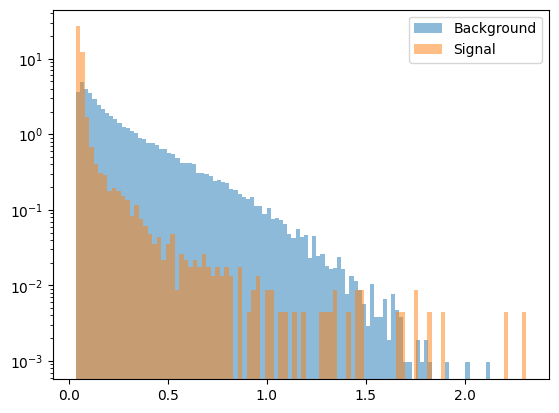

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_75.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


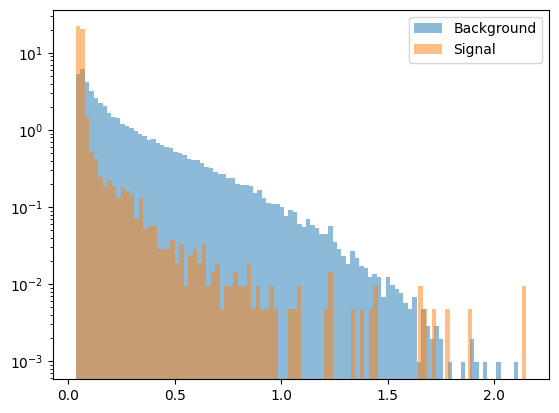

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_76.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


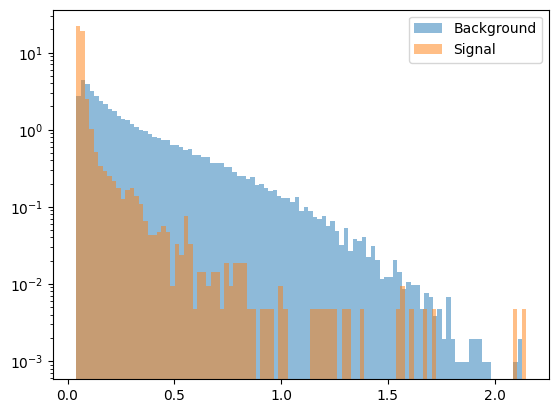

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_77.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


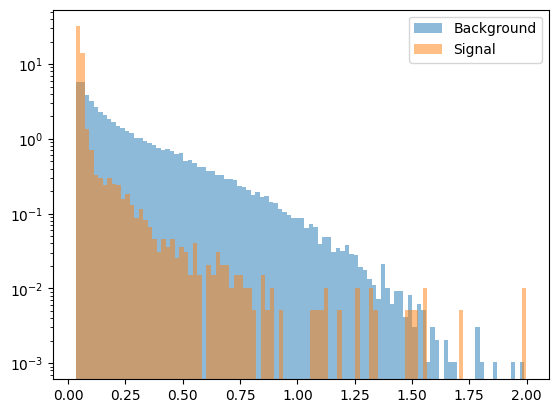

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_78.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


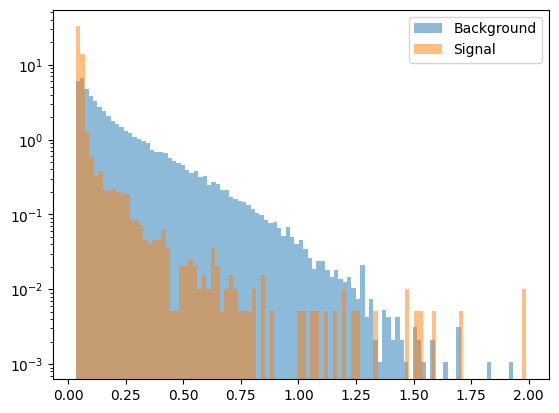

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_79.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


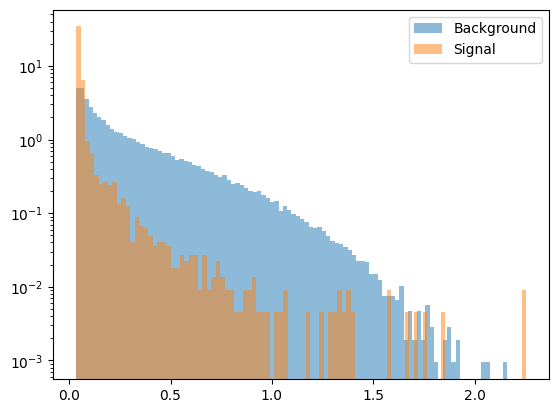

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_80.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


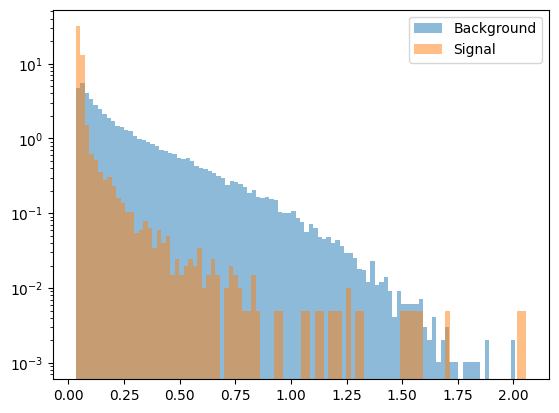

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_81.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


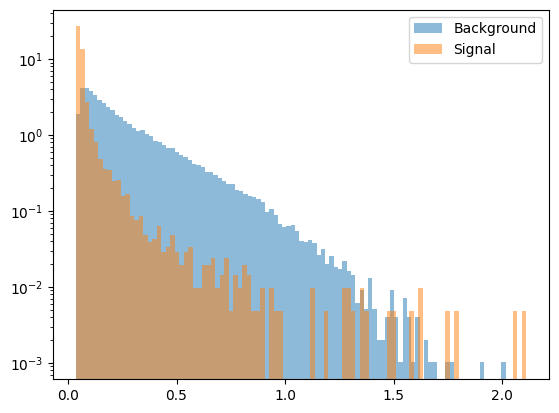

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_82.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


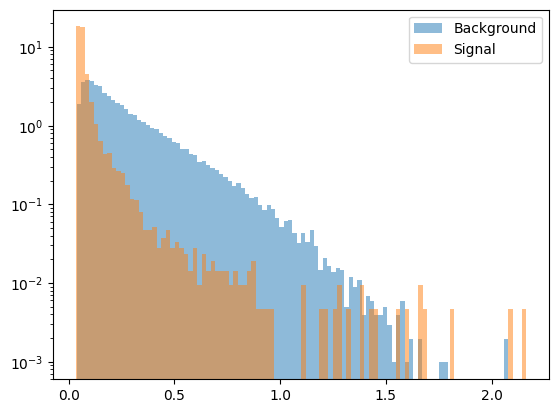

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_83.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


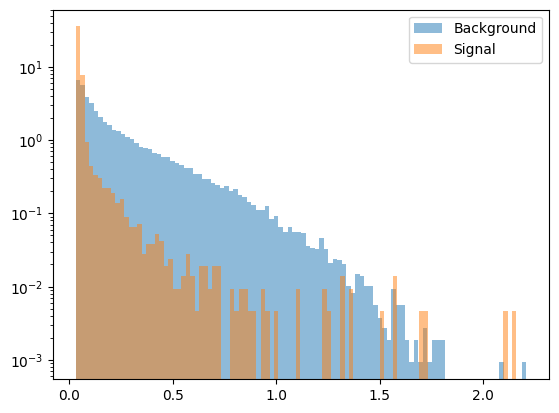

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_84.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


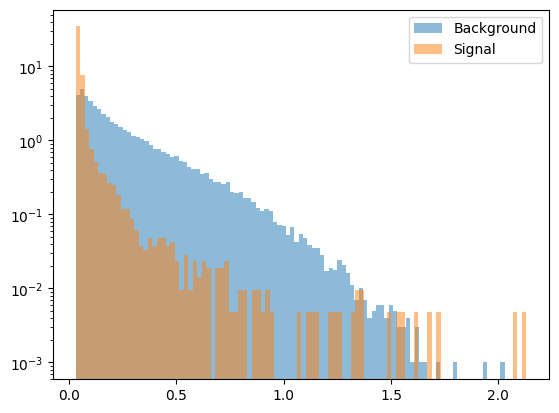

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_85.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


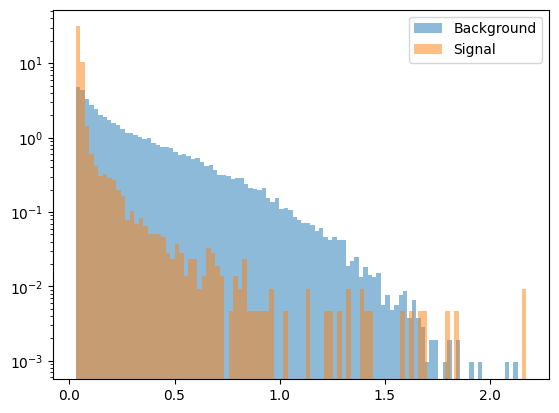

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_86.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


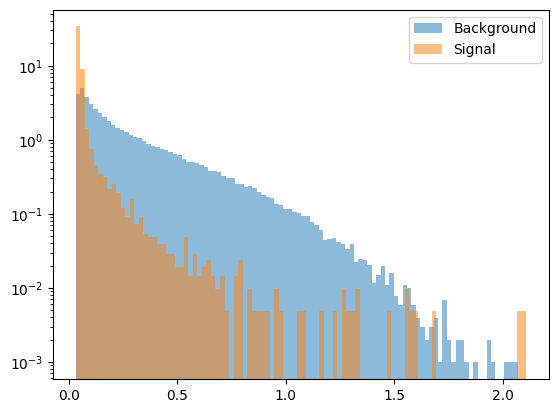

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_87.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


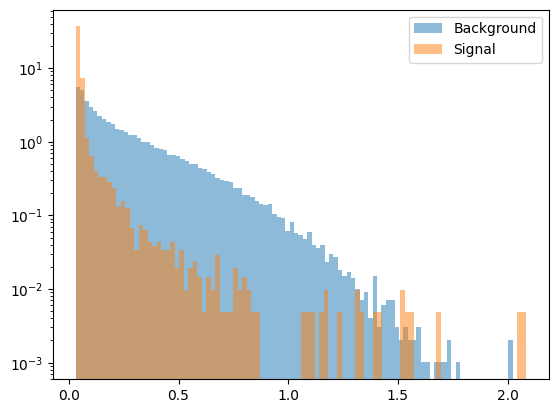

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_88.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


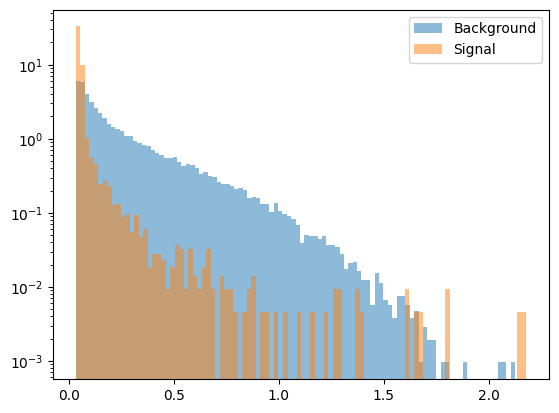

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_89.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


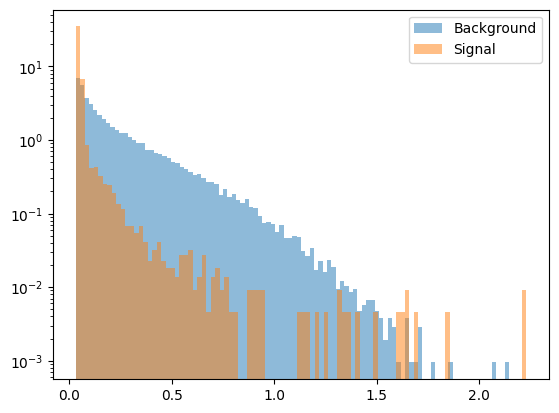

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_90.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


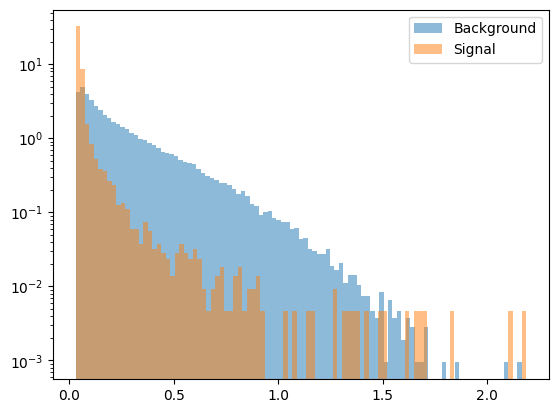

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_91.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


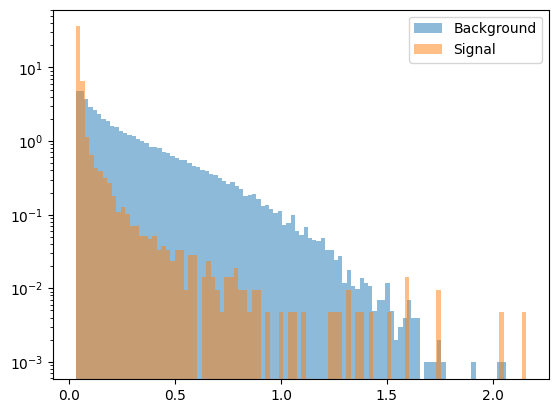

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_92.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


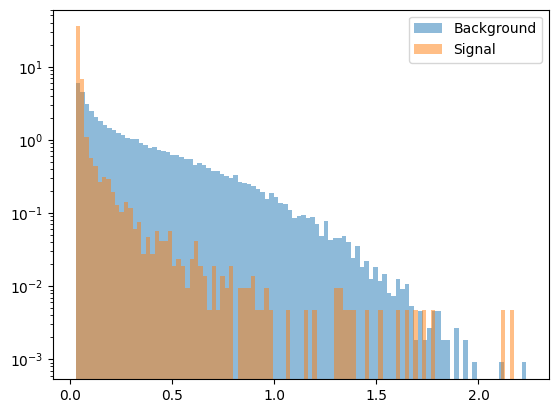

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_93.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


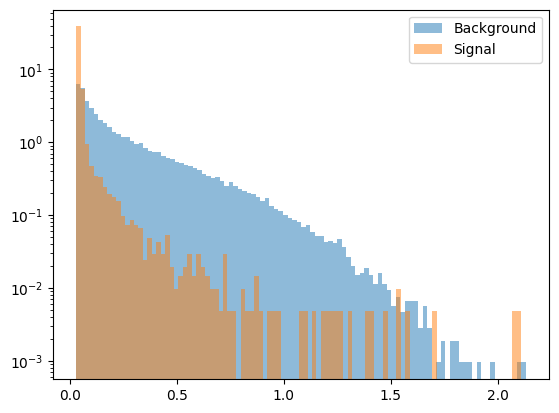

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_94.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


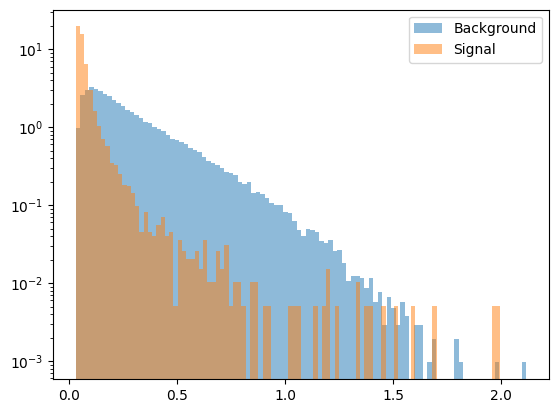

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_95.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


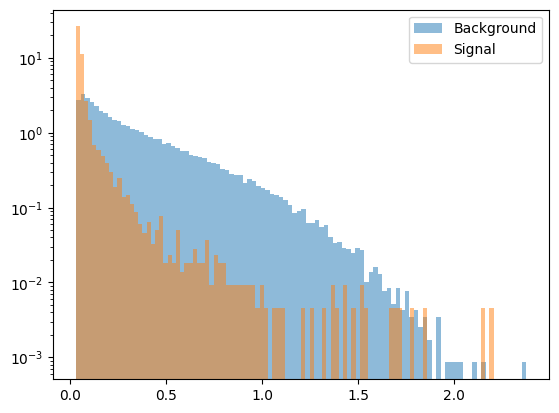

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_96.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


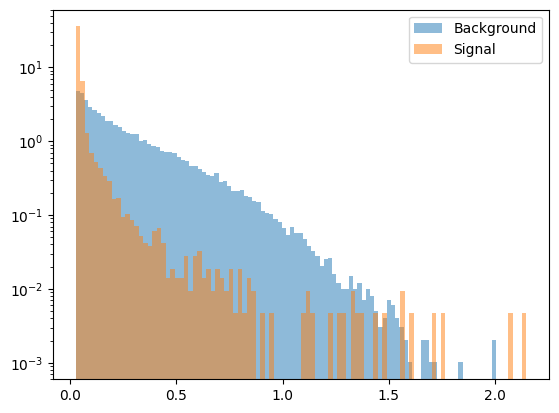

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_97.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


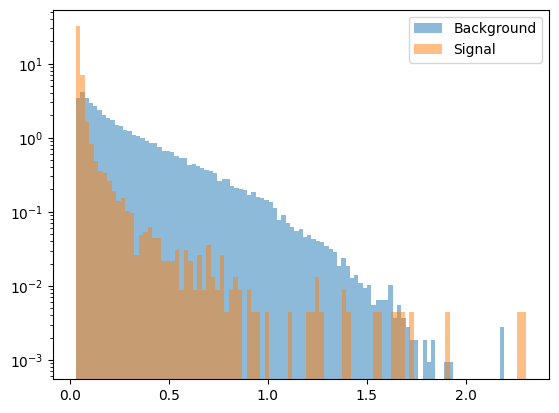

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_98.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


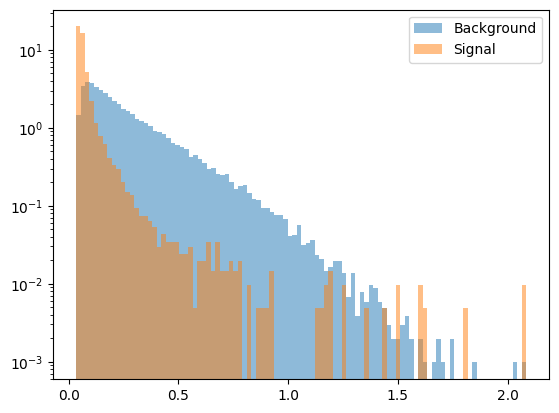

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_99.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


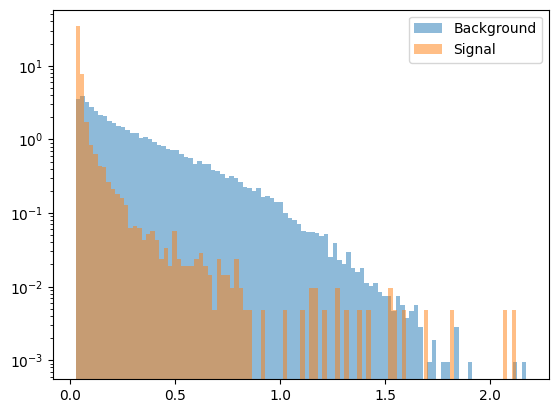

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model3_epoch_100.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


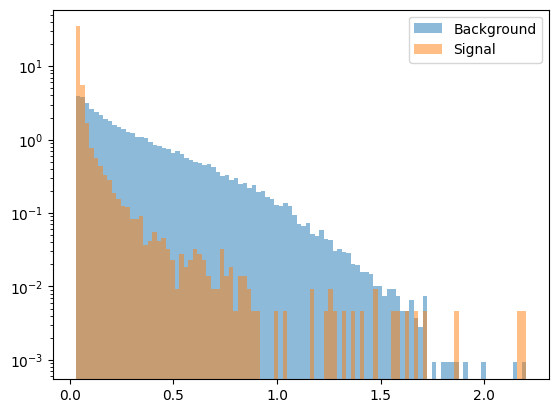

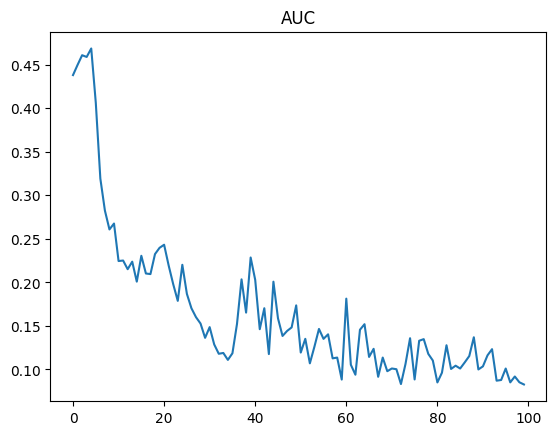

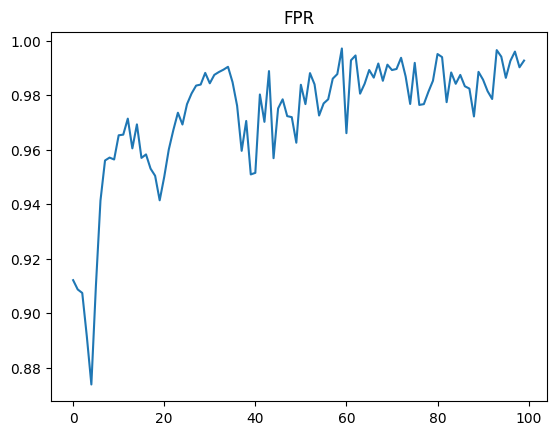

In [ ]:
from sklearn.metrics import roc_curve, auc
def eval_test(model,background_test_data,signal_test_data):
  bg_test = model.predict(background_test_data)['autoencoder_output']
  sg_test = model.predict(signal_test_data)['autoencoder_output']
  mse_bg = np.mean((bg_test - background_test_data)**2, axis=(1,2))
  mse_sg = np.mean((sg_test - signal_test_data)**2, axis=(1,2))
  pred_val = np.concatenate((mse_sg, mse_bg))
  true_val = np.concatenate((np.ones(mse_sg.shape[0]), np.zeros(mse_bg.shape[0])))
  fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
  AUC = auc(fpr_loss, tpr_loss)
  idx = np.argmin(np.abs(tpr_loss - 0.90))    #nearest value's index at 0.9 TPR
  desired_fpr = fpr_loss[idx]    #FPR at 0.9 TPR
  return AUC, desired_fpr, mse_bg, mse_sg

AUC_test=[]
FPR_test = []

for model_file in model_files:
    print(f"Evaluating model: {model_file}")
    model = load_model(model_file, custom_objects={"masked_mse_loss": masked_mse_loss})
    AUC_, FPR_, mse_bg, mse_sg = eval_test(model,background_test_data,signal_test_data)
    plt.hist(mse_bg, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='Signal')
    plt.semilogy()
    plt.legend()
    plt.show()
    AUC_test.append(AUC_)
    FPR_test.append(FPR_)
plt.plot(AUC_test)
plt.title('AUC')
plt.show()
plt.plot(FPR_test)
plt.title('FPR')
plt.show()

In [ ]:
max(AUC_test),min(FPR_test)
#sg_auc,fpr_sg,AUC_test,FPR_test

(np.float64(0.46858066400000004), np.float64(0.8738))